In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [138]:
from IPython.core.display import display, HTML, Markdown, Latex
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

wandb: Appending key for api.wandb.ai to your netrc file: /home/gd1279/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [5]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, ndimage
from scipy.special import factorial
from sklearn.metrics import mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

import pickle
import tabulate
import wandb
from collections import defaultdict, deque, namedtuple
import os
import argparse
import atari_py
import torch
import torch.nn.functional as F

from agent import Agent
from env import make_env
from masker import ALL_MASKERS

In [6]:
np.set_printoptions(precision=5)

In [7]:
api = wandb.Api()

In [8]:
CHECKPOINT_SCRATCH_FOLDER = '/scratch/gd1279'

if not os.path.exists(CHECKPOINT_SCRATCH_FOLDER):
    os.mkdir(CHECKPOINT_SCRATCH_FOLDER)

# Recreate the args 

In [9]:
# Note that hyperparameters may originally be reported in ATARI game frames instead of agent steps
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--save-evaluation-gifs', action='store_true', help='Save GIFs of evaluation episodes')
parser.add_argument('--evaluation-gif-folder', default=None, help='Folder to save evaluation GIFs in')
parser.add_argument('--save-evaluation-states', action='store_true', help='Save the states of evaluation episodes')
parser.add_argument('--evaluation-state-folder', default=None, help='Folder to save evaluation state in')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)
parser.add_argument('--memory-save-interval', type=int, default=None, help='How often to save the memory, defaults to the evaluation interval')
parser.add_argument('--use-native-pickle-serialization', action='store_true', help='Use native pickle saving rather than torch.save()')

# Arguments for the augmented representations
parser.add_argument('--add-masks', action='store_true', help='Add masks for each semantic object types')
parser.add_argument('--maskers', default=None, help='Select specific maskers to use')
parser.add_argument('--use-numpy-masker', action='store_true', help='Use the previous, much slower numpy-based masker')
parser.add_argument('--omit-pixels', action='store_true', help='Omit the raw pixels from the environment')

# Arguments to give it a soft time cap that will help it not fail
parser.add_argument('--soft-time-cap', help='Format: <DD>:HH:MM, stop after some soft cap such that the saving the memory does not fail')

# Debugging-related arguments
parser.add_argument('--debug-heap', action='store_true')
parser.add_argument('--heap-interval', default=1e4)
parser.add_argument('--heap-debug-file', default=None)


_StoreAction(option_strings=['--heap-debug-file'], dest='heap_debug_file', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

# Load a run and its model

In [10]:
def download_checkpoint(run, step=None):
    files = run.files()
    if step is None:
        step = max([int(f.name[f.name.rfind('-') + 1:f.name.rfind('.')]) 
                    for f in files 
                    if f.name.endswith('.pth')])
        
    sample_name = [f.name for f in files if f.name.endswith('.pth')][0]
    checkpoint_name = sample_name[:sample_name.rfind('-')]
    checkpoint_file = f'{checkpoint_name}-{step}.pth'
    run.file(checkpoint_file).download(replace=True, root=CHECKPOINT_SCRATCH_FOLDER)
    return os.path.join(CHECKPOINT_SCRATCH_FOLDER, checkpoint_file)


def setup_args(run):
    args = parser.parse_args([])
    config = run.config
    
    for key in config:
        if key in args:
            args.__setattr__(key, config[key])
            
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    if torch.cuda.is_available() and not args.disable_cuda:
        args.device = torch.device('cuda')
        # torch.cuda.manual_seed(np.random.randint(1, 10000))
        torch.cuda.manual_seed(args.seed)
        torch.backends.cudnn.enabled = args.enable_cudnn
    else:
        args.device = torch.device('cpu')
            
    return args


LOADED_MODEL_CACHE = {}


def load_model_from_run(run, cache=LOADED_MODEL_CACHE):
    if run not in cache:
        checkpoint_path = download_checkpoint(run)
        args = setup_args(run)
        args.model = checkpoint_path

        env = make_env(args)
        dqn = Agent(args, env)
        cache[run] = dqn, env
        
    return cache[run]

## Utilities

In [11]:
from MulticoreTSNE import MulticoreTSNE as TSNE


ModelResults = namedtuple('ModelResults', 
                          ('hidden_states', 'q_values', 'state_values', 'actions'))

KeyIndex = namedtuple('KeyIndex',
                      ('peak_index', 'peak_value', 'start', 'end', 'count', 'indices'))


def rgb_to_grayscale(obs):
    # My best approximation of how the ALE does it
    rgb = obs.astype('float32')
    return (rgb[:,:,0] * 0.299 + rgb[:,:,1] * 0.587 + rgb[:,:,2] * 0.114).astype(np.uint8)


def observation_to_model(env, obs):
    return env._prepare_state(env._to_tensor(rgb_to_grayscale(obs)), env._to_tensor(obs))


MAX_STATE_IDX = None
SKIP = 2


def pass_states_through_model(model, env, observations, max_state_idx=MAX_STATE_IDX, skip=SKIP):
    state_buffer = deque([], maxlen=4)
    hidden_states = []
    q_values = []
    state_values = []
    actions = []

    for frame in observations[:3]:
        state_buffer.append(observation_to_model(env, frame))

    with torch.no_grad():
        for frame in observations[3:max_state_idx]:
            state_buffer.append(observation_to_model(env, frame))
            state = torch.cat(list(state_buffer), 0)
            
            hidden_state = model.online_net.convs(state.unsqueeze(0)).view(-1)
            hidden_states.append(hidden_state.detach().cpu().numpy())
            
            q_values.append(model.expected_q_values(state))
            state_values.append(model.evaluate_q(state))
            actions.append(model.act(state))

    hidden_state_array = np.array(hidden_states[::skip])
    q_values_array = np.array(q_values[::skip])
    state_value_array = np.array(state_values[::skip])
    action_array = np.array(actions[::skip])
    
    return ModelResults(hidden_state_array, q_values_array, state_value_array, action_array)


def plot_entire_state(observations, start_index, num_frames=4):
    figure = plt.figure(figsize=(18, 4))
    for i in range(num_frames):
        ax = plt.subplot(1, num_frames, i + 1)
        ax.imshow(observations[start_index + i])
        
    plt.show()
    

def plot_embeddings_and_state(embeddings, color_values, observations, start_index, special_indices=None, num_frames=4,
                              low_alpha=0.1, medium_alpha=0.7, alpha_threshold=0.7):
    fig = plt.figure(constrained_layout=True, figsize=(16, 8))
    gs = fig.add_gridspec(2, 4)
    
    tsne_ax = fig.add_subplot(gs[:, :2])
    cmap = matplotlib.cm.get_cmap('Spectral_r')
    normalizer = matplotlib.colors.Normalize(np.min(color_values), np.max(color_values))

    colors = np.array([cmap(normalizer(d)) for d in color_values])
    colors[:,3] = np.abs(color_values) / np.max(np.abs(color_values))
    colors[colors[:,3] > alpha_threshold, 3] = medium_alpha
    colors[colors[:,3] < alpha_threshold, 3] = low_alpha

    mask = np.zeros(Y.shape[0], dtype=bool)
    if special_indices is not None:
        mask[special_indices] = True
        colors[mask, 3] = 1

    tsne_ax.scatter(embeddings[~mask, 0], embeddings[~mask, 1], color=colors[~mask])
    tsne_ax.scatter(embeddings[mask, 0], embeddings[mask, 1], color='purple', s=50, marker='x')
    plt.colorbar(matplotlib.cm.ScalarMappable(norm=normalizer, cmap=cmap), ax=tsne_ax)
    
    for i in range(num_frames):
        ax = fig.add_subplot(gs[i // 2, 2 + (i % 2)])
        ax.imshow(observations[start_index + i])
        
    plt.show()
    
    
ALE_ACTIONS = {
    0: 'noop',
    1: 'fire',
    2: 'up',
    3: 'right',
    4: 'left',
    5: 'down',
    6: 'up + right',
    7: 'up + left',
    8: 'down + right',
    9: 'down + left',
    10: 'up + fire',
    11: 'right + fire',
    12: 'left + fire',
    13: 'down + fire',
    14: 'up + right + fire',
    15: 'up + left + fire',
    16: 'down + right + fire',
    17: 'down + left + fire'
}


def print_model_state_description(results, name, index, top_k=3):
    value = results.state_values[index]
    action = results.actions[index]
    print(f'{name} had value {value:.3f} => {ALE_ACTIONS[action]} ({action})')
    q = results.q_values[index].cpu().numpy()
    top_actions = np.argpartition(q, -top_k)[-top_k:]
    top_actions = top_actions[np.argsort(q[top_actions])][::-1]
    p = F.softmax(results.q_values[index], dim=0)
    print(' | '.join([f'({i + 1}) {ALE_ACTIONS[a]} [{a}], Q = {q[a]:.3f}, P = {p[a]:.3f}' for i, a in enumerate(top_actions)]))

    
def describe_states_by_indices(indices, first_model_results, first_model_name, second_model_results, second_model_name, 
                               observations, embeddings, color_values, top_k=3, plot_embeddings=False):
    for key_index in sorted(indices, key=lambda ki: ki.peak_index):
        index = key_index.peak_index
        print(f'At index {index}')
        print_model_state_description(first_model_results, first_model_name, index, top_k)
        print_model_state_description(second_model_results, second_model_name, index, top_k)
        
        if plot_embeddings:
            plot_embeddings_and_state(embeddings, color_values, observations, 
                                      key_index.peak_index, 
                                      special_indices=key_index.indices)
        else:
            plot_entire_state(observations, index)
    
    
def find_diverging_states(values, indices, min_distance=10):
    index_values = [values[i] for i in indices]
    output = [KeyIndex(indices[0], index_values[0], indices[0], indices[0], 1, [indices[0]])]
    
    for index, value in zip(indices[1:], index_values[1:]):
        current = output[-1]
        
        # Sufficiently far away, append a new one
        if index > current.end + min_distance:
            output.append(KeyIndex(index, value, index, index, 1, [index]))
            
        # Value more extreme, replace peak
        elif abs(value) > abs(current.peak_value):  
            output[-1] = KeyIndex(index, value, current.start, index, current.count + 1, current.indices + [index])
            
        # Value not more extreme, extend
        else:
            output[-1] = KeyIndex(current.peak_index, current.peak_value, current.start, index, current.count + 1, current.indices + [index])
            
    return output

# Gameplan

1. See that I can locate objects
2. See that I can add additional objects
3. See what this changes

# Scratch

Using model 306 from the baseline condition, one of the average models, not the 'superstar' one

In [ ]:
SAMPLE_SAVED_STATES = r'/home/gd1279/scratch/rainbow-evaluation-state-traces/baseline-rainbow-305/evaluation/states/eval-baseline-rainbow-305-34350000-0-env.pickle'

with open(SAMPLE_SAVED_STATES, 'rb') as state_file:
    sample_full_color_observations = pickle.load(state_file)
    
    
sample_full_color_observations = sample_full_color_observations.astype(np.uint8)
print(sample_full_color_observations.shape)

In [ ]:
baseline_run = api.run('augmented-frostbite/initial-experiments/runs/fdxobftk')
baseline_model, baseline_env = load_model_from_run(baseline_run)

In [ ]:
baseline_model_results = pass_states_through_model(baseline_model, baseline_env, sample_full_color_observations, skip=1)

baseline_model_results.hidden_states.shape

In [ ]:
tsne = TSNE(n_jobs=4)
Y = tsne.fit_transform(baseline_model_results.hidden_states)
Y.shape

In [ ]:
masks_only_run = api.run('augmented-frostbite/masks-only-replication/runs/0khc2n2c')
masks_only_model, masks_only_env = load_model_from_run(masks_only_run)
masks_only_model_results = pass_states_through_model(masks_only_model, masks_only_env, sample_full_color_observations, skip=1)

In [ ]:
frame_idx = 1100
state = observation_to_model(masks_only_env, sample_full_color_observations[frame_idx]).cpu().numpy()

plt.figure(figsize=(24, 4))
for i in range(state.shape[0]):
    ax = plt.subplot(1, 8, i + 1)
    ax.imshow(state[i], cmap='Greys')
    
plt.show()

In [ ]:
DIAGONAL_CONNECTIVITY_STRUCTURE = ndimage.generate_binary_structure(2, 2)


def extract_object(observations, obs_index, model, env, channel_index, 
                   object_index=0, structure=DIAGONAL_CONNECTIVITY_STRUCTURE,
                   return_tensor=True, return_location=False):
    state = observation_to_model(env, observations[obs_index]).cpu().numpy()
    labeled, count = ndimage.label(state[channel_index], structure)
    locations = ndimage.find_objects(labeled, 0)
    print(locations)
    loc = locations[object_index]
    if return_location:
        return loc
    
    object_arr = state[channel_index, loc[0], loc[1]]
    if return_tensor:
        return torch.Tensor(object_arr).to(model.online_net.convs[0].weight.device)
    
    return object_arr
    

In [ ]:
obj = extract_object(sample_full_color_observations, 1100, masks_only_model, masks_only_env, 1, 1, return_tensor=False)
plt.imshow(obj, cmap='Greys')

In [ ]:


labeled, count = ndimage.label(state[0], structure)
loc = ndimage.find_objects(labeled, 1)[0]
plt.imshow(state[0, loc[0], loc[1]], cmap='Greys')

In [ ]:
state_copy = np.copy(state)
state_copy = copy_object(state_copy, 0, loc, (20, 20))

plt.figure(figsize=(24, 4))
for i in range(state_copy.shape[0]):
    ax = plt.subplot(1, 8, i + 1)
    ax.imshow(state_copy[i], cmap='Greys')
    
plt.show()

In [ ]:
mses = np.array([F.mse_loss(masks_only_model_results.q_values[i], masks_only_model_results.q_values[i].mean()).cpu().numpy() 
        for i in range(len(masks_only_model_results.q_values))])

max_idx = np.argmax(mses)
max_idx, mses[max_idx], masks_only_model_results.q_values[max_idx]

In [ ]:
frame_idx = 1449
state = observation_to_model(masks_only_env, sample_full_color_observations[frame_idx]).cpu().numpy()

plt.figure(figsize=(24, 4))
for i in range(state.shape[0]):
    ax = plt.subplot(1, 8, i + 1)
    ax.imshow(state[i], cmap='Greys')
    
plt.show()

In [ ]:
object_locations = []

for channel_idx in range(state.shape[0]):
    labeled, count = ndimage.label(state[channel_idx], structure)
    object_locations.append(ndimage.find_objects(labeled))

In [ ]:
def print_model_state_description(state, name, index, top_k=3):
    value = results.state_values[index]
    action = results.actions[index]
    print(f'{name} had value {value:.3f} => {ALE_ACTIONS[action]} ({action})')
    q = results.q_values[index].cpu().numpy()
    top_actions = np.argpartition(q, -top_k)[-top_k:]
    top_actions = top_actions[np.argsort(q[top_actions])][::-1]
    p = F.softmax(results.q_values[index], dim=0)
    print(' | '.join([f'({i + 1}) {ALE_ACTIONS[a]} [{a}], Q = {q[a]:.3f}, P = {p[a]:.3f}' for i, a in enumerate(top_actions)]))

In [ ]:
new_player_locations = [(20, 20), (20, 60), (60, 20), (60, 60)]

for i in range(len(new_player_locations)):
    state_copy = np.copy(state)
    for j in range(i + 1):
        state_copy = copy_object(state_copy, 0, object_locations[0][0], new_player_locations[j])
        
    state_tensor = torch.Tensor(state_copy).to(masks_only_model.online_net.convs[0].weight.device)
    
    

# More organized take at this code

In [12]:
ChannelAugmentation = namedtuple('ChannelAugmentation', 
                                 ('channel_index', 'added_object', 'added_location'))

ModelAugmentation = namedtuple('ModelAugmentation', 
                               ('name', 'model', 'env', 'augmentations'))


def augment_single_channel(state, channel_augmentation):
    dst_slices = [slice(channel_augmentation.added_location[i], 
                        channel_augmentation.added_location[i] + channel_augmentation.added_object.shape[i])
                  for i in range(len(channel_augmentation.added_location))] 
    state[channel_augmentation.channel_index, dst_slices[0], dst_slices[1]] = channel_augmentation.added_object
    return state
    

def modify_state(state, augmentations):
    for augmentation in augmentations:
        state = augment_single_channel(state, augmentation)
        
    return state


def augmented_state_q_values(observations, augmented_index, model_augmentations, state_length=4, return_before_and_after=False):
    if augmented_index < state_length or augmented_index >= len(observations):
        raise ValueError(f'Augmented index should be in [{state_length}, {len(observations)}), received {augmented_index}')

    before_q_values_per_model = []
    after_q_values_per_model = []
    before, after = None, None
    
    for model_augmentation in model_augmentations:
        # TODO: verify I don't have an off-by-one here
        state_buffer = [observation_to_model(model_augmentation.env, obs) 
                        for obs in observations[augmented_index - state_length + 1:augmented_index + 1]]
        
        if return_before_and_after and before is None:
            before = state_buffer[-1][0].cpu().numpy()
        model_ready_state = torch.cat(list(state_buffer), 0)
        before_q_values_per_model.append(model_augmentation.model.expected_q_values(model_ready_state))

        augmented_state = modify_state(state_buffer[-1], model_augmentation.augmentations)
        if return_before_and_after and after is None:
            after = state_buffer[-1][0].cpu().numpy()
            
        # TODO: consider the case of augmenting more than one consecutive states
        state_buffer[-1] = augmented_state
        model_ready_state = torch.cat(list(state_buffer), 0)
        # TODO: grab action values or state values if need be
        after_q_values_per_model.append(model_augmentation.model.expected_q_values(model_ready_state))

    if return_before_and_after:
        return before_q_values_per_model, after_q_values_per_model, before, after
    
    return before_q_values_per_model, after_q_values_per_model


def max_wrapper(tensor, axis=0):
    val, idx = tensor.max(axis)
    return float(val), int(idx)


def evaluate_augmented_models(observations, augmented_index, model_augmentations, state_length=4,
                              before_color='red', after_color='blue', bar_alpha=0.5,
                              bar_width=0.8, fontdict=dict(fontsize=16), force_text=None, text_epsilon=0,
                              plot_state=True):
    if plot_state:
        fig = plt.figure(constrained_layout=True, figsize=(8 * len(model_augmentations) + 1, 6))
        gs = fig.add_gridspec(2, 7)
        before_q_values_per_model, after_q_values_per_model, before_state, after_state = augmented_state_q_values(observations, 
            augmented_index, model_augmentations, state_length=state_length, return_before_and_after=True)

        before_ax = fig.add_subplot(gs[0, 0])
        before_ax.imshow(before_state, cmap='gray')
        before_ax.set_title('Before')
        
        after_ax = fig.add_subplot(gs[1, 0])
        after_ax.imshow(after_state, cmap='gray')
        after_ax.set_title('After')
    
    else:
        plt.figure(figsize=(8 * len(model_augmentations), 6))
        before_q_values_per_model, after_q_values_per_model = augmented_state_q_values(observations, augmented_index, 
                                                                                       model_augmentations, state_length=state_length)

    

    for i, (model_augmentation, before_q, after_q) in enumerate(zip(model_augmentations, before_q_values_per_model,
                                                                          after_q_values_per_model)):
        print(f'For model {model_augmentation.name}:')
        baseline_mean, augmented_mean = before_q.mean().cpu().numpy(), after_q.mean().cpu().numpy()
        print(f'Baseline mean: {baseline_mean:.3f} | Augmented mean: {augmented_mean:.3f} | Difference: {augmented_mean - baseline_mean:.3f}')
        
        diff = after_q - before_q
        max_diff, max_diff_idx = max_wrapper(diff.abs())
        print(f'Max Q value diff is {max_diff:.3f} for action {ALE_ACTIONS[max_diff_idx]} [{max_diff_idx}]')

        if plot_state:
            ax = fig.add_subplot(gs[:, 1 + 2 * i :1 + 2 * (i + 1)])
        else:
            ax = plt.subplot(1, len(model_augmentations), i + 1)
        
        locations = np.arange(before_q.shape[0]) * bar_width * 2.5
        ax.bar(locations, before_q.cpu().numpy(), color=before_color, alpha=bar_alpha)
        ax.bar(locations + bar_width, after_q.cpu().numpy(), color=after_color, alpha=bar_alpha)
        ax.hlines([baseline_mean, augmented_mean], *ax.get_xlim(), colors=[before_color, after_color],
                  linestyles='dashed')
        
        text_fd = {k:fontdict[k] for k in fontdict}
        ax.text(locations[max_diff_idx] + bar_width / 2, max(before_q[max_diff_idx], after_q[max_diff_idx]) + text_epsilon,
                '*', fontdict=text_fd)
        
        before_action_q, before_action_idx = max_wrapper(before_q)
        after_action_q, after_action_idx = max_wrapper(after_q)
        
        print(f'Before action: {ALE_ACTIONS[before_action_idx]} [{before_action_idx}] (Q = {before_action_q:.3f}) | After action: {ALE_ACTIONS[after_action_idx]} [{after_action_idx}] (Q = {after_action_q:.3f})')
        
        if before_action_idx != after_action_idx or (force_text is not None and force_text):
            text_fd['color'] = before_color
            ax.text(locations[before_action_idx] - (bar_width / 2), before_action_q + text_epsilon, 'B', fontdict=text_fd)

            text_fd['color'] = after_color
            ax.text(locations[after_action_idx] + (bar_width / 2), after_action_q + text_epsilon, 'A', fontdict=text_fd)
        
        ax.set_xticks(locations + (bar_width / 2))
        ax.set_xticklabels(sorted(ALE_ACTIONS.keys()))
        
        ax.set_xlabel('Action Index', fontdict=fontdict)
        ax.set_ylabel('Q Value', fontdict=fontdict)
        ax.set_title(model_augmentation.name, fontdict=fontdict)
        print()

    plt.show()


def evaluate_augmented_models_multiple_XXX(*args):
    # TODO: if using multiple states or models, we need to average properly over the before_q / after_q tensors
    # That is, compute the average mean difference and the average max difference
    # The per-action bar charts might make less sense?
    # If we do this, we can plot a histogram of MMeanD and MMaxD and over the different random seeds (for one state)
    # Or the different states for one (or more) random seeds
    pass





In [33]:
DIAGONAL_CONNECTIVITY_STRUCTURE = ndimage.generate_binary_structure(2, 2)


def to_tensor(numpy_arr, model):
    return torch.Tensor(numpy_arr).to(model.online_net.convs[0].weight.device)


def extract_raw_pixels_object(observations, obs_index, model, env, loc):
    model_ready_obs = to_tensor(observation_to_model(env, observations[obs_index]).cpu().numpy(), model)
    return model_ready_obs.squeeze()[loc]


def extract_object(observations, obs_index, model, env, channel_index, 
                   object_index=0, structure=DIAGONAL_CONNECTIVITY_STRUCTURE,
                   return_tensor=True, return_location=False):
    state = observation_to_model(env, observations[obs_index]).cpu().numpy()
    labeled, count = ndimage.label(state[channel_index], structure)
    locations = ndimage.find_objects(labeled, 0)
    loc = locations[object_index]
    
    object_arr = state[channel_index, loc[0], loc[1]]
    if return_tensor:
        object_arr = to_tensor(object_arr, model)
        
    if not return_location:
        return object_arr
    
    return object_arr, loc
    

def copy_model_augmentation(model_augmentation, channel_augmentations):
    return ModelAugmentation(model_augmentation.name, model_augmentation.model, model_augmentation.env, channel_augmentations)


def make_augmentations_all_models(b_aug, m_p_aug, m_o_aug, pixels_tensor, mask_tensor, mask_only_channel_index, locations):
    baseline_augs = [ChannelAugmentation(0, pixels_tensor, loc) for loc in locations]
    mask_only_augs = [ChannelAugmentation(mask_only_channel_index, mask_tensor, loc) for loc in locations]
    maks_and_pixels_augs = baseline_augs[:]
    maks_and_pixels_augs.extend([ChannelAugmentation(c_a.channel_index + 1, c_a.added_object, c_a.added_location)
                                  for c_a in mask_only_augs])
    
    return copy_model_augmentation(b_aug, baseline_augs), copy_model_augmentation(m_p_aug, maks_and_pixels_augs),\
        copy_model_augmentation(m_o_aug, mask_only_augs)
    
    return b_aug, m_p_aug, m_o_aug
    

def plot_tensors(*tensors, norm=False):
    normalizer = None
    if norm:
        normalizer = matplotlib.colors.Normalize(0, 1)
    
    n = len(tensors)
    plt.figure(figsize=(4 * n, 4))
    for i, tensor in enumerate(tensors):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(tensors[i].cpu().numpy(), cmap='gray', norm=normalizer)
    
    plt.show()

    
def plot_observations(observations, start, count, step):
    plt.figure(figsize=(4 * count, 4))
    for i, idx in enumerate(range(start, start + count * step, step)):
        ax = plt.subplot(1, count, i + 1)
        ax.imshow(observations[idx])
        ax.set_title(idx)
        
    plt.show()
    
    
def plot_observations_by_indices(observations, indices):
    n = len(indices)
    plt.figure(figsize=(4 * n, 4))
    for i, idx in enumerate(indices):
        ax = plt.subplot(1, n, i + 1)
        ax.imshow(observations[idx])
        ax.set_title(idx)
        
    plt.show()
    
    
def change_intensity(tensor, additive=0, multiplicative=1, min_val=0, max_val=1):
    return torch.clamp(tensor * multiplicative + additive, min_val, max_val)
    

DEFAULT_MASK_NAMES = (
    'None',
    'player',
    'bad_animal',
    'land',
    'bear',
    'unvisited_floe',
    'visited_floe',
    'good_animal',
    'igloo'
)

# Setup

In [14]:
SAMPLE_SAVED_STATES = r'/home/gd1279/scratch/rainbow-evaluation-state-traces/baseline-rainbow-305/evaluation/states/eval-baseline-rainbow-305-34350000-0-env.pickle'

with open(SAMPLE_SAVED_STATES, 'rb') as state_file:
    sample_full_color_observations = pickle.load(state_file)
    
    
sample_full_color_observations = sample_full_color_observations.astype(np.uint8)
print(sample_full_color_observations.shape)


baseline_run = api.run('augmented-frostbite/initial-experiments/runs/fdxobftk')
baseline_model, baseline_env = load_model_from_run(baseline_run)
baseline_model_results = pass_states_through_model(baseline_model, baseline_env, sample_full_color_observations, skip=1)

masks_and_pixels_run = api.run('augmented-frostbite/masks-and-pixels-replication/runs/grh1bzvv')
masks_and_pixels_model, masks_and_pixels_env = load_model_from_run(masks_and_pixels_run)
masks_and_pixels_model_results = pass_states_through_model(masks_and_pixels_model, masks_and_pixels_env, sample_full_color_observations, skip=1)

masks_only_run = api.run('augmented-frostbite/masks-only-replication/runs/0khc2n2c')
masks_only_model, masks_only_env = load_model_from_run(masks_only_run)
masks_only_model_results = pass_states_through_model(masks_only_model, masks_only_env, sample_full_color_observations, skip=1)

baseline_aug_template = ModelAugmentation('Baseline', baseline_model, baseline_env, list())
masks_and_pixels_aug_template = ModelAugmentation('Masks+Pixels', masks_and_pixels_model, masks_and_pixels_env, list())
masks_only_aug_template = ModelAugmentation('Masks-Only', masks_only_model, masks_only_env, list())

(5671, 210, 160, 3)
Loading pretrained model: /scratch/gd1279/baseline-rainbow-306-29150000.pth


/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Loading pretrained model: /scratch/gd1279/masks-and-pixels-replication-306-10000000.pth
Loading pretrained model: /scratch/gd1279/masks-only-replication-306-10000000.pth


# A -- Same shape, same colors

# A.1 Additional player

For model Baseline:
Baseline mean: 4.134 | Augmented mean: 3.804 | Difference: -0.331
Max Q value diff is 0.490 for action right [3]
Before action: down + right + fire [16] (Q = 4.825) | After action: down + right + fire [16] (Q = 4.722)

For model Masks+Pixels:
Baseline mean: 2.892 | Augmented mean: 2.210 | Difference: -0.683
Max Q value diff is 1.213 for action down + right + fire [16]
Before action: down + right + fire [16] (Q = 3.598) | After action: up + right + fire [14] (Q = 2.453)

For model Masks-Only:
Baseline mean: 4.474 | Augmented mean: 2.826 | Difference: -1.649
Max Q value diff is 2.448 for action up + right [6]
Before action: down + right [8] (Q = 6.038) | After action: down + right [8] (Q = 5.419)



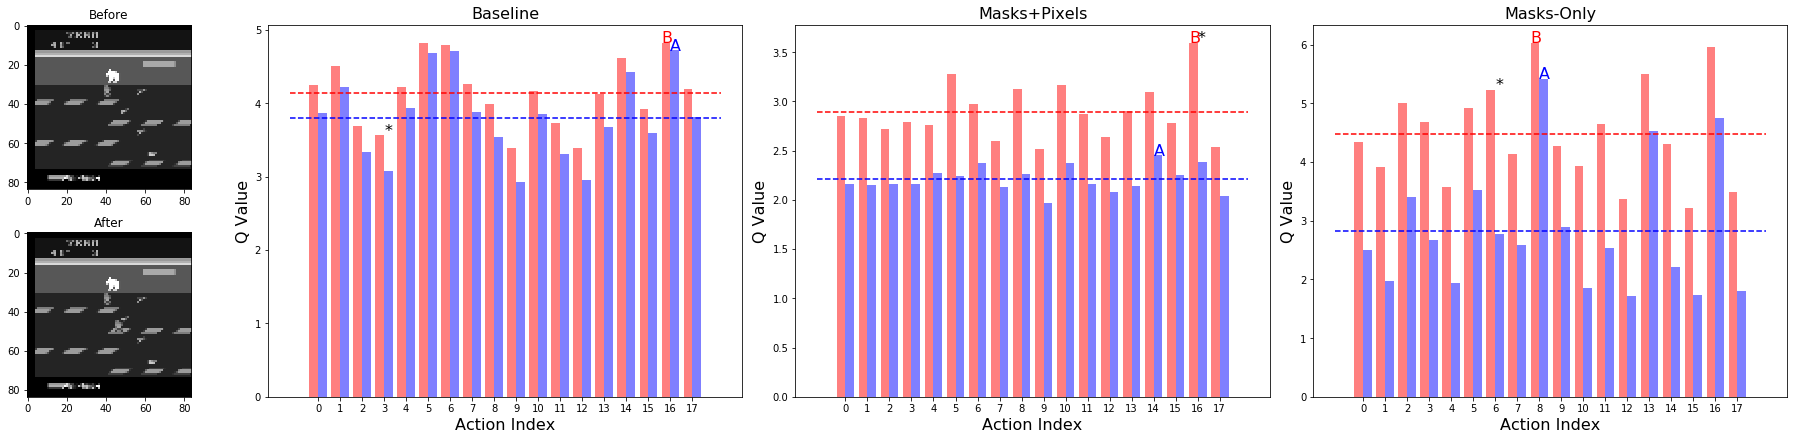

In [15]:
OBS_INDEX = 1449

player_mask_tensor, player_loc = extract_object(sample_full_color_observations, OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=0, object_index=0, return_location=True)
player_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, OBS_INDEX, baseline_model, baseline_env, player_loc)

NEW_PLAYER_LOCATION = (45, 45)

baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  player_pixels_tensor, player_mask_tensor, 0, [NEW_PLAYER_LOCATION])

evaluate_augmented_models(sample_full_color_observations, OBS_INDEX, 
                         [baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug],
                          force_text=True)
    

# A.2 Adding a completed igloo to a state without a complete igloo

For model Baseline:
Baseline mean: 5.687 | Augmented mean: 6.390 | Difference: 0.703
Max Q value diff is 1.186 for action left + fire [12]
Before action: fire [1] (Q = 6.439) | After action: fire [1] (Q = 6.701)

For model Masks+Pixels:
Baseline mean: 7.102 | Augmented mean: 6.718 | Difference: -0.384
Max Q value diff is 0.614 for action down + right [8]
Before action: down + right [8] (Q = 7.460) | After action: down + right + fire [16] (Q = 6.953)

For model Masks-Only:
Baseline mean: 0.551 | Augmented mean: 0.953 | Difference: 0.402
Max Q value diff is 0.623 for action up + right + fire [14]
Before action: down + fire [13] (Q = 1.023) | After action: up [2] (Q = 1.344)



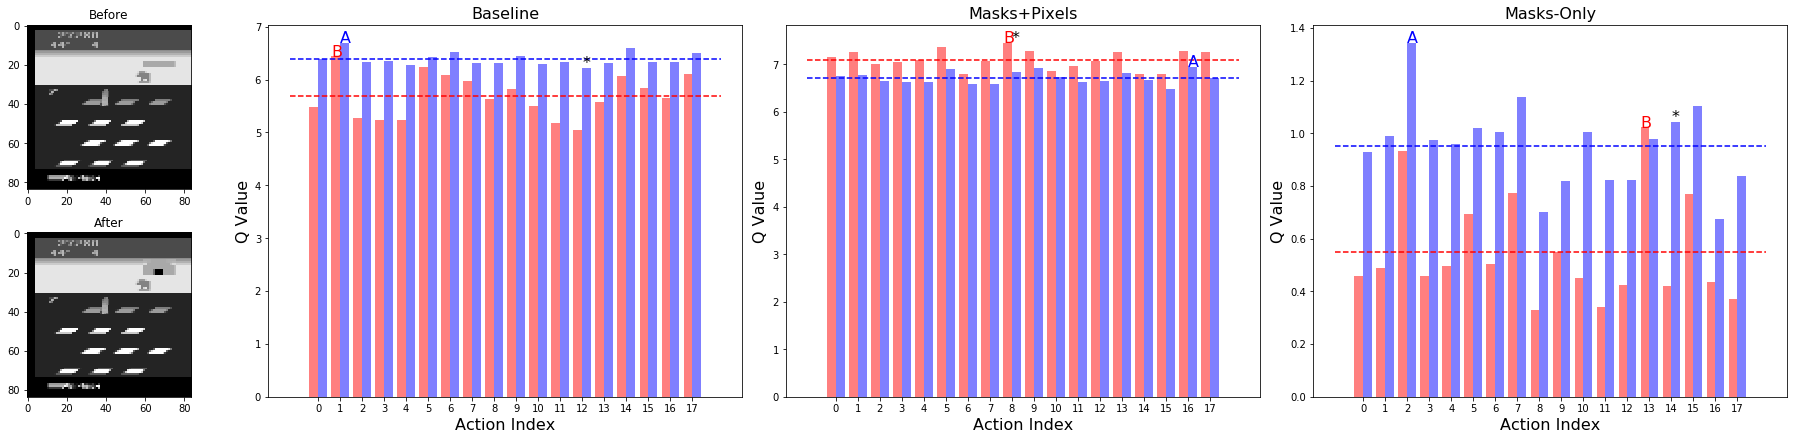

In [16]:
SRC_OBS_INDEX = 1200
DST_OBS_INEX = 2904
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 4.275 | Augmented mean: 2.840 | Difference: -1.435
Max Q value diff is 1.886 for action up + right [6]
Before action: up + right [6] (Q = 5.295) | After action: up + right [6] (Q = 3.409)

For model Masks+Pixels:
Baseline mean: 2.239 | Augmented mean: 2.649 | Difference: 0.410
Max Q value diff is 0.526 for action down + left [9]
Before action: up + right + fire [14] (Q = 2.382) | After action: down + right + fire [16] (Q = 2.749)

For model Masks-Only:
Baseline mean: 1.490 | Augmented mean: 1.798 | Difference: 0.308
Max Q value diff is 0.431 for action up [2]
Before action: down + fire [13] (Q = 1.870) | After action: down + fire [13] (Q = 2.167)



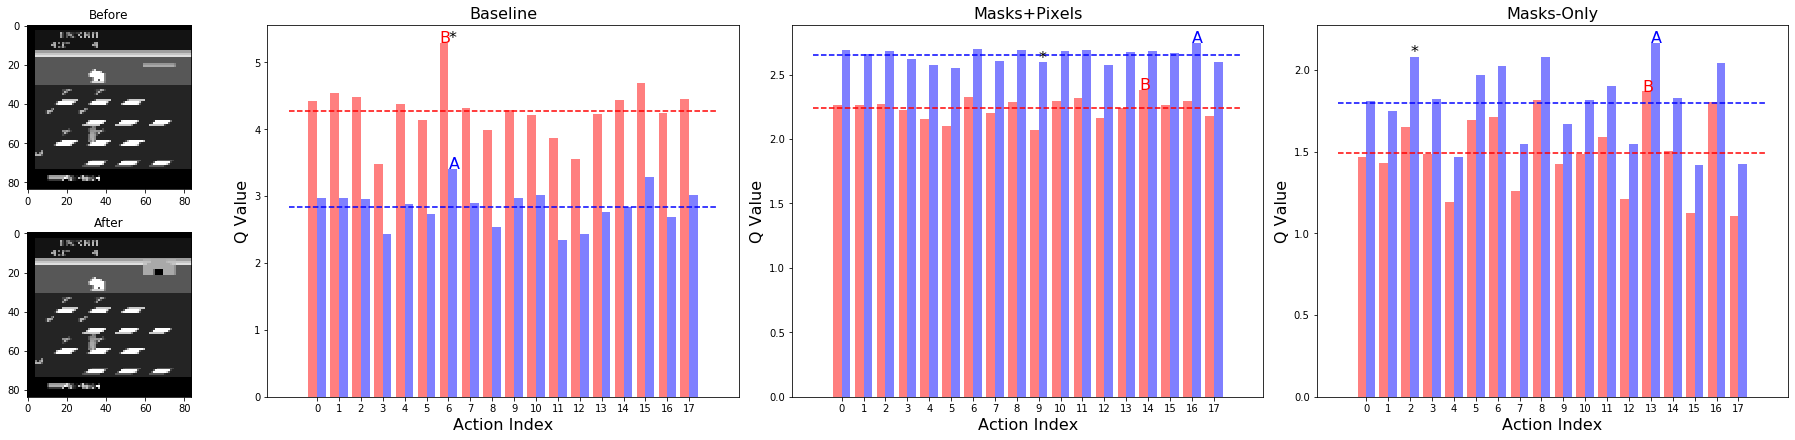

In [17]:
SRC_OBS_INDEX = 2600
DST_OBS_INEX = 2100
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.542 | Difference: 0.585
Max Q value diff is 1.071 for action down + left [9]
Before action: down + left + fire [17] (Q = 5.122) | After action: down [5] (Q = 5.679)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.700 | Difference: -0.223
Max Q value diff is 0.454 for action up + right + fire [14]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 5.901)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.651 | Difference: -1.047
Max Q value diff is 1.324 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right [8] (Q = 6.938)



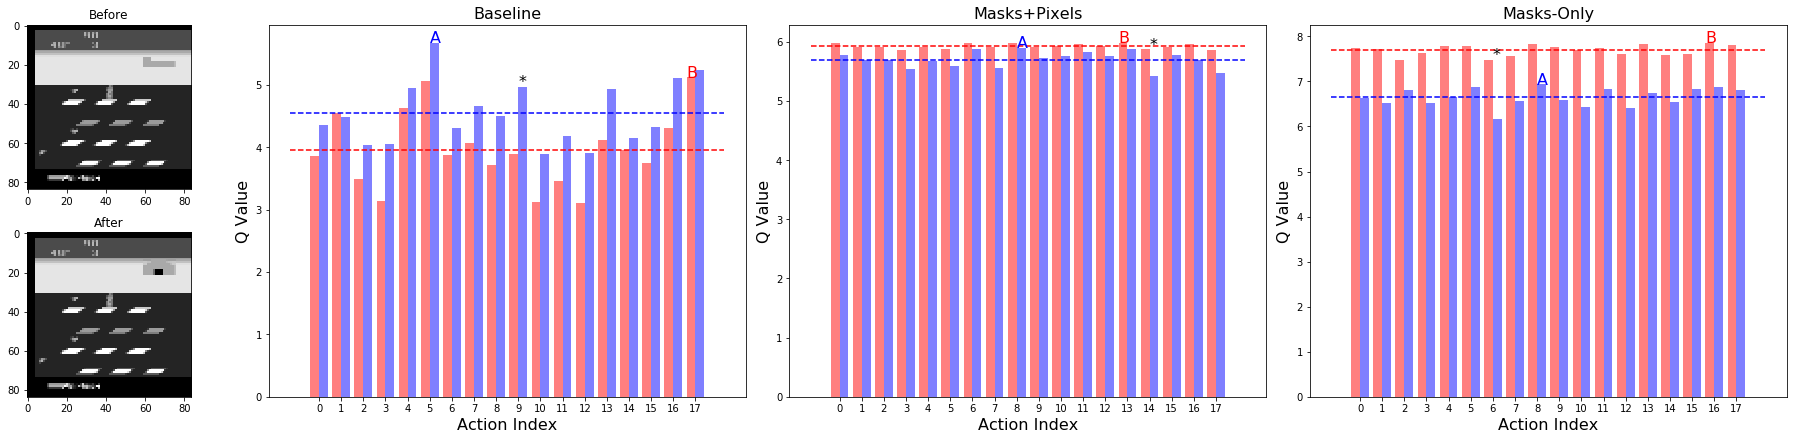

In [18]:
SRC_OBS_INDEX = 450
DST_OBS_INEX = 94
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

# A.3 Adding many of a particular good animal

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.458 | Difference: -0.498
Max Q value diff is 1.650 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + right + fire [16] (Q = 4.072)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 6.759 | Difference: 0.836
Max Q value diff is 1.381 for action up + fire [10]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 7.337)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.189 | Difference: -0.509
Max Q value diff is 1.080 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 7.770)



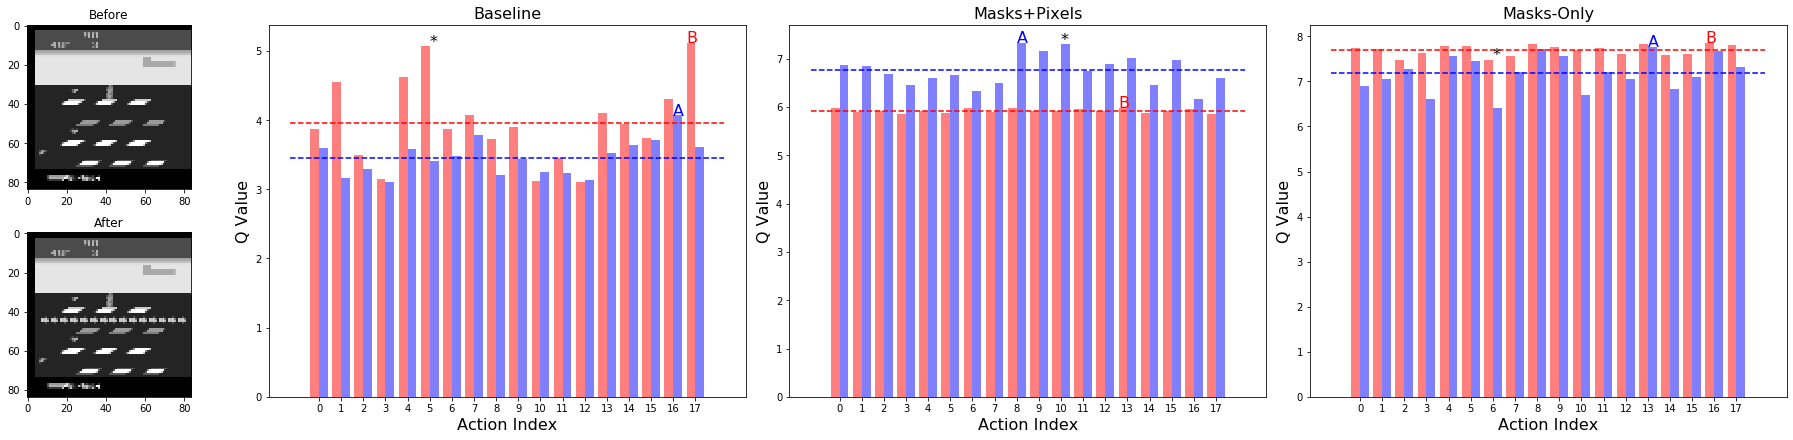

In [19]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 94
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 6.536 | Augmented mean: 6.384 | Difference: -0.152
Max Q value diff is 0.299 for action down + right + fire [16]
Before action: up + right + fire [14] (Q = 6.826) | After action: up + right + fire [14] (Q = 6.757)

For model Masks+Pixels:
Baseline mean: 5.388 | Augmented mean: 8.221 | Difference: 2.833
Max Q value diff is 4.427 for action down + left + fire [17]
Before action: up + fire [10] (Q = 6.622) | After action: down [5] (Q = 8.407)

For model Masks-Only:
Baseline mean: 6.465 | Augmented mean: 7.812 | Difference: 1.347
Max Q value diff is 1.561 for action down + fire [13]
Before action: up [2] (Q = 6.540) | After action: left [4] (Q = 7.951)



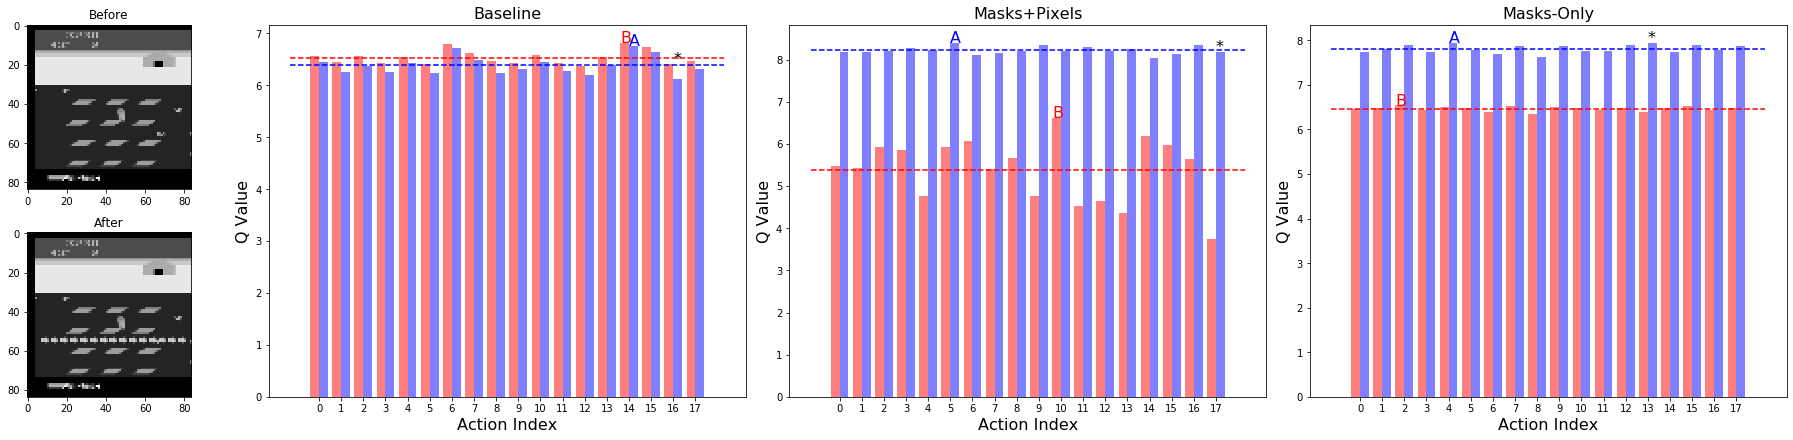

In [20]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 875
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.532 | Difference: -0.125
Max Q value diff is 0.517 for action down [5]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.066)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 1.174 | Difference: -2.074
Max Q value diff is 2.466 for action down + left [9]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 2.537)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.371 | Difference: -1.789
Max Q value diff is 2.736 for action up + fire [10]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.344)



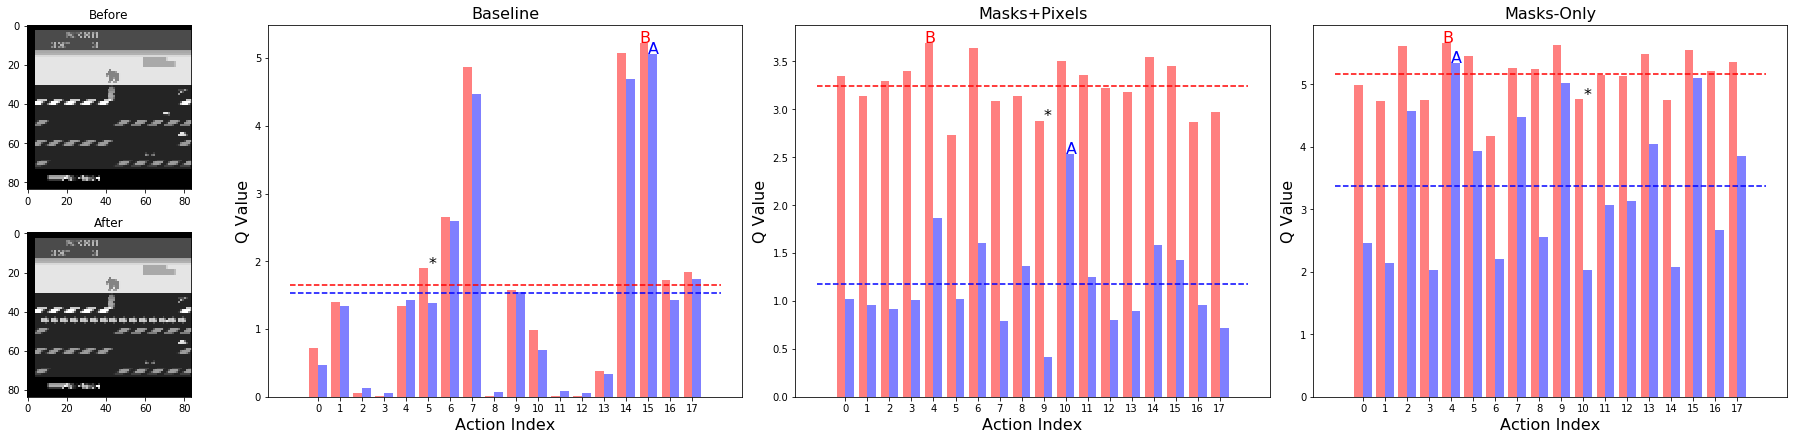

In [21]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 2.273 | Difference: 0.616
Max Q value diff is 1.354 for action noop [0]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.448)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.214 | Difference: -1.034
Max Q value diff is 1.303 for action right [3]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 3.264)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.150 | Difference: -1.011
Max Q value diff is 1.976 for action up + fire [10]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.855)



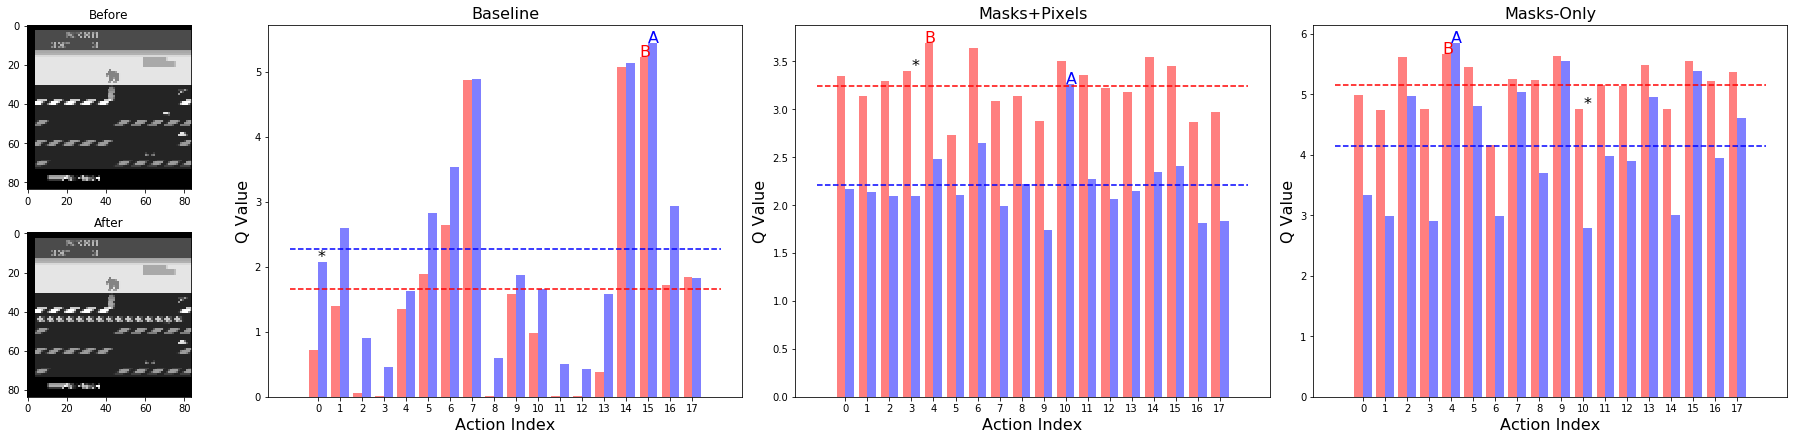

In [22]:
SRC_OBS_INDEX = 330
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, 5 + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  fish_pixels_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

# A.4 Same but with a bad animal

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 2.073 | Difference: -1.884
Max Q value diff is 2.935 for action down + left + fire [17]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + right + fire [14] (Q = 2.357)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 3.862 | Difference: -2.061
Max Q value diff is 2.252 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 4.073)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.376 | Difference: -1.322
Max Q value diff is 1.528 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 6.673)



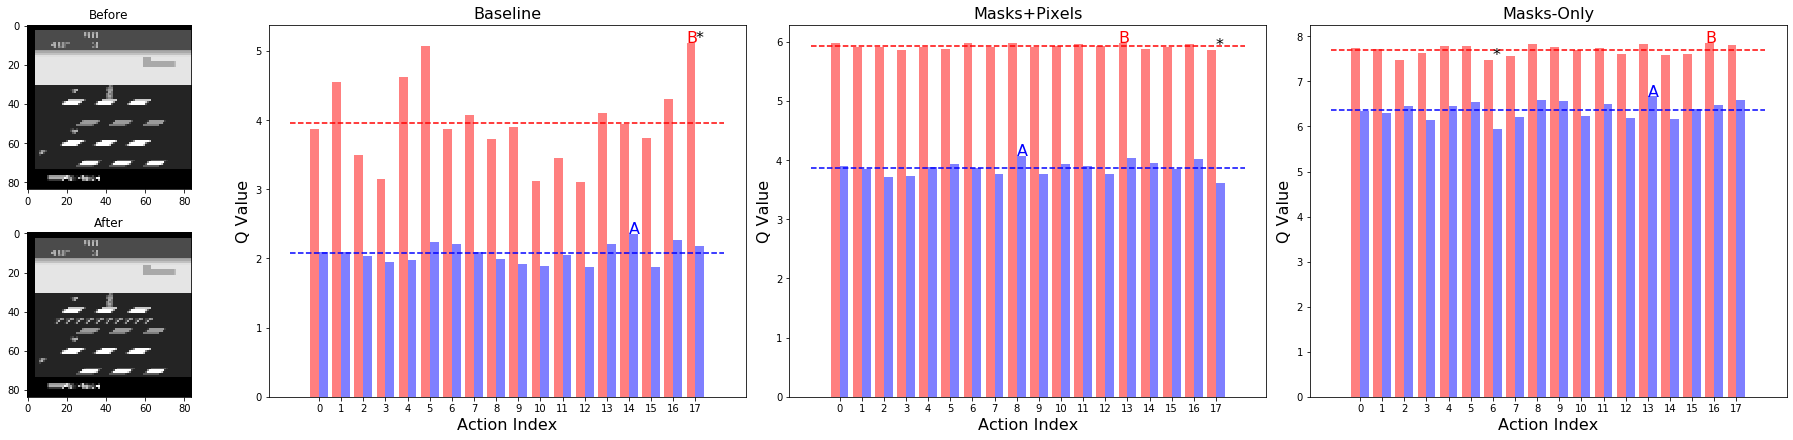

In [23]:
SRC_OBS_INDEX = 325
DST_OBS_INEX = 94
CHANNEL_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, bad_animal_loc[1].start + 5 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 6.069 | Difference: 2.113
Max Q value diff is 2.650 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: down [5] (Q = 6.973)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 4.879 | Difference: -1.044
Max Q value diff is 1.235 for action down + right + fire [16]
Before action: down + fire [13] (Q = 5.989) | After action: down + fire [13] (Q = 5.031)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.355 | Difference: -1.343
Max Q value diff is 1.547 for action left [4]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right [8] (Q = 6.653)



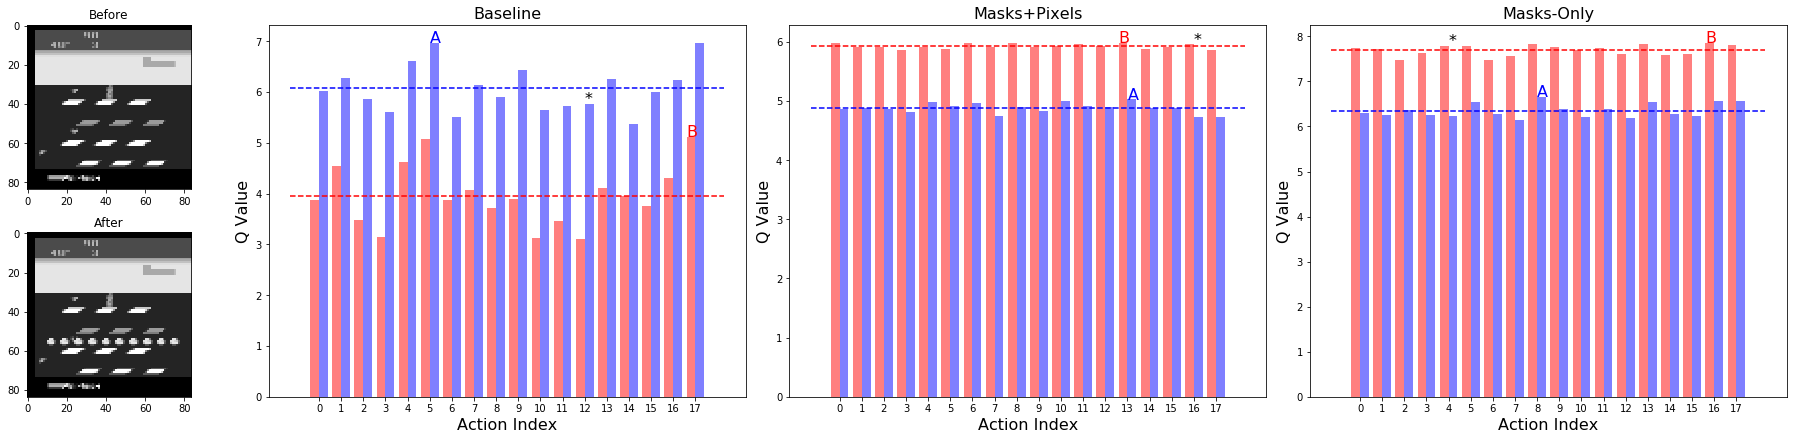

In [24]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 2.712 | Difference: -1.245
Max Q value diff is 2.959 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + right + fire [14] (Q = 3.263)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 2.989 | Difference: -2.934
Max Q value diff is 3.034 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: left [4] (Q = 3.121)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 4.045 | Difference: -3.653
Max Q value diff is 4.010 for action up + fire [10]
Before action: down + right + fire [16] (Q = 7.864) | After action: up [2] (Q = 4.427)



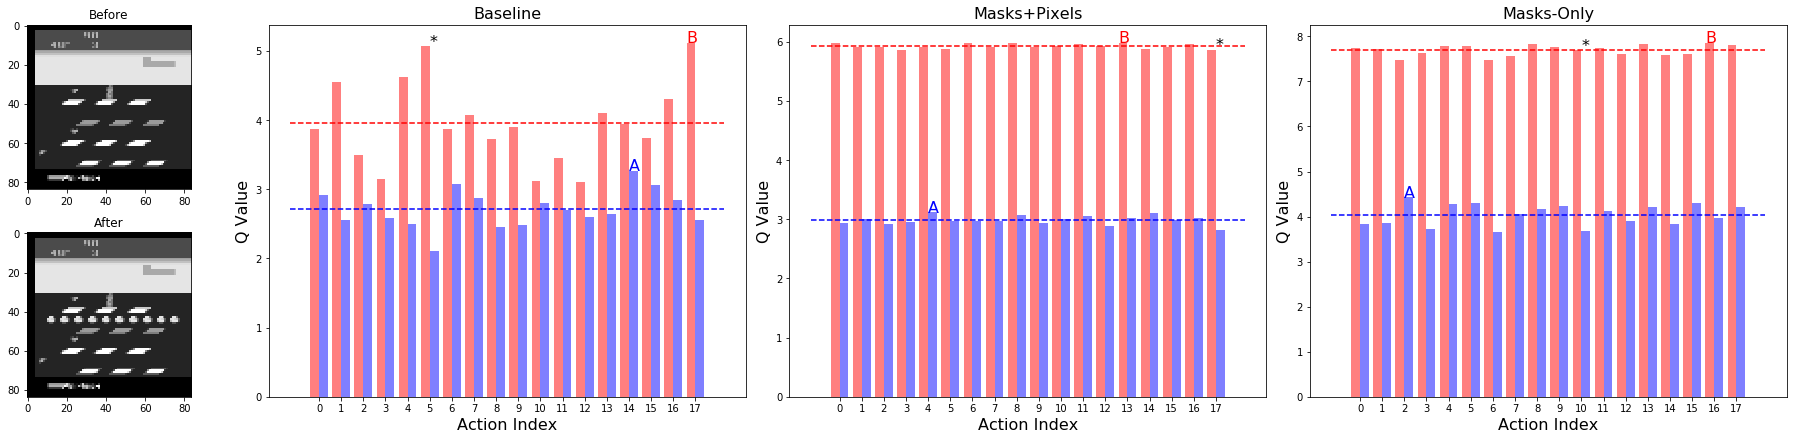

In [25]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.841 | Difference: 0.184
Max Q value diff is 0.736 for action fire [1]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.456)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.144 | Difference: -1.104
Max Q value diff is 1.475 for action left [4]
Before action: left [4] (Q = 3.697) | After action: up + right + fire [14] (Q = 2.331)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.633 | Difference: -1.528
Max Q value diff is 2.015 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: up [2] (Q = 4.511)



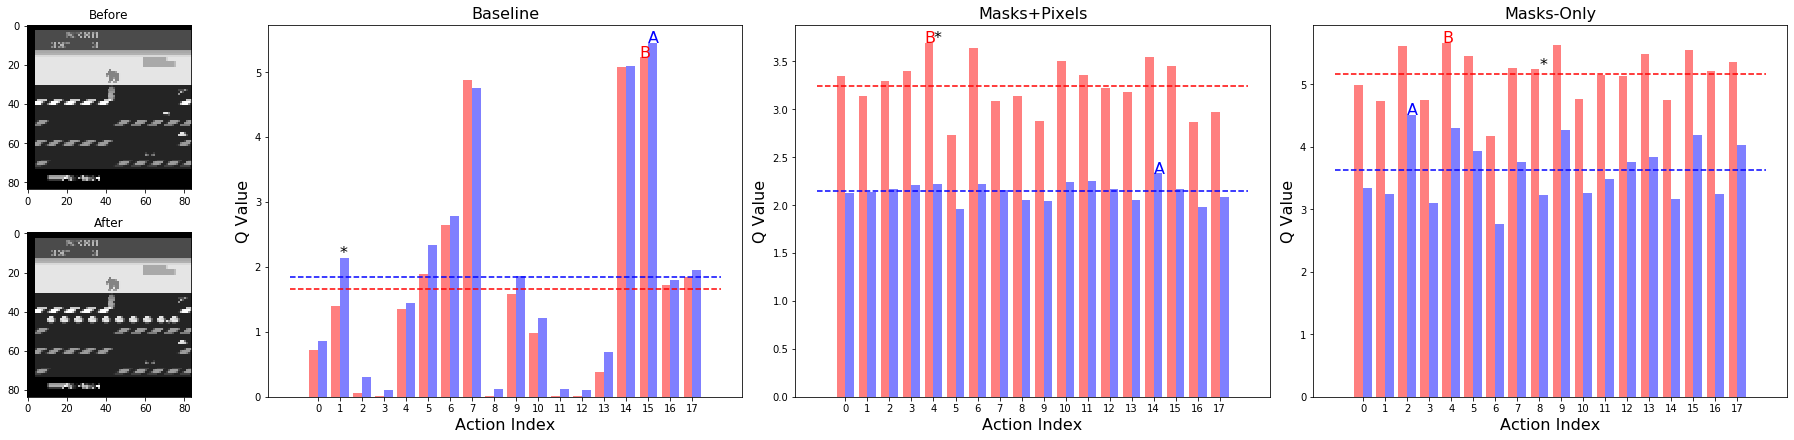

In [26]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 1112
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

# B -- Same shape, new color
* New color in this case means new intensity since grayscale.
* Can probaly repeat the same experiments as above but just changing the pixels

# B.1 Another player, new color

For model Baseline:
Baseline mean: 4.134 | Augmented mean: 2.604 | Difference: -1.530
Max Q value diff is 2.405 for action right + fire [11]
Before action: down + right + fire [16] (Q = 4.825) | After action: up + right [6] (Q = 4.890)

For model Masks+Pixels:
Baseline mean: 2.892 | Augmented mean: 2.300 | Difference: -0.592
Max Q value diff is 1.136 for action down + right + fire [16]
Before action: down + right + fire [16] (Q = 3.598) | After action: up + right + fire [14] (Q = 2.535)

For model Masks-Only:
Baseline mean: 4.474 | Augmented mean: 2.826 | Difference: -1.649
Max Q value diff is 2.448 for action up + right [6]
Before action: down + right [8] (Q = 6.038) | After action: down + right [8] (Q = 5.419)



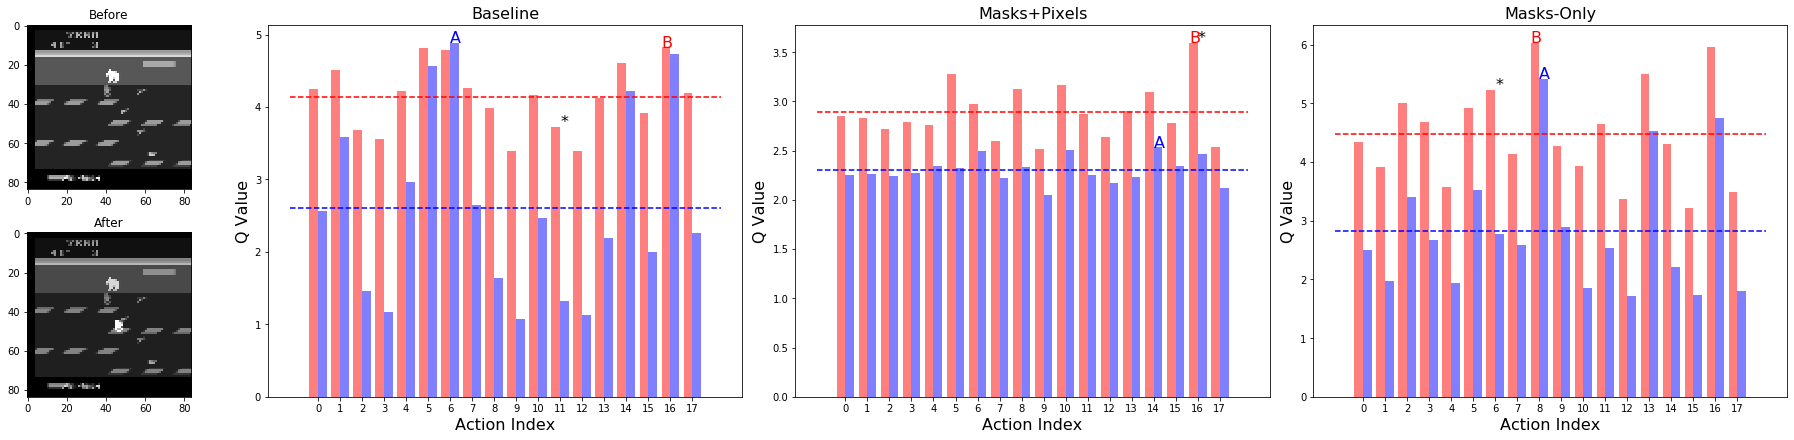

In [45]:
OBS_INDEX = 1449
CHANEL_INDEX = 0

player_mask_tensor, player_loc = extract_object(sample_full_color_observations, OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANEL_INDEX, object_index=0, return_location=True)
player_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, OBS_INDEX, baseline_model, baseline_env, player_loc)

lightened_player_pixels_tensor = change_intensity(player_pixels_tensor, multiplicative=3.0)

# plot_tensors(player_mask_tensor, player_pixels_tensor, lightened_player_pixels_tensor, norm=True)

NEW_PLAYER_LOCATION = (45, 45)

baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_player_pixels_tensor, player_mask_tensor, CHANEL_INDEX, [NEW_PLAYER_LOCATION])

evaluate_augmented_models(sample_full_color_observations, OBS_INDEX, 
                         [baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 4.134 | Augmented mean: 3.902 | Difference: -0.233
Max Q value diff is 0.379 for action down + left [9]
Before action: down + right + fire [16] (Q = 4.825) | After action: down + right + fire [16] (Q = 4.747)

For model Masks+Pixels:
Baseline mean: 2.892 | Augmented mean: 2.183 | Difference: -0.709
Max Q value diff is 1.238 for action down + right + fire [16]
Before action: down + right + fire [16] (Q = 3.598) | After action: up + right + fire [14] (Q = 2.434)

For model Masks-Only:
Baseline mean: 4.474 | Augmented mean: 2.826 | Difference: -1.649
Max Q value diff is 2.448 for action up + right [6]
Before action: down + right [8] (Q = 6.038) | After action: down + right [8] (Q = 5.419)



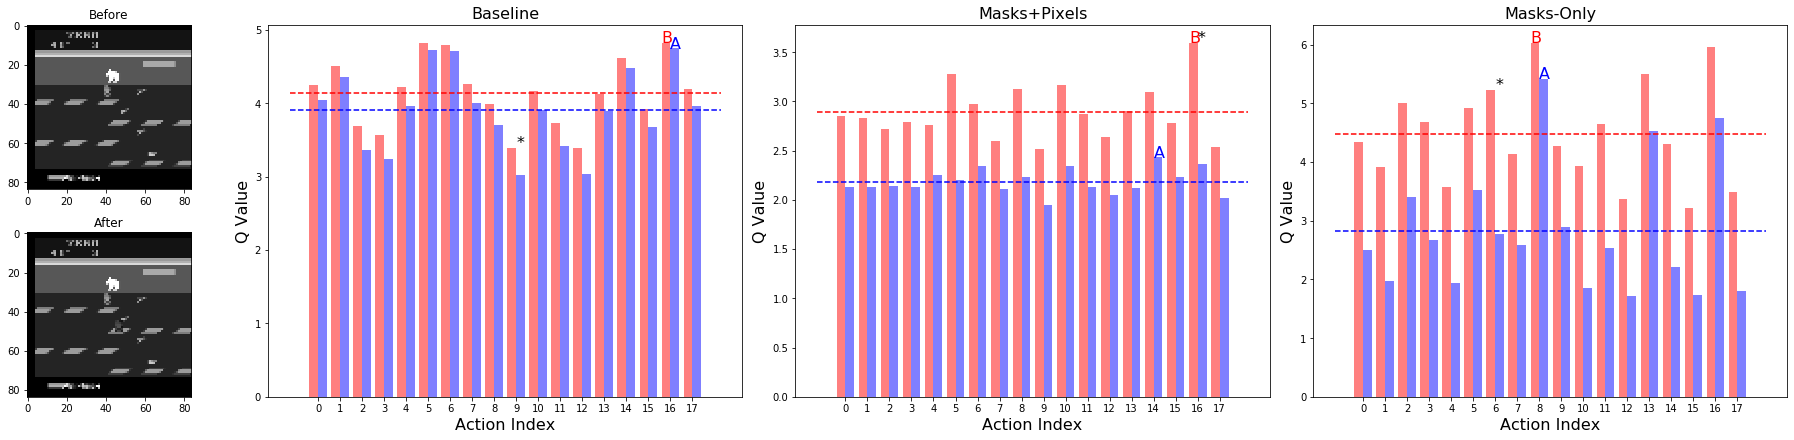

In [46]:
OBS_INDEX = 1449
CHANEL_INDEX = 0

player_mask_tensor, player_loc = extract_object(sample_full_color_observations, OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANEL_INDEX, object_index=0, return_location=True)
player_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, OBS_INDEX, baseline_model, baseline_env, player_loc)

darkened_player_pixels_tensor = change_intensity(player_pixels_tensor, multiplicative=0.5)

# plot_tensors(player_mask_tensor, player_pixels_tensor, darkened_player_pixels_tensor, norm=True)

NEW_PLAYER_LOCATION = (45, 45)

baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_player_pixels_tensor, player_mask_tensor, CHANEL_INDEX, [NEW_PLAYER_LOCATION])

evaluate_augmented_models(sample_full_color_observations, OBS_INDEX, 
                         [baseline_player_aug, masks_and_pixels_player_aug, masks_only_player_aug],
                          force_text=True)
    

# B.2 Adding a completed igloo to a state without a complete igloo

For model Baseline:
Baseline mean: 4.275 | Augmented mean: 2.870 | Difference: -1.405
Max Q value diff is 2.309 for action up + right [6]
Before action: up + right [6] (Q = 5.295) | After action: up + left + fire [15] (Q = 3.163)

For model Masks+Pixels:
Baseline mean: 2.239 | Augmented mean: 2.770 | Difference: 0.531
Max Q value diff is 0.698 for action down + left [9]
Before action: up + right + fire [14] (Q = 2.382) | After action: down + right + fire [16] (Q = 2.923)

For model Masks-Only:
Baseline mean: 1.490 | Augmented mean: 1.798 | Difference: 0.308
Max Q value diff is 0.431 for action up [2]
Before action: down + fire [13] (Q = 1.870) | After action: down + fire [13] (Q = 2.167)



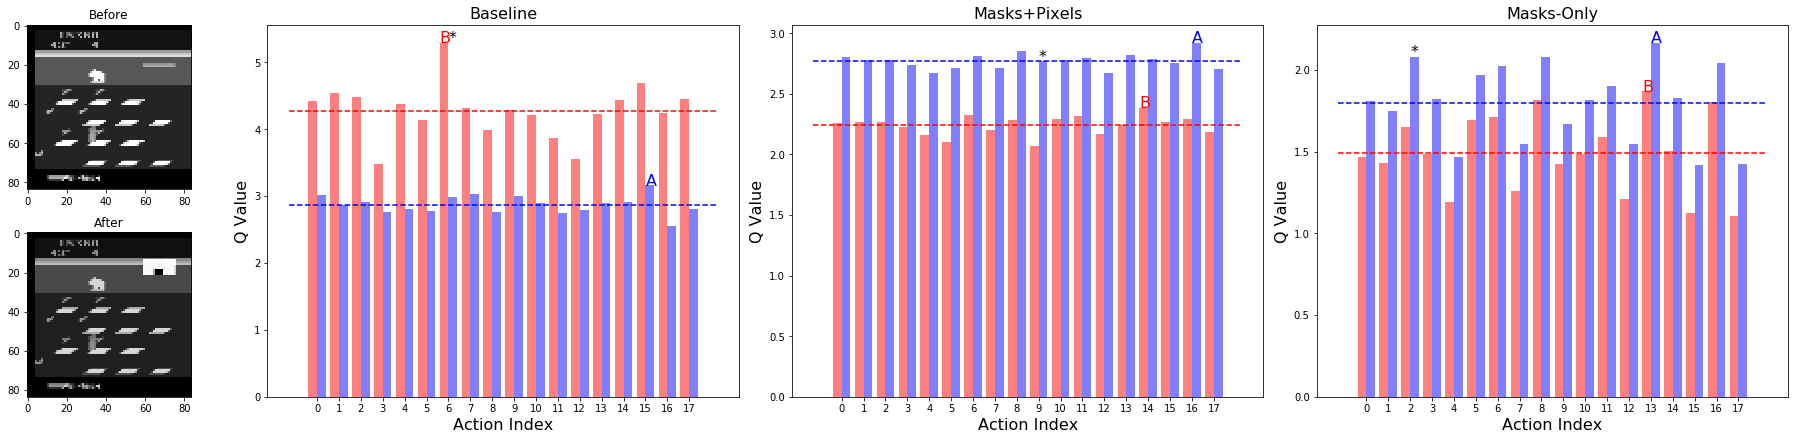

In [52]:
SRC_OBS_INDEX = 2600
DST_OBS_INEX = 2100
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

lightened_igloo_pixels_tensor = change_intensity(igloo_pixels_tensor, multiplicative=1.75)


# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 4.275 | Augmented mean: 3.293 | Difference: -0.983
Max Q value diff is 1.373 for action up + left + fire [15]
Before action: up + right [6] (Q = 5.295) | After action: up + right [6] (Q = 3.969)

For model Masks+Pixels:
Baseline mean: 2.239 | Augmented mean: 2.643 | Difference: 0.404
Max Q value diff is 0.483 for action down + left [9]
Before action: up + right + fire [14] (Q = 2.382) | After action: down + right + fire [16] (Q = 2.711)

For model Masks-Only:
Baseline mean: 1.490 | Augmented mean: 1.798 | Difference: 0.308
Max Q value diff is 0.431 for action up [2]
Before action: down + fire [13] (Q = 1.870) | After action: down + fire [13] (Q = 2.167)



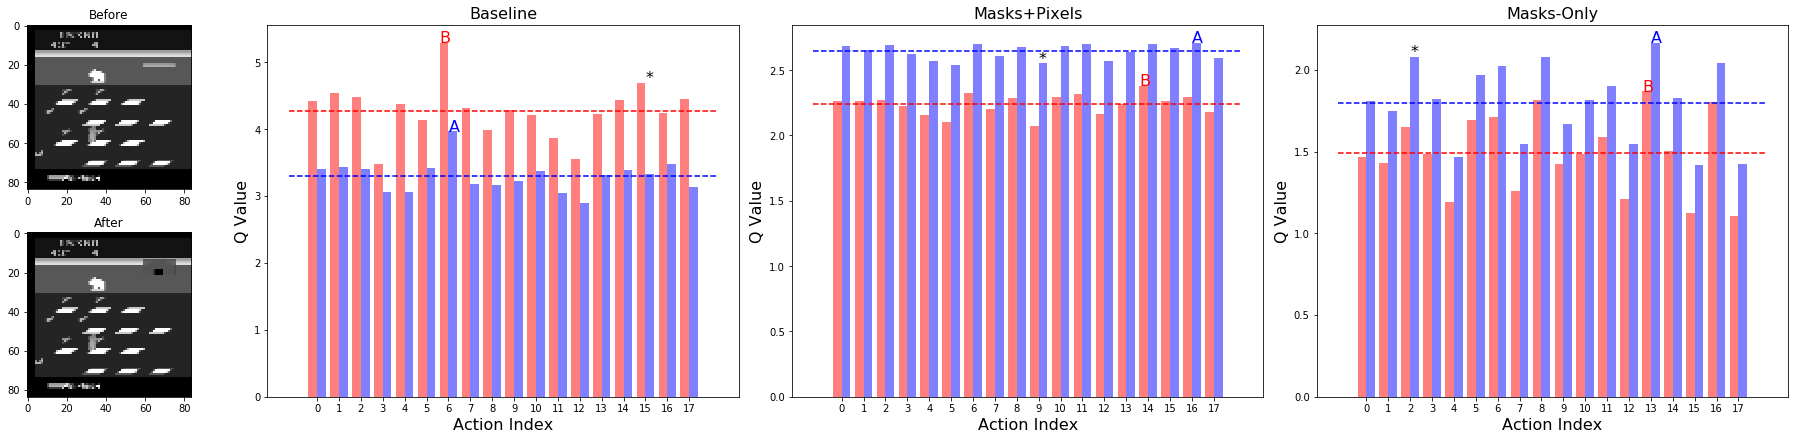

In [54]:
SRC_OBS_INDEX = 2600
DST_OBS_INEX = 2100
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)

darkened_igloo_pixels_tensor = change_intensity(igloo_pixels_tensor, multiplicative=0.5)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor, darkened_igloo_pixels_tensor, norm=True)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.152 | Difference: 0.196
Max Q value diff is 0.804 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: left [4] (Q = 4.589)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.636 | Difference: -0.287
Max Q value diff is 0.505 for action up + right + fire [14]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 5.843)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.651 | Difference: -1.047
Max Q value diff is 1.324 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right [8] (Q = 6.938)



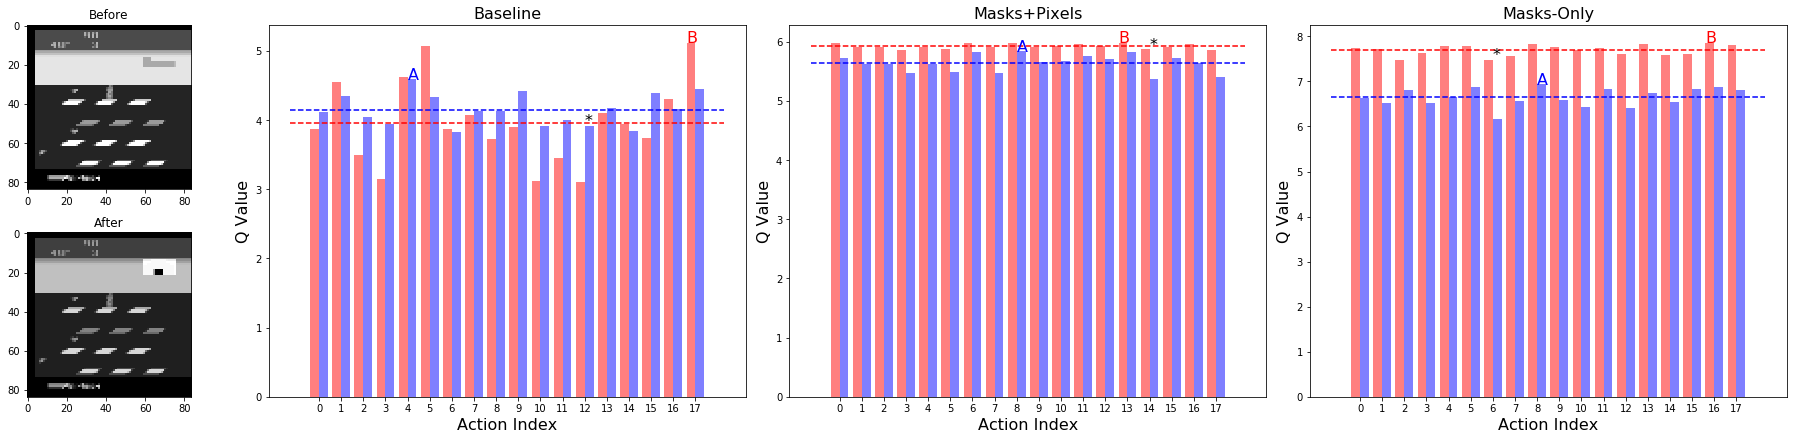

In [55]:
SRC_OBS_INDEX = 450
DST_OBS_INEX = 94
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)
lightened_igloo_pixels_tensor = change_intensity(igloo_pixels_tensor, multiplicative=1.75)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 2.200 | Difference: -1.756
Max Q value diff is 2.678 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 2.504)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.804 | Difference: -0.119
Max Q value diff is 0.337 for action up + right + fire [14]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 6.007)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.651 | Difference: -1.047
Max Q value diff is 1.324 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right [8] (Q = 6.938)



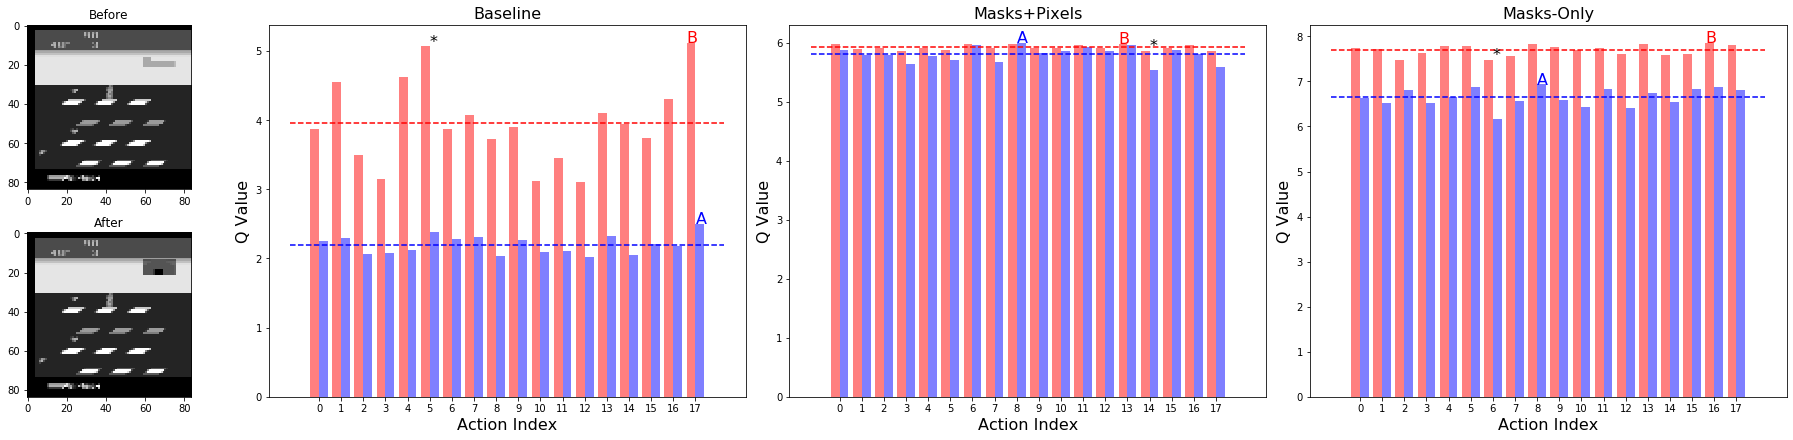

In [56]:
SRC_OBS_INDEX = 450
DST_OBS_INEX = 94
CHANNEL_INDEX = 7

igloo_mask_tensor, igloo_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
igloo_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, igloo_loc)
darkened_igloo_pixels_tensor = change_intensity(igloo_pixels_tensor, multiplicative=0.5)

# plot_tensors(igloo_mask_tensor, igloo_pixels_tensor)

NEW_IGLOO_LOCATION = (igloo_loc[0].start, igloo_loc[1].start)

baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_igloo_pixels_tensor, igloo_mask_tensor, CHANNEL_INDEX, [NEW_IGLOO_LOCATION])

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_igloo_aug, masks_and_pixels_igloo_aug, masks_only_igloo_aug],
                          force_text=True)
    

# B.3 Adding many of a particular good animal

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 5.737 | Difference: 1.780
Max Q value diff is 2.429 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + left [7] (Q = 6.110)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.822 | Difference: -0.101
Max Q value diff is 0.914 for action down + right + fire [16]
Before action: down + fire [13] (Q = 5.989) | After action: up + fire [10] (Q = 6.491)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.189 | Difference: -0.509
Max Q value diff is 1.080 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 7.770)



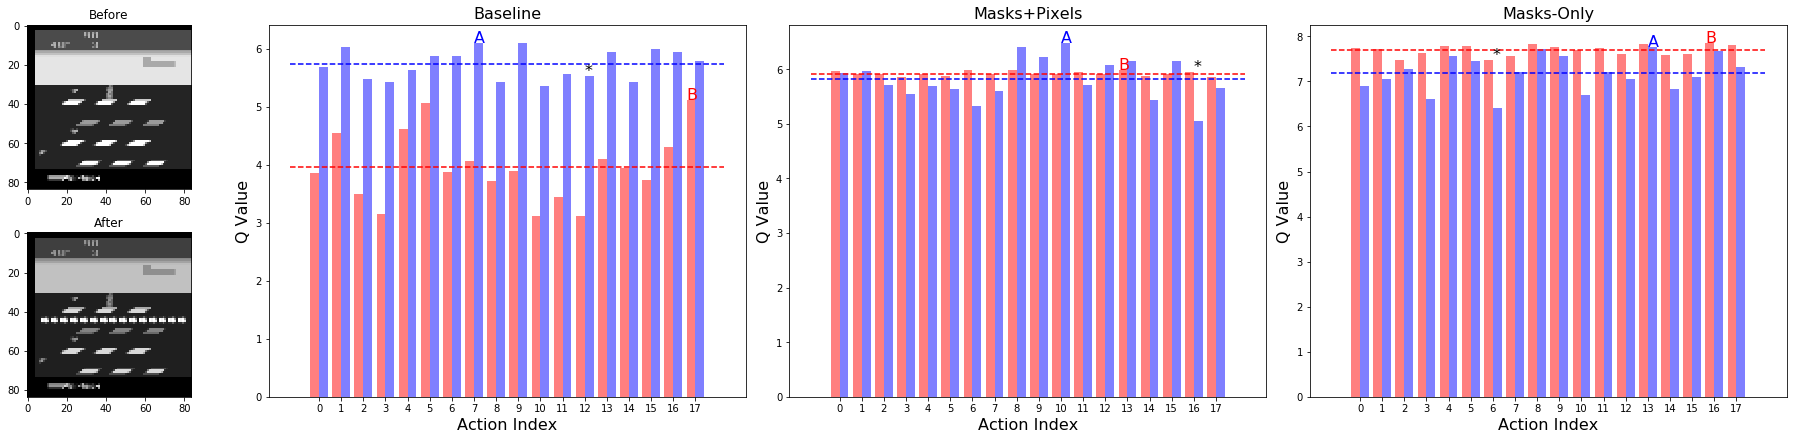

In [62]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 94
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor, lightened_fish_tensor, norm=True)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.413 | Difference: -0.544
Max Q value diff is 0.896 for action left [4]
Before action: down + left + fire [17] (Q = 5.122) | After action: down [5] (Q = 4.268)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 7.095 | Difference: 1.172
Max Q value diff is 1.659 for action down + right [8]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 7.639)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.189 | Difference: -0.509
Max Q value diff is 1.080 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 7.770)



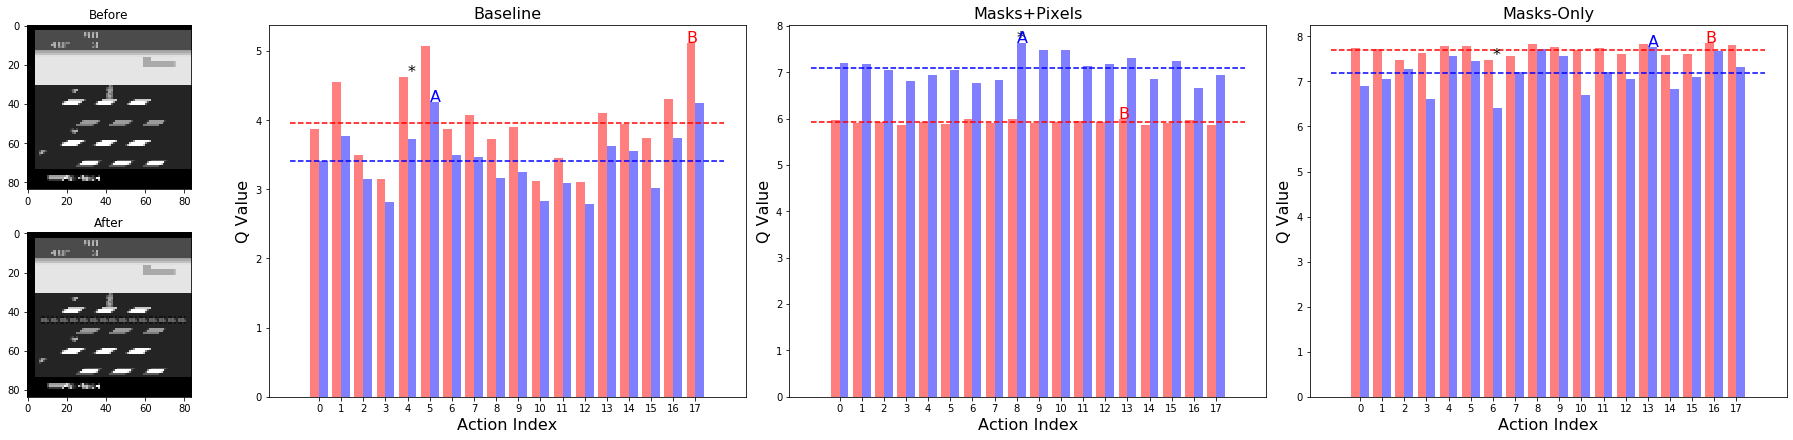

In [65]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 94
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)

darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor, lightened_fish_tensor, norm=True)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 6.536 | Augmented mean: 6.157 | Difference: -0.379
Max Q value diff is 0.772 for action down + right + fire [16]
Before action: up + right + fire [14] (Q = 6.826) | After action: up + right + fire [14] (Q = 6.623)

For model Masks+Pixels:
Baseline mean: 5.388 | Augmented mean: 8.132 | Difference: 2.743
Max Q value diff is 4.347 for action down + left + fire [17]
Before action: up + fire [10] (Q = 6.622) | After action: down [5] (Q = 8.271)

For model Masks-Only:
Baseline mean: 6.465 | Augmented mean: 7.812 | Difference: 1.347
Max Q value diff is 1.561 for action down + fire [13]
Before action: up [2] (Q = 6.540) | After action: left [4] (Q = 7.951)



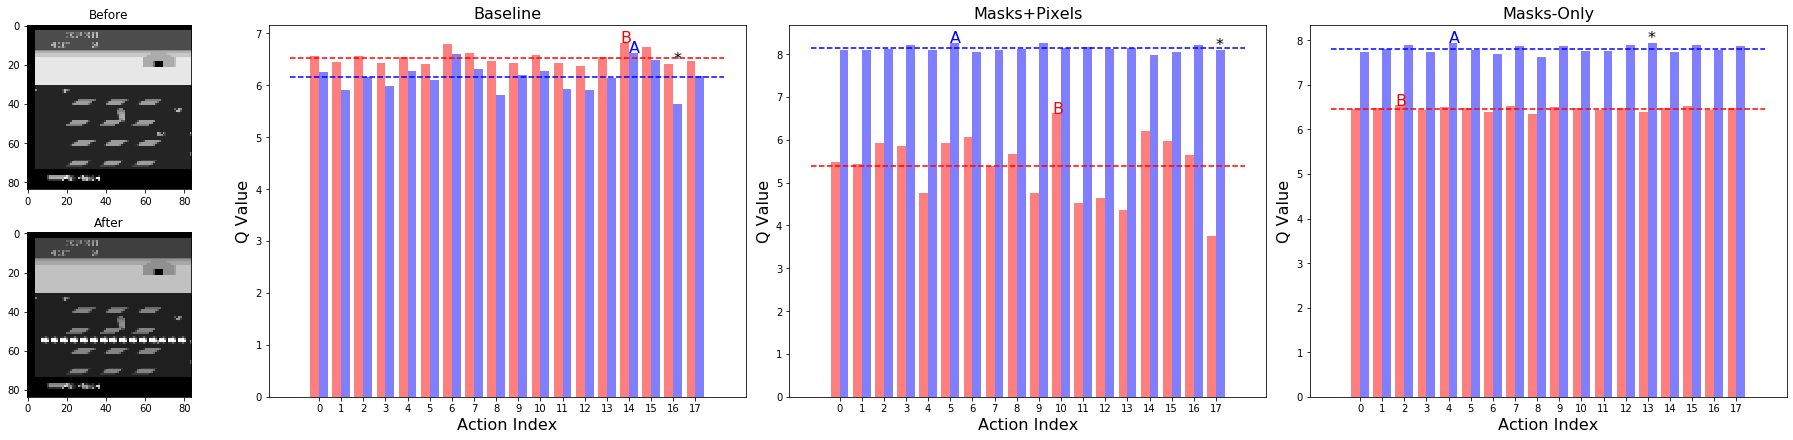

In [64]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 875
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 6.536 | Augmented mean: 6.188 | Difference: -0.349
Max Q value diff is 0.544 for action down + right + fire [16]
Before action: up + right + fire [14] (Q = 6.826) | After action: up + right + fire [14] (Q = 6.723)

For model Masks+Pixels:
Baseline mean: 5.388 | Augmented mean: 8.306 | Difference: 2.918
Max Q value diff is 4.510 for action down + left + fire [17]
Before action: up + fire [10] (Q = 6.622) | After action: down [5] (Q = 8.480)

For model Masks-Only:
Baseline mean: 6.465 | Augmented mean: 7.812 | Difference: 1.347
Max Q value diff is 1.561 for action down + fire [13]
Before action: up [2] (Q = 6.540) | After action: left [4] (Q = 7.951)



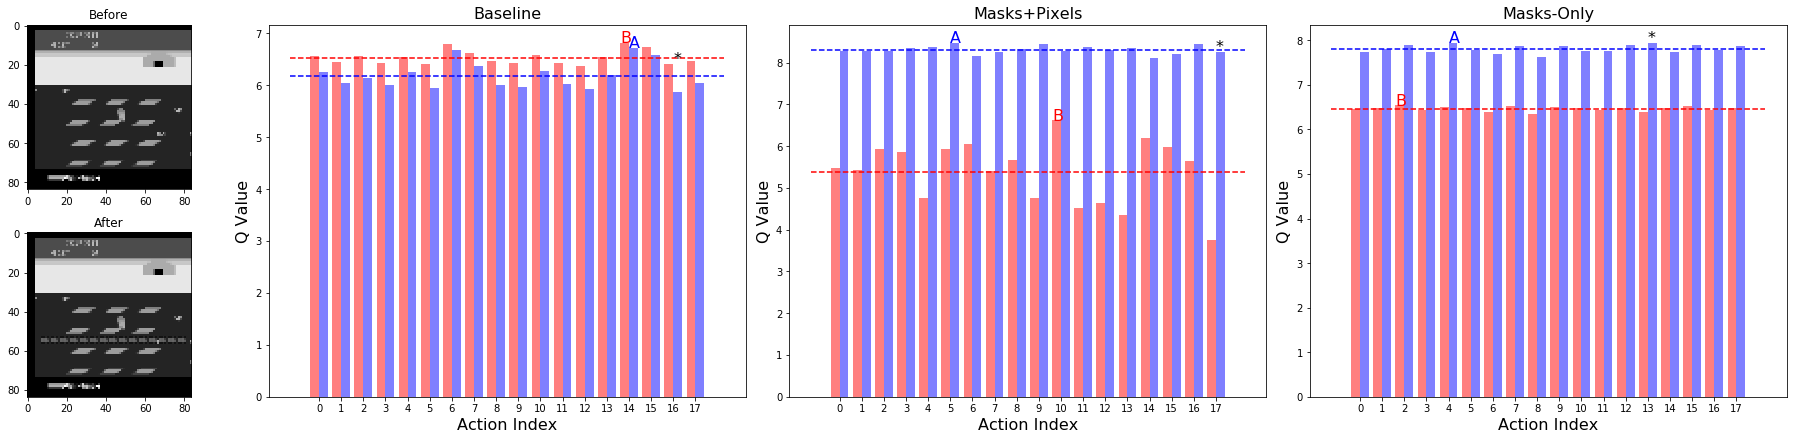

In [66]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 875
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)

# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.414 | Difference: -0.243
Max Q value diff is 3.447 for action up + right + fire [14]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 3.013)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 1.260 | Difference: -1.988
Max Q value diff is 2.480 for action down + left [9]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 2.778)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.371 | Difference: -1.789
Max Q value diff is 2.736 for action up + fire [10]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.344)



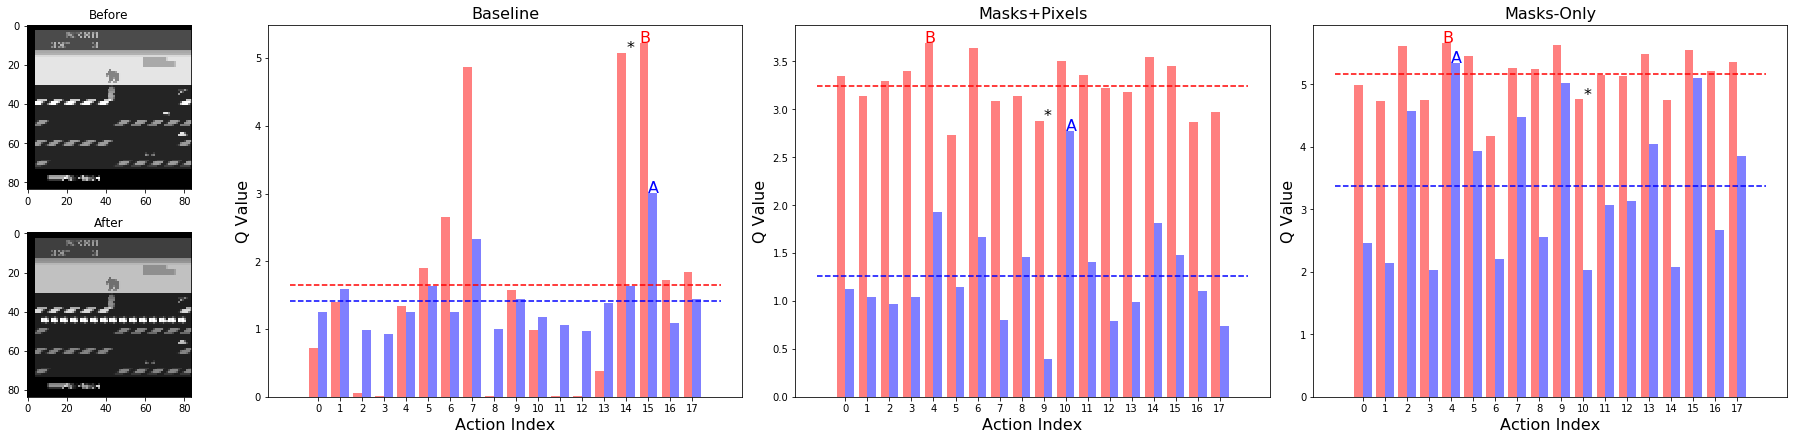

In [69]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)
# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.721 | Difference: 0.064
Max Q value diff is 0.679 for action up + right [6]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + right + fire [14] (Q = 5.314)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 1.239 | Difference: -2.009
Max Q value diff is 2.447 for action down + left [9]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 2.640)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.371 | Difference: -1.789
Max Q value diff is 2.736 for action up + fire [10]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.344)



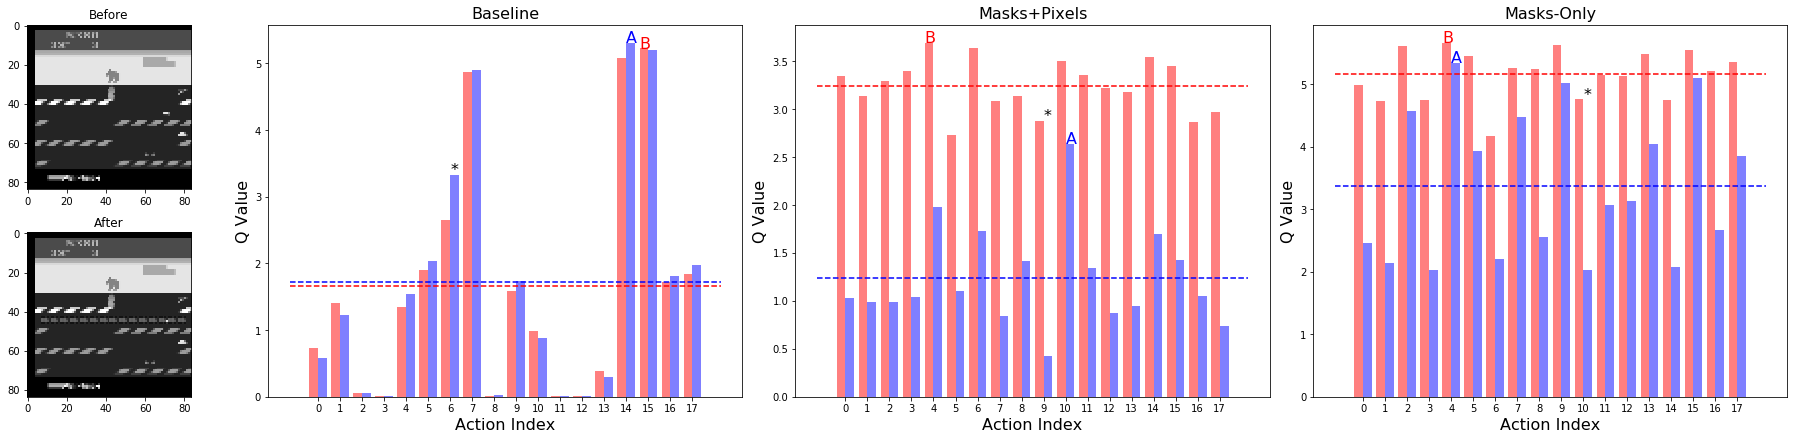

In [70]:
SRC_OBS_INDEX = 310
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)
# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start - 10, fish_loc[1].start + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 2.328 | Difference: 0.671
Max Q value diff is 1.674 for action down + fire [13]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.526)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.464 | Difference: -0.784
Max Q value diff is 1.024 for action left [4]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 3.427)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.150 | Difference: -1.011
Max Q value diff is 1.976 for action up + fire [10]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.855)



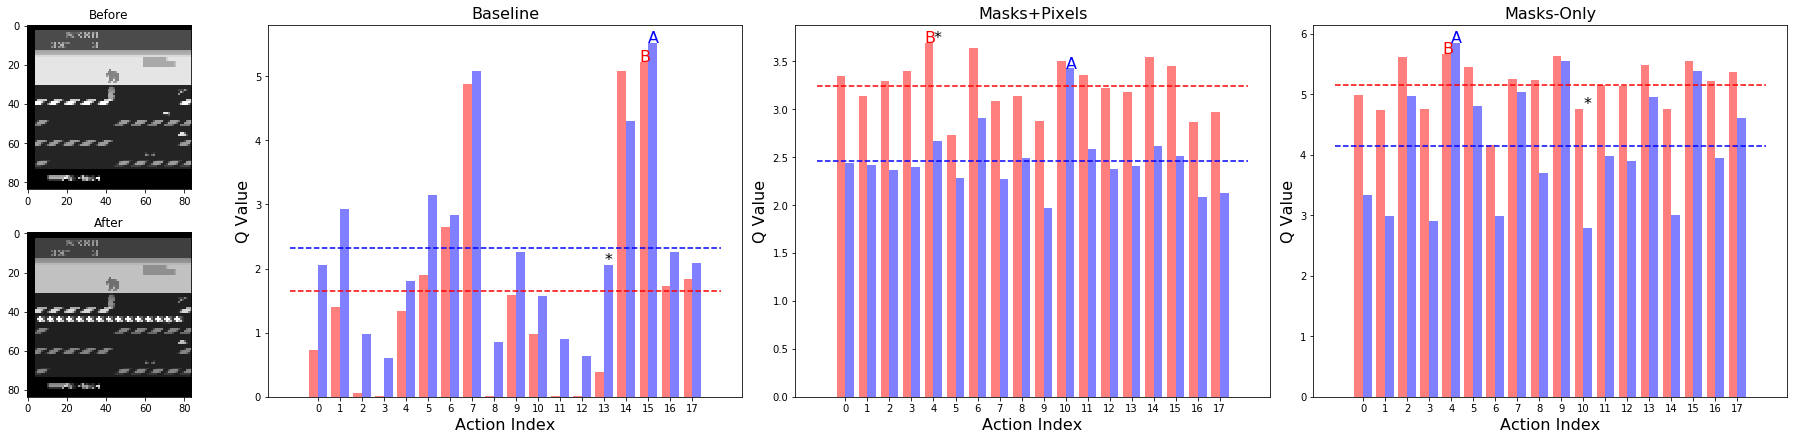

In [71]:
SRC_OBS_INDEX = 330
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)
# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, 5 + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.810 | Difference: 0.153
Max Q value diff is 0.743 for action up + right [6]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.432)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.096 | Difference: -1.152
Max Q value diff is 1.465 for action right [3]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 3.160)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.150 | Difference: -1.011
Max Q value diff is 1.976 for action up + fire [10]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.855)



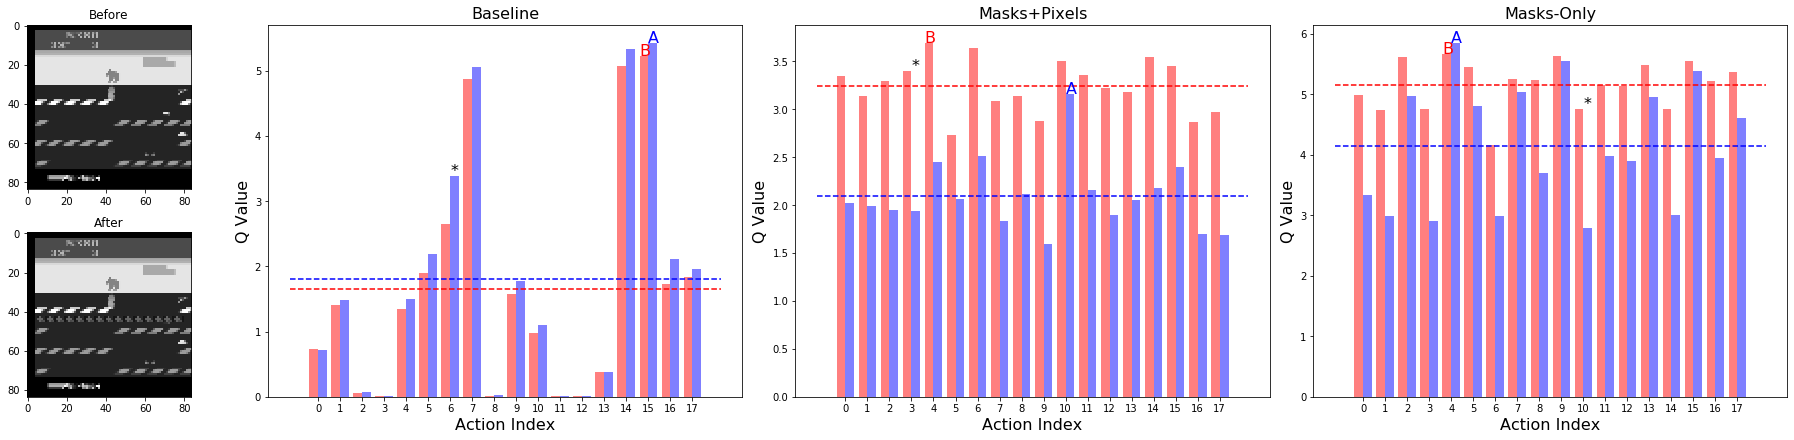

In [72]:
SRC_OBS_INDEX = 330
DST_OBS_INEX = 1112
CHANNEL_INDEX = 6

fish_mask_tensor, fish_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
fish_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, fish_loc)
lightened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=1.5)
darkened_fish_tensor = change_intensity(fish_pixels_tensor, multiplicative=0.5)
# plot_tensors(fish_mask_tensor, fish_pixels_tensor)
# print(fish_loc)

NEW_FISH_LOCATIONS = [(fish_loc[0].start, 5 + 5 * i) for i in range(15)]

baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_fish_tensor, fish_mask_tensor, CHANNEL_INDEX, NEW_FISH_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_fish_aug, masks_and_pixels_fish_aug, masks_only_fish_aug],
                          force_text=True)
    

# B.4 Same but with a bad animal

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 1.858 | Difference: -2.098
Max Q value diff is 3.322 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + right + fire [14] (Q = 2.118)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 3.865 | Difference: -2.058
Max Q value diff is 2.270 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 4.090)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.376 | Difference: -1.322
Max Q value diff is 1.528 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 6.673)



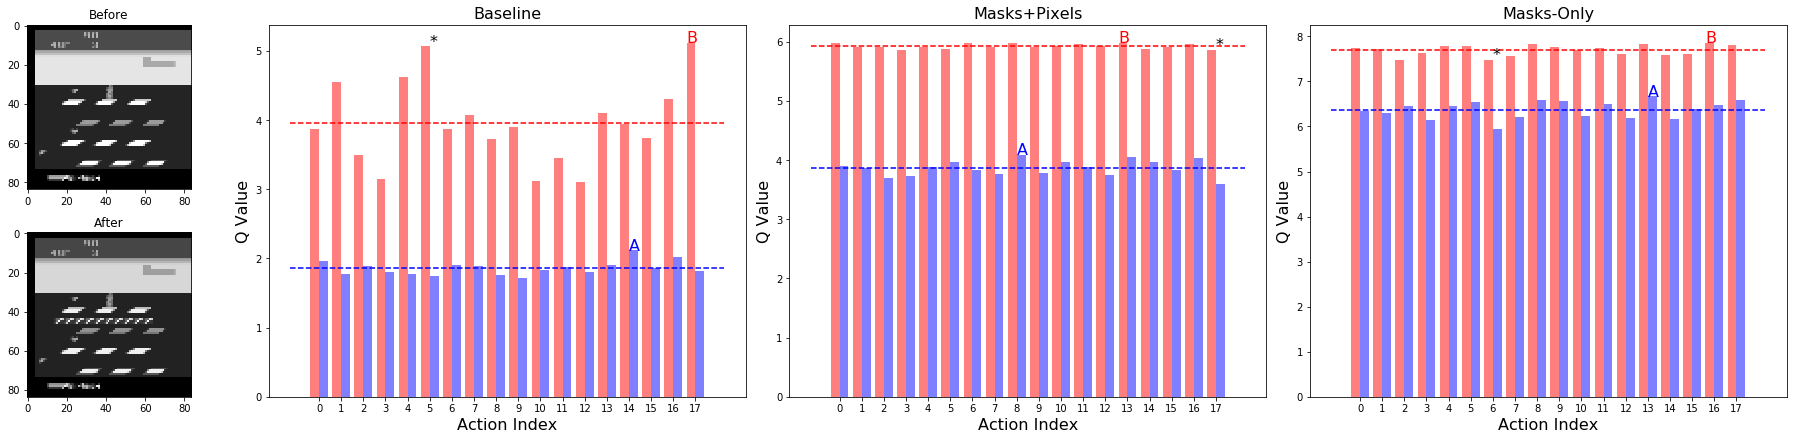

In [74]:
SRC_OBS_INDEX = 325
DST_OBS_INEX = 94
CHANNEL_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.5)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor, lightened_bad_animal_pixels_tensor, darkened_bad_animal_tensor, norm=True)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, bad_animal_loc[1].start + 5 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.862 | Difference: -0.095
Max Q value diff is 0.144 for action down + right + fire [16]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.025)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 3.943 | Difference: -1.980
Max Q value diff is 2.150 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 4.132)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.376 | Difference: -1.322
Max Q value diff is 1.528 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 6.673)



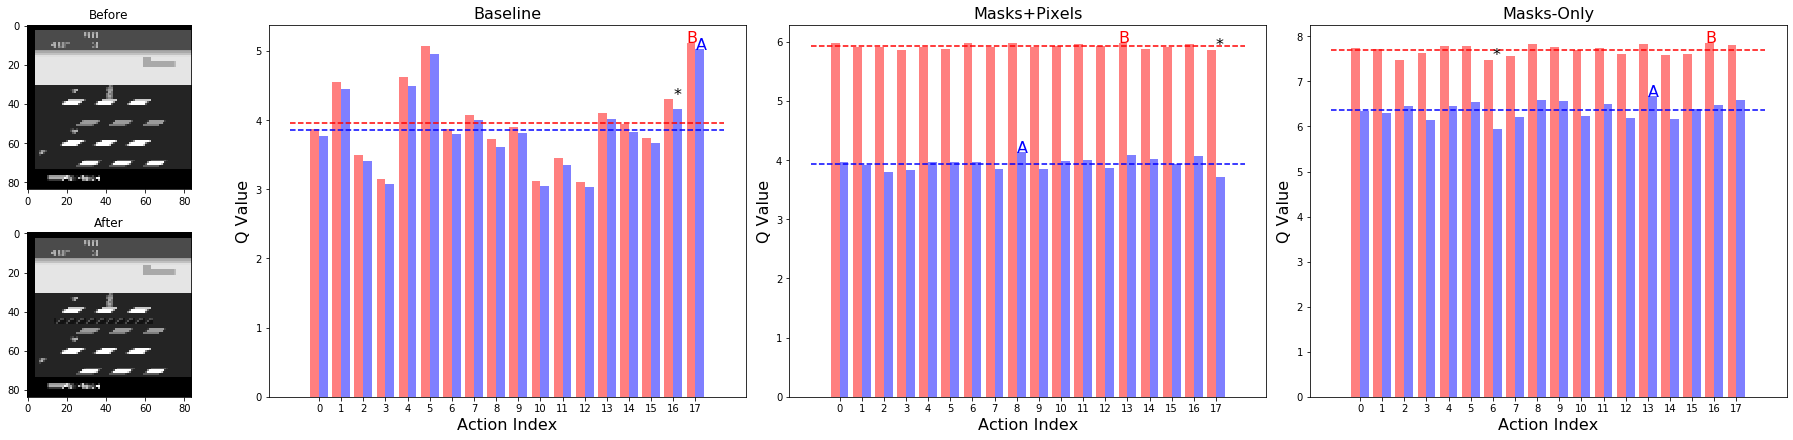

In [75]:
SRC_OBS_INDEX = 325
DST_OBS_INEX = 94
CHANNEL_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.5)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor, lightened_bad_animal_pixels_tensor, darkened_bad_animal_tensor, norm=True)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, bad_animal_loc[1].start + 5 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_bad_animal_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.717 | Difference: 0.760
Max Q value diff is 2.004 for action up + left + fire [15]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + left + fire [15] (Q = 5.750)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 3.015 | Difference: -2.908
Max Q value diff is 3.015 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: left [4] (Q = 3.140)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 4.045 | Difference: -3.653
Max Q value diff is 4.010 for action up + fire [10]
Before action: down + right + fire [16] (Q = 7.864) | After action: up [2] (Q = 4.427)



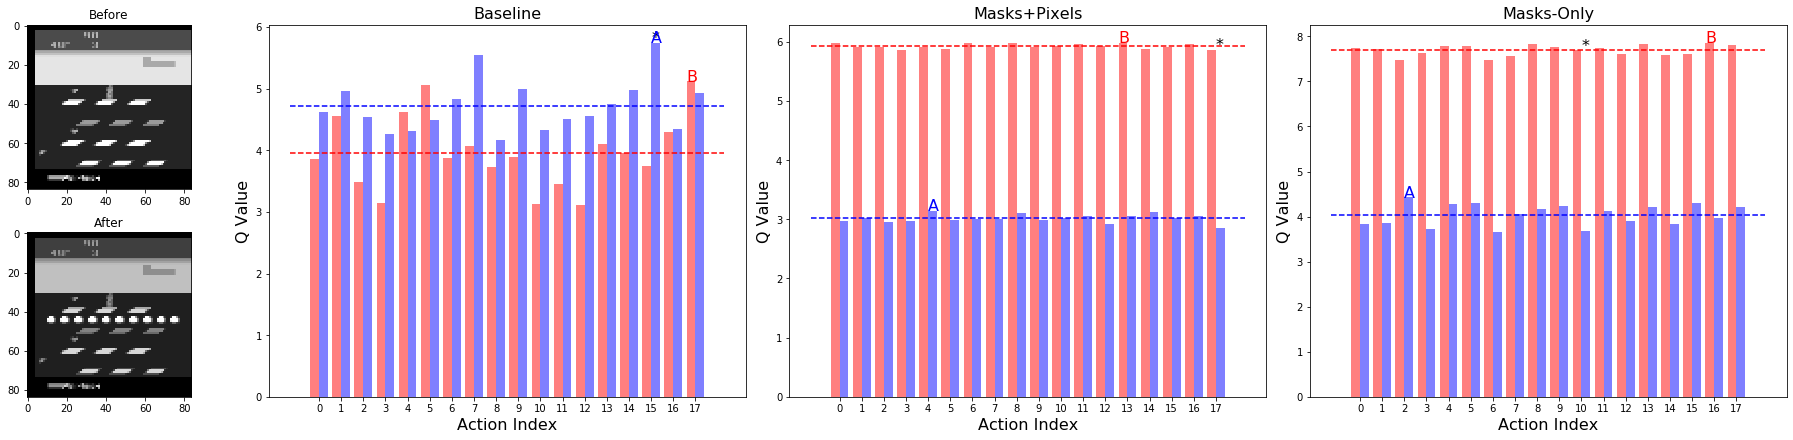

In [81]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor, lightened_bad_animal_pixels_tensor, darkened_bad_animal_tensor, norm=True)
# print(bad_animal_loc)

# NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.247 | Difference: -0.709
Max Q value diff is 0.975 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 4.343)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 3.119 | Difference: -2.804
Max Q value diff is 2.905 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: left [4] (Q = 3.250)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 4.045 | Difference: -3.653
Max Q value diff is 4.010 for action up + fire [10]
Before action: down + right + fire [16] (Q = 7.864) | After action: up [2] (Q = 4.427)



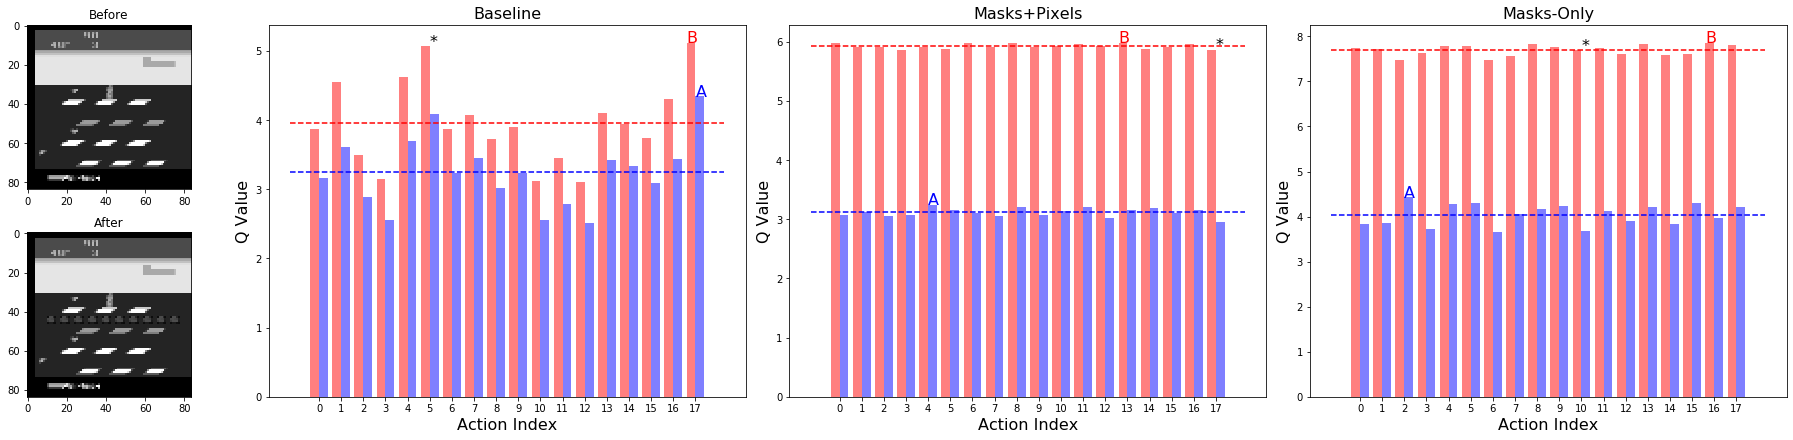

In [82]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)

# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor, lightened_bad_animal_pixels_tensor, darkened_bad_animal_tensor, norm=True)
# print(bad_animal_loc)

# NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start + 11, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_bad_animal_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.717 | Difference: 0.760
Max Q value diff is 2.004 for action up + left + fire [15]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + left + fire [15] (Q = 5.750)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 3.015 | Difference: -2.908
Max Q value diff is 3.015 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: left [4] (Q = 3.140)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 4.045 | Difference: -3.653
Max Q value diff is 4.010 for action up + fire [10]
Before action: down + right + fire [16] (Q = 7.864) | After action: up [2] (Q = 4.427)



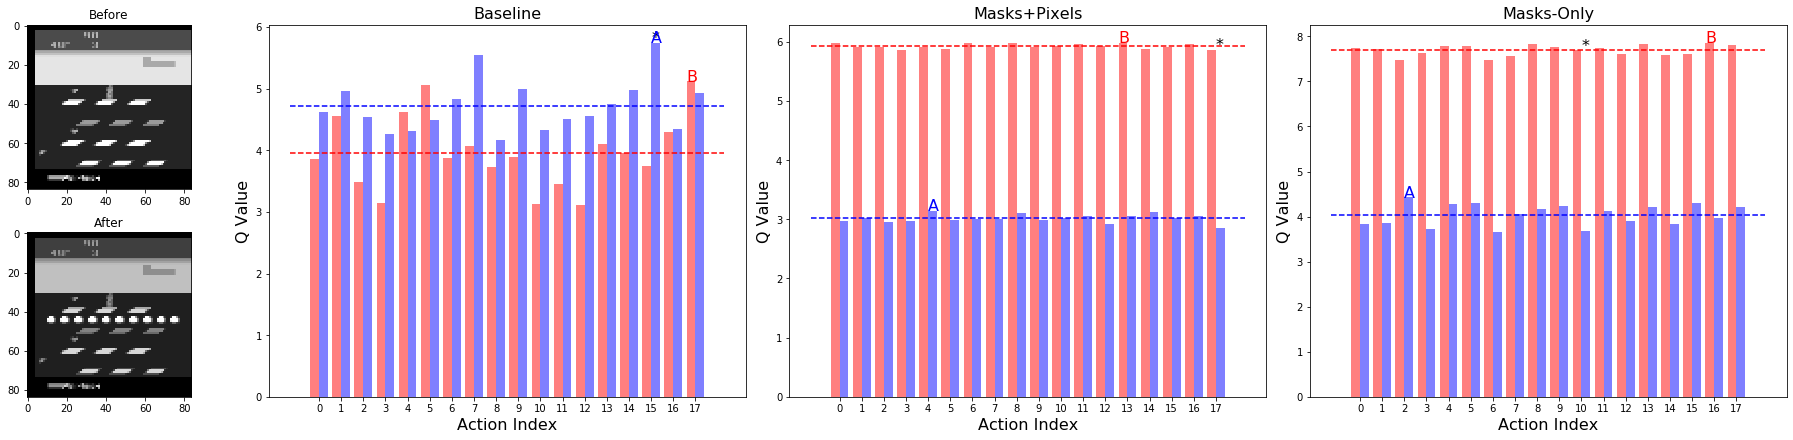

In [83]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)
# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.247 | Difference: -0.709
Max Q value diff is 0.975 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 4.343)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 3.119 | Difference: -2.804
Max Q value diff is 2.905 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: left [4] (Q = 3.250)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 4.045 | Difference: -3.653
Max Q value diff is 4.010 for action up + fire [10]
Before action: down + right + fire [16] (Q = 7.864) | After action: up [2] (Q = 4.427)



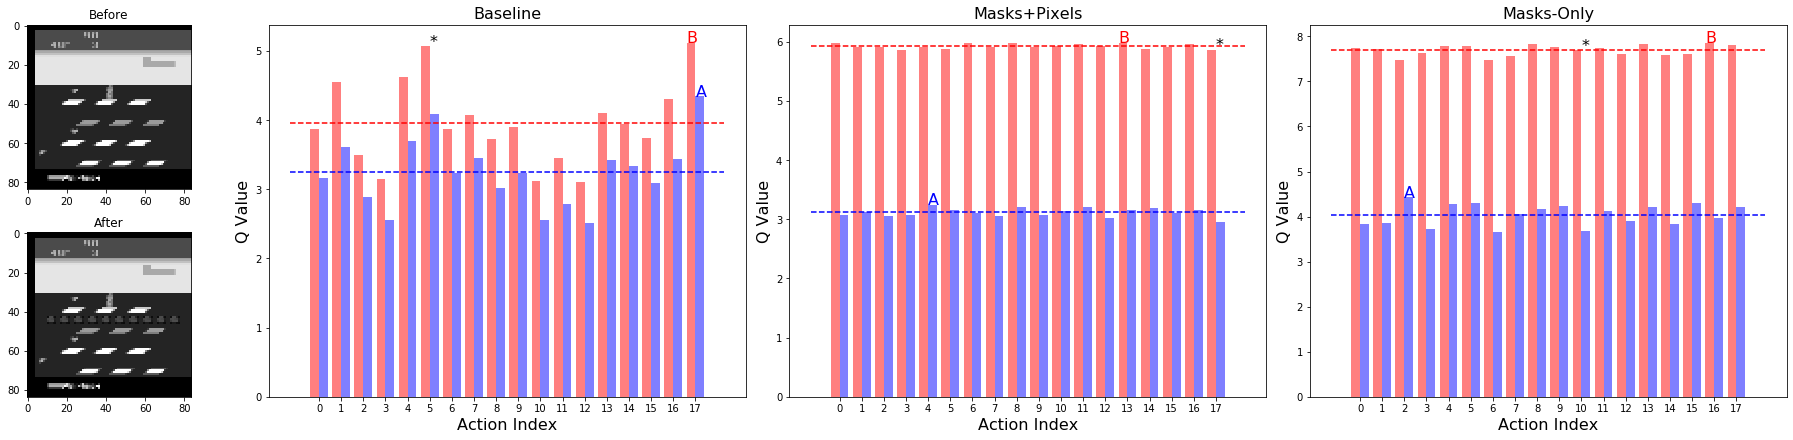

In [84]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 94
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)
# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_bad_animal_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.369 | Difference: -0.288
Max Q value diff is 1.855 for action up + right + fire [14]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.174)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.313 | Difference: -0.936
Max Q value diff is 1.300 for action left [4]
Before action: left [4] (Q = 3.697) | After action: up + right + fire [14] (Q = 2.511)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.633 | Difference: -1.528
Max Q value diff is 2.015 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: up [2] (Q = 4.511)



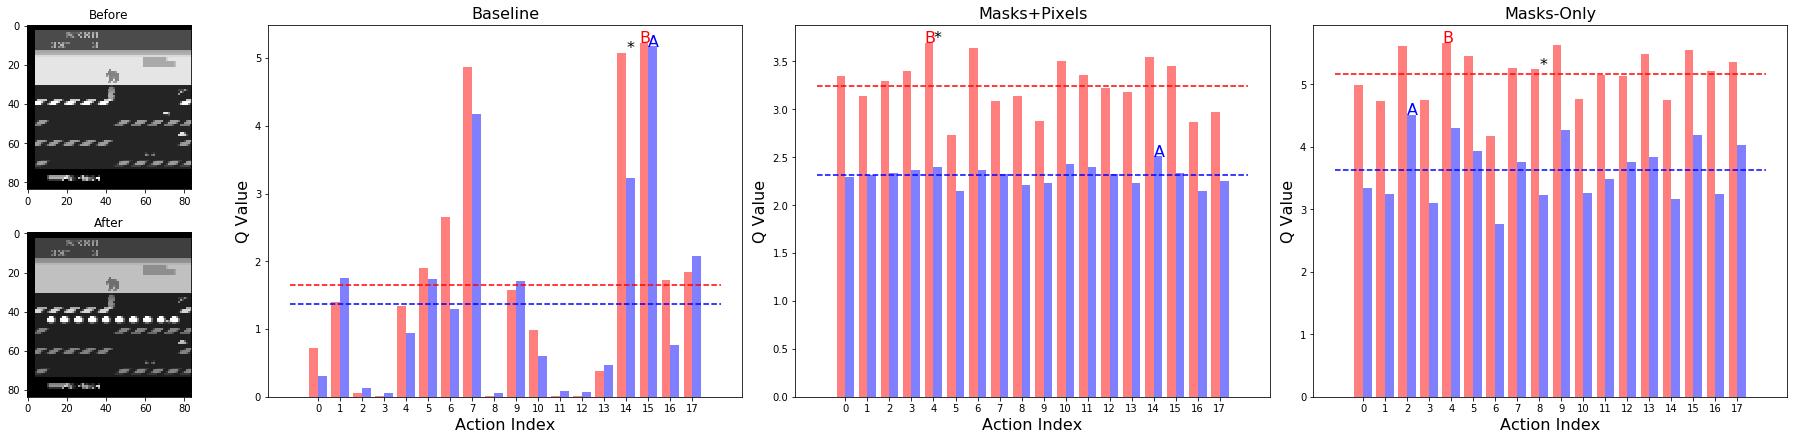

In [85]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 1112
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)
# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  lightened_bad_animal_pixels_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.714 | Difference: 0.057
Max Q value diff is 0.551 for action up + right [6]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + right + fire [14] (Q = 5.312)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.061 | Difference: -1.187
Max Q value diff is 1.540 for action left [4]
Before action: left [4] (Q = 3.697) | After action: right + fire [11] (Q = 2.196)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.633 | Difference: -1.528
Max Q value diff is 2.015 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: up [2] (Q = 4.511)



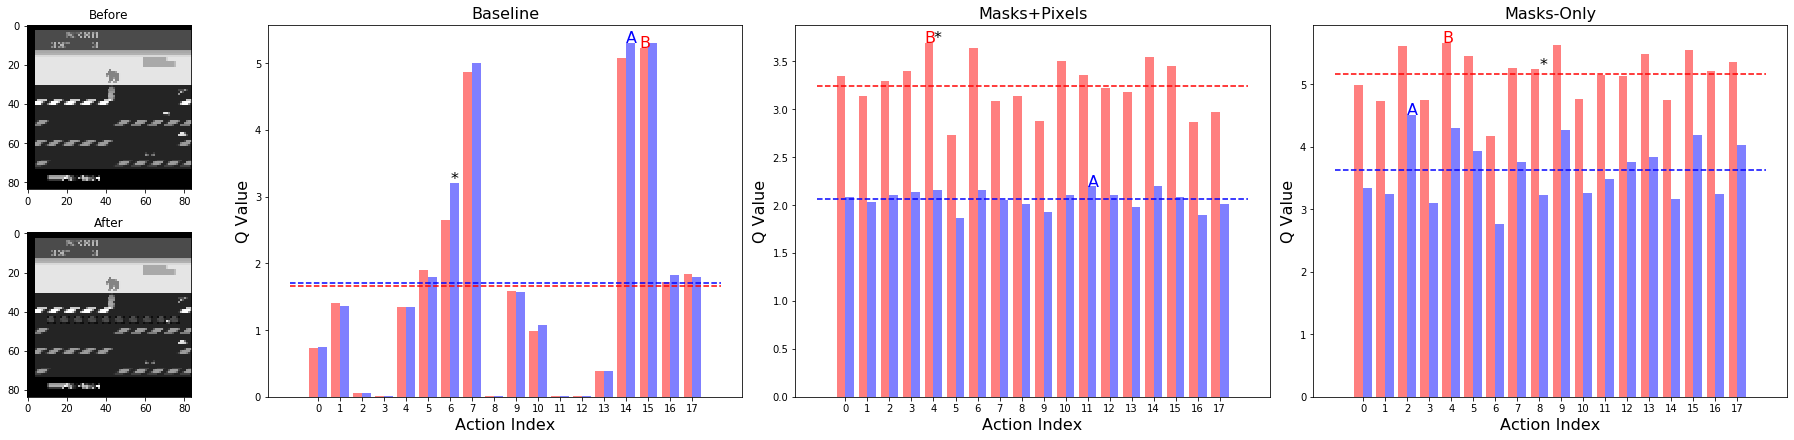

In [86]:
SRC_OBS_INDEX = 1270
DST_OBS_INEX = 1112
CHANNEL_INDEX = 1
OBJECT_INDEX = 1

bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=OBJECT_INDEX, return_location=True)
bad_animal_pixels_tensor = extract_raw_pixels_object(sample_full_color_observations, SRC_OBS_INDEX, baseline_model, baseline_env, bad_animal_loc)
lightened_bad_animal_pixels_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=1.5)
darkened_bad_animal_tensor = change_intensity(bad_animal_pixels_tensor, multiplicative=0.33)
# plot_tensors(bad_animal_mask_tensor, bad_animal_pixels_tensor)
# print(bad_animal_loc)

NEW_BAD_ANIMAL_LOCATIONS = [(bad_animal_loc[0].start, 10 + 7 * i) for i in range(10)]

baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug =\
    make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                  darkened_bad_animal_tensor, bad_animal_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

evaluate_augmented_models(sample_full_color_observations, DST_OBS_INEX, 
                         [baseline_bad_animal_aug, masks_and_pixels_bad_animal_aug, masks_only_bad_animal_aug],
                          force_text=True)
    

# C -- New shape (and presumably, new color)
* What happens if an alien from space invaders comes to play Frostbite?
* The current alien is a little bit larger than some existing other objects
* **TODO: do we use the same image as the mask and the pixels?** Let's make it a little bit later brighter, like the other images tend to be

tensor(0.4654, device='cuda:0')
tensor(0.4693, device='cuda:0') tensor(0.3904, device='cuda:0') tensor(0.5123, device='cuda:0') tensor(0.3514, device='cuda:0')
tensor(0.5491, device='cuda:0')
tensor(0.2857, device='cuda:0') tensor(0.4968, device='cuda:0') tensor(0.7393, device='cuda:0') tensor(0.6109, device='cuda:0')


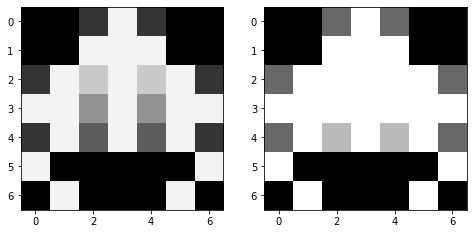

In [112]:
alien_pixels_tensor = torch.tensor([[  0,   0,  52, 243,  52,   0,   0],
       [  0,   0, 243, 243, 243,   0,   0],
       [ 52, 243, 202, 243, 202, 243,  52],
       [243, 243, 148, 243, 148, 243, 243],
       [ 52, 243,  93, 243,  93, 243,  52],
       [243,   0,   0,   0,   0,   0, 243],
       [  0, 243,   0,   0,   0, 243,   0]], dtype=torch.float32, device=bad_animal_pixels_tensor.device) / 255

print(alien_pixels_tensor.mean())
print(bad_animal_pixels_tensor.mean(), fish_pixels_tensor.mean(), igloo_pixels_tensor.mean(), player_pixels_tensor.mean())

alien_mask_tensor = change_intensity(alien_pixels_tensor, multiplicative=2)
print(alien_mask_tensor.mean())
print(bad_animal_mask_tensor.mean(), fish_mask_tensor.mean(), igloo_mask_tensor.mean(), player_mask_tensor.mean())

plot_tensors(alien_pixels_tensor, alien_mask_tensor, norm=True)

tensor(0.3796, device='cuda:0')
tensor(0.4693, device='cuda:0') tensor(0.3904, device='cuda:0') tensor(0.5123, device='cuda:0') tensor(0.3514, device='cuda:0')
tensor(0.4693, device='cuda:0')
tensor(0.2857, device='cuda:0') tensor(0.4968, device='cuda:0') tensor(0.7393, device='cuda:0') tensor(0.6109, device='cuda:0')


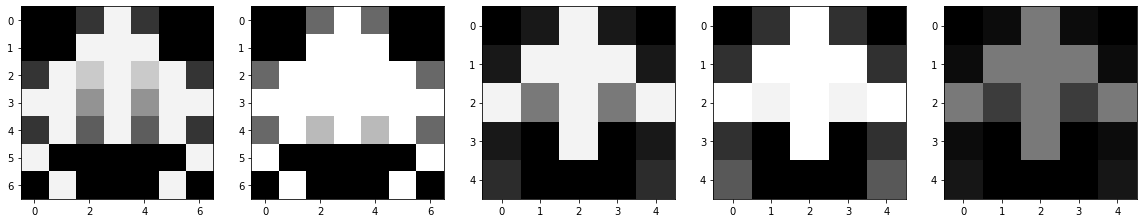

In [122]:
small_alien_pixels_tensor = torch.tensor([[  0,  24, 243,  24,   0],
       [ 24, 243, 243, 243,  24],
       [243, 122, 243, 122, 243],
       [ 24,   0, 243,   0,  24],
       [ 44,   0,   0,   0,  44]], dtype=torch.float32, device=bad_animal_pixels_tensor.device) / 255
                                         
print(small_alien_pixels_tensor.mean())
print(bad_animal_pixels_tensor.mean(), fish_pixels_tensor.mean(), igloo_pixels_tensor.mean(), player_pixels_tensor.mean())

small_alien_mask_tensor = change_intensity(small_alien_pixels_tensor, multiplicative=2)
print(small_alien_mask_tensor.mean())
print(bad_animal_mask_tensor.mean(), fish_mask_tensor.mean(), igloo_mask_tensor.mean(), player_mask_tensor.mean())

darker_small_alien_tensor = change_intensity(small_alien_pixels_tensor, multiplicative=0.5)

plot_tensors(alien_pixels_tensor, alien_mask_tensor, small_alien_pixels_tensor, small_alien_mask_tensor, darker_small_alien_tensor, norm=True)

# C.1 Aliens as bad animals

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 5.005 | Difference: 1.049
Max Q value diff is 1.819 for action right [3]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + right + fire [14] (Q = 5.244)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 3.589 | Difference: -2.334
Max Q value diff is 2.435 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 3.789)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 4.545 | Difference: -3.153
Max Q value diff is 3.430 for action down + right + fire [16]
Before action: down + right + fire [16] (Q = 7.864) | After action: up [2] (Q = 4.834)



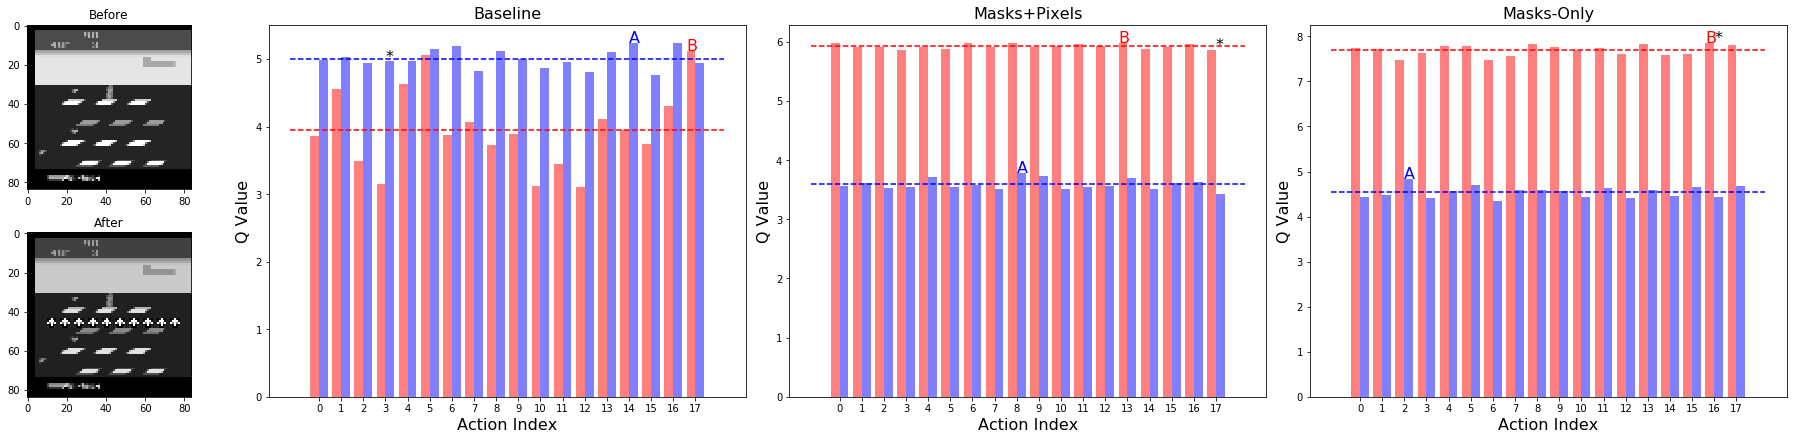

----

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 5.413 | Difference: 1.456
Max Q value diff is 1.939 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 6.479)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.005 | Difference: -0.918
Max Q value diff is 1.052 for action up + left [7]
Before action: down + fire [13] (Q = 5.989) | After action: down + fire [13] (Q = 5.186)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.068 | Difference: -1.630
Max Q value diff is 1.827 for action left [4]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right [8] (Q = 6.467)



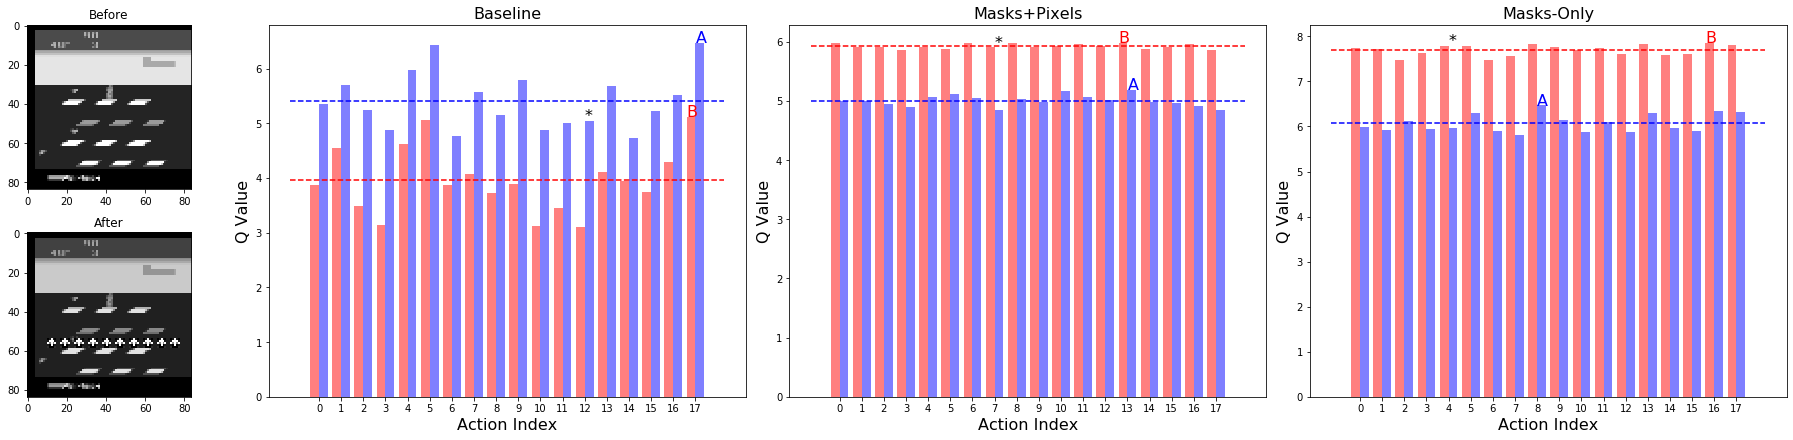

----

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.734 | Difference: -0.223
Max Q value diff is 0.923 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 4.875)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.179 | Difference: -0.744
Max Q value diff is 0.843 for action up + fire [10]
Before action: down + fire [13] (Q = 5.989) | After action: down + right + fire [16] (Q = 5.324)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.567 | Difference: -1.130
Max Q value diff is 1.323 for action left [4]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 6.737)



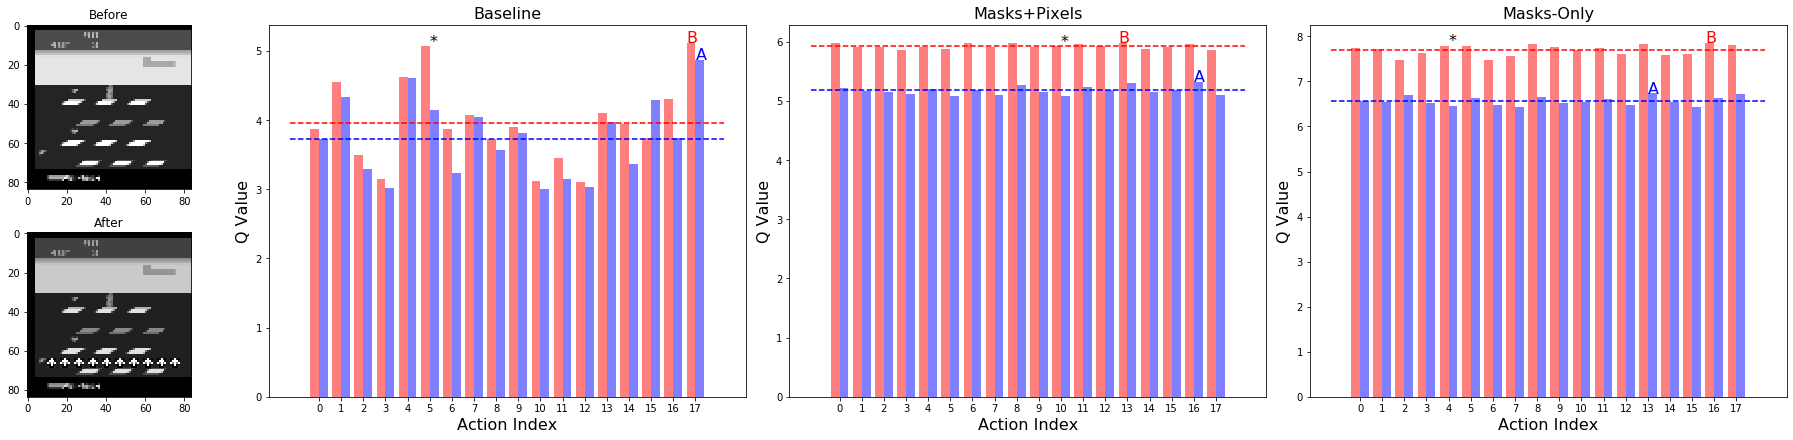

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.073 | Difference: -0.584
Max Q value diff is 1.600 for action up + left [7]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 4.034)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.546 | Difference: -0.702
Max Q value diff is 1.103 for action left [4]
Before action: left [4] (Q = 3.697) | After action: down + right + fire [16] (Q = 2.688)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.345 | Difference: -1.815
Max Q value diff is 2.166 for action down + right + fire [16]
Before action: left [4] (Q = 5.666) | After action: up [2] (Q = 4.008)



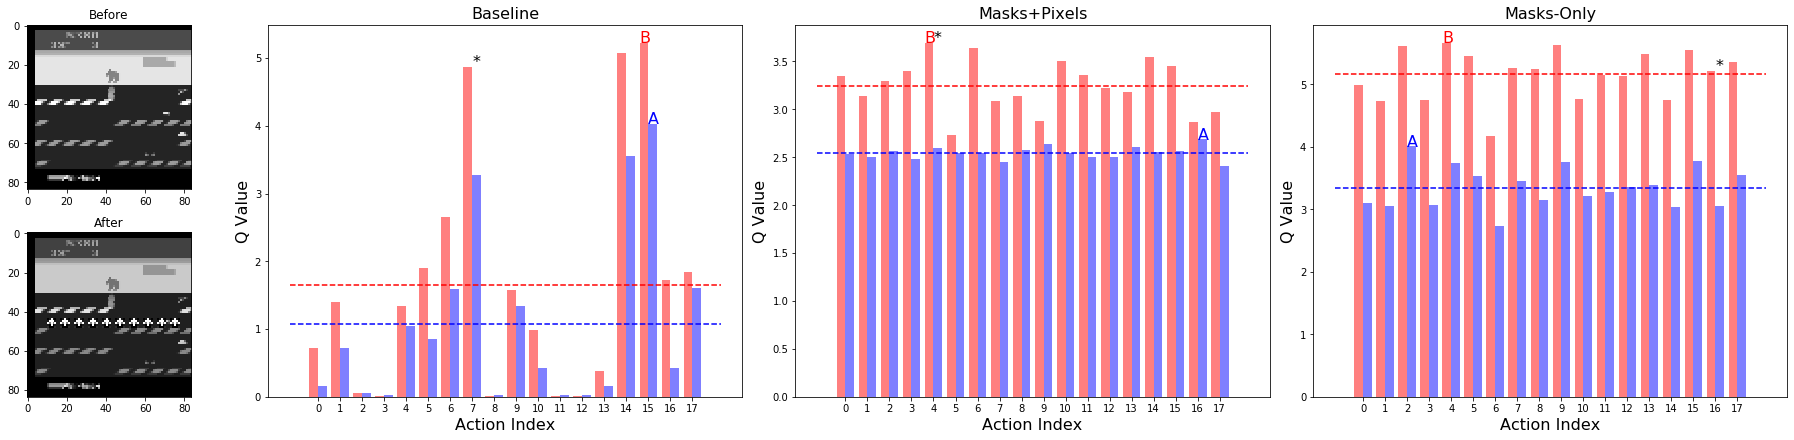

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 0.816 | Difference: -0.841
Max Q value diff is 3.503 for action up + right + fire [14]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 4.286)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.483 | Difference: 0.235
Max Q value diff is 0.369 for action down [5]
Before action: left [4] (Q = 3.697) | After action: up + right [6] (Q = 3.809)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.297 | Difference: -0.864
Max Q value diff is 1.143 for action up + left + fire [15]
Before action: left [4] (Q = 5.666) | After action: down + left [9] (Q = 4.634)



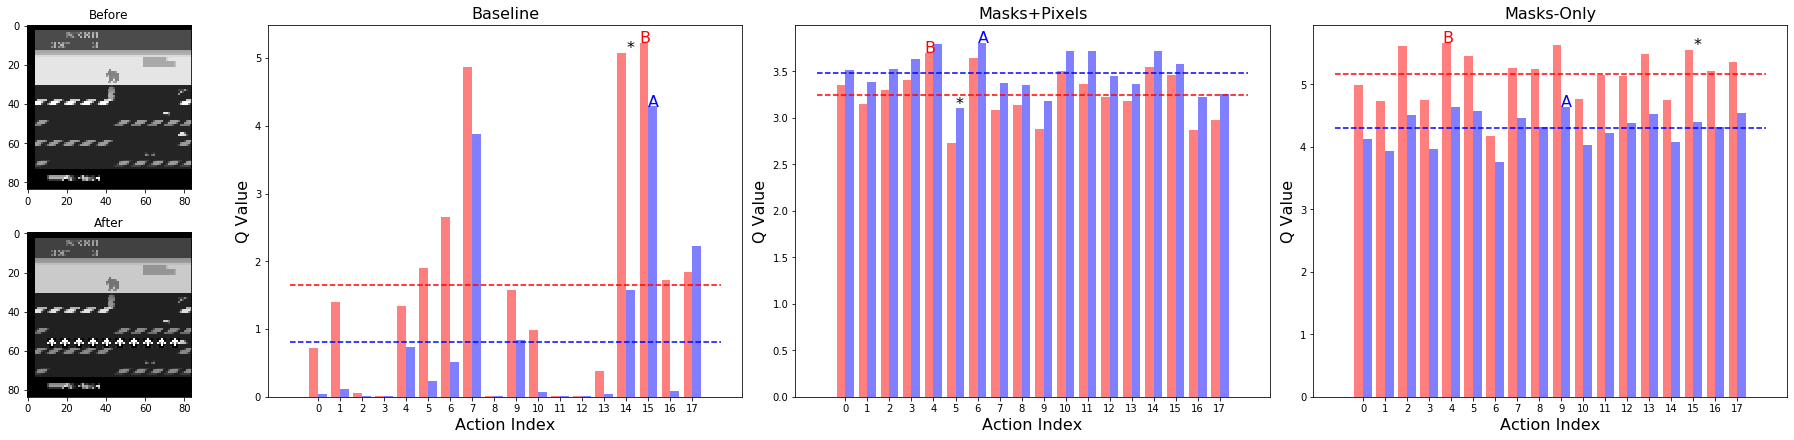

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.877 | Difference: 0.220
Max Q value diff is 0.591 for action up + left [7]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.790)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.678 | Difference: 0.430
Max Q value diff is 0.871 for action down [5]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 3.949)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.167 | Difference: -0.993
Max Q value diff is 1.388 for action up [2]
Before action: left [4] (Q = 5.666) | After action: down + left [9] (Q = 4.864)



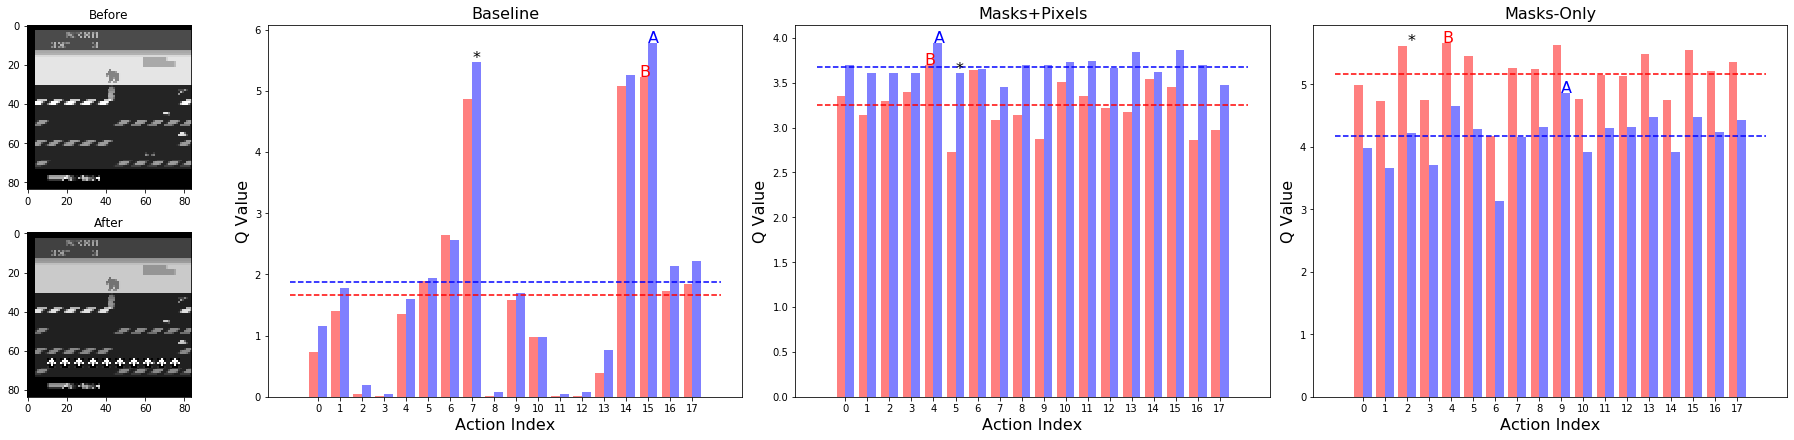

----

In [142]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 1
START_LOC = (44, 10)

for dst_index, row_loc_incs in zip((94, 1112),
                                   ((0, 10, 20), (0, 10, 20))):
    for row_loc_inc in row_loc_incs:
    
        bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)

        NEW_BAD_ANIMAL_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

        baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
            make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                          small_alien_pixels_tensor, small_alien_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

        evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                 [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                  force_text=True)
        
        display(Markdown('----'))
    




# C.2 Darker alien as bad animal

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.204 | Difference: 0.248
Max Q value diff is 0.583 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.336)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.011 | Difference: -0.912
Max Q value diff is 1.090 for action up + left [7]
Before action: down + fire [13] (Q = 5.989) | After action: down + fire [13] (Q = 5.269)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.068 | Difference: -1.630
Max Q value diff is 1.827 for action left [4]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right [8] (Q = 6.467)



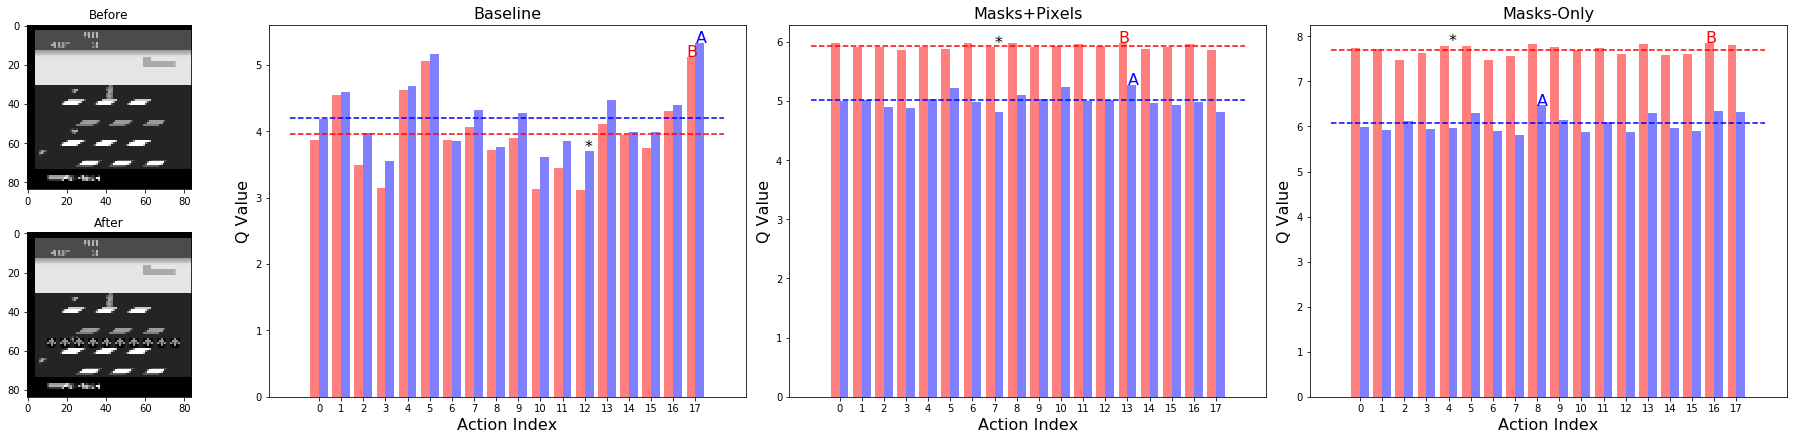

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.107 | Difference: 0.150
Max Q value diff is 0.456 for action up + left + fire [15]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.500)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.139 | Difference: -0.784
Max Q value diff is 0.884 for action up + fire [10]
Before action: down + fire [13] (Q = 5.989) | After action: down + right + fire [16] (Q = 5.307)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.567 | Difference: -1.130
Max Q value diff is 1.323 for action left [4]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 6.737)



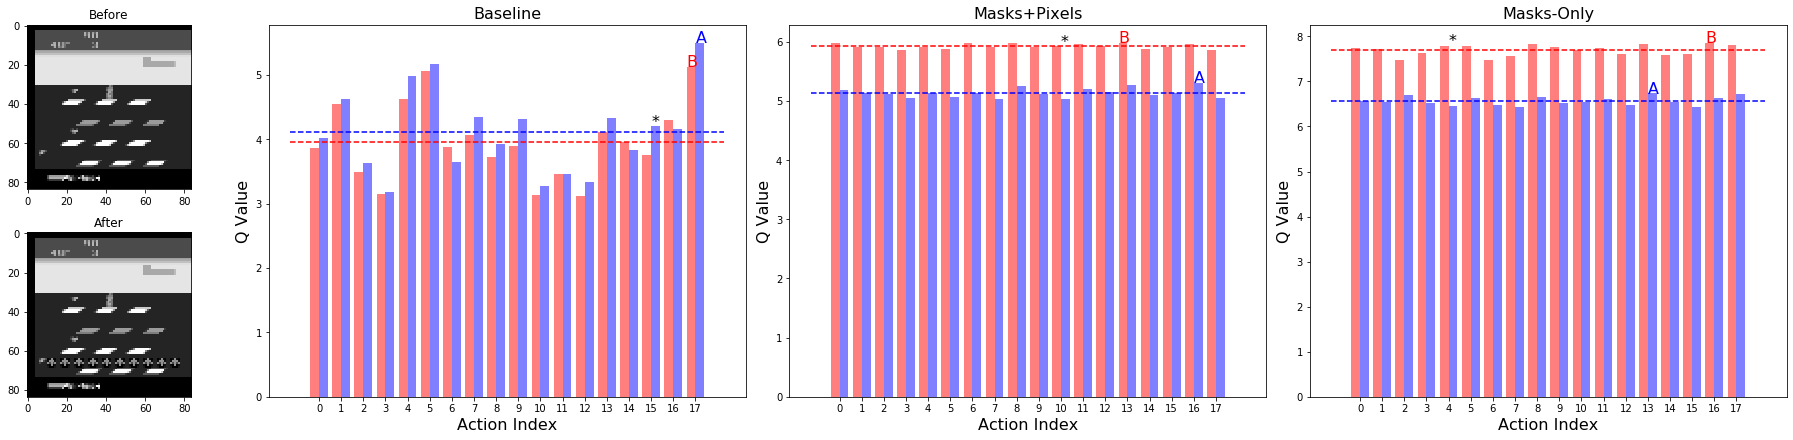

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.912 | Difference: -0.044
Max Q value diff is 0.439 for action fire [1]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 4.804)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.467 | Difference: -0.457
Max Q value diff is 0.581 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 5.615)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.489 | Difference: -0.209
Max Q value diff is 0.281 for action up + left + fire [15]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 7.727)



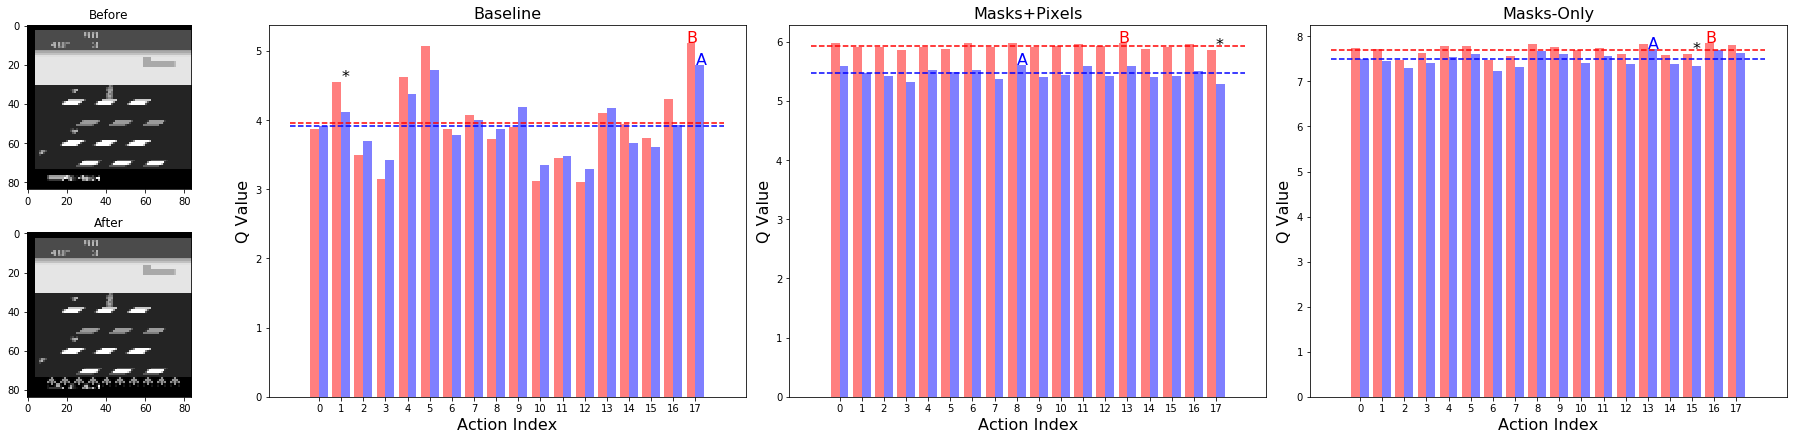

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.491 | Difference: -0.166
Max Q value diff is 0.991 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.335)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.313 | Difference: 0.065
Max Q value diff is 0.196 for action right + fire [11]
Before action: left [4] (Q = 3.697) | After action: up + right [6] (Q = 3.624)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.297 | Difference: -0.864
Max Q value diff is 1.143 for action up + left + fire [15]
Before action: left [4] (Q = 5.666) | After action: down + left [9] (Q = 4.634)



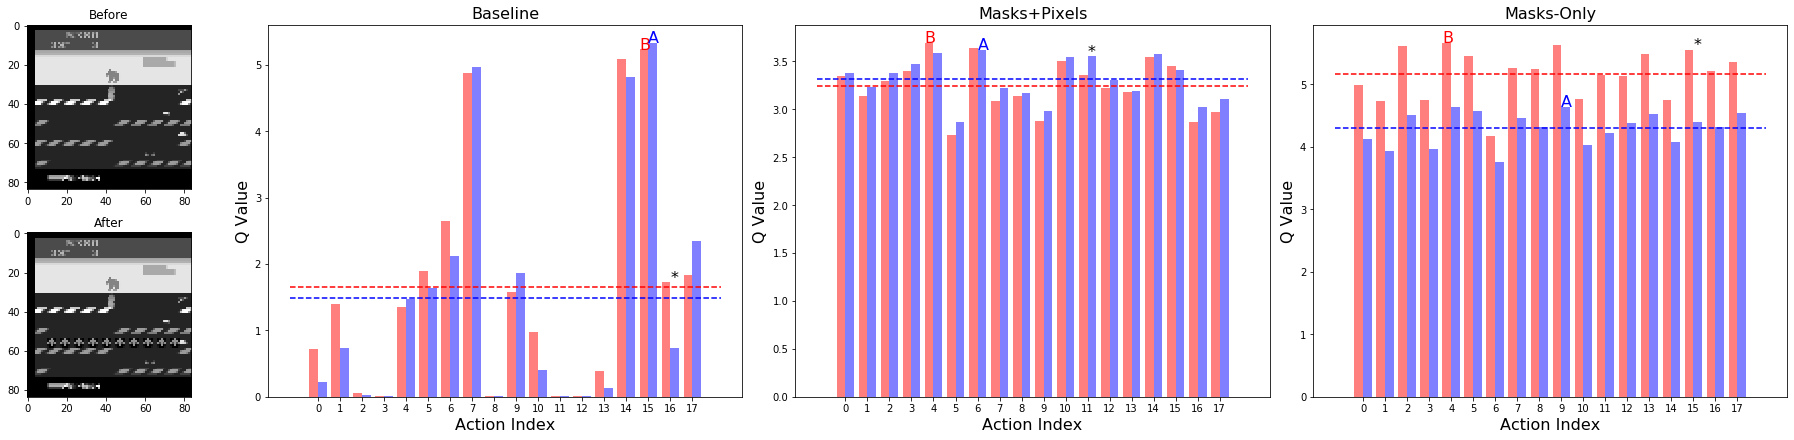

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.777 | Difference: 0.120
Max Q value diff is 0.299 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.463)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.678 | Difference: 0.430
Max Q value diff is 0.863 for action down [5]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 3.924)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.167 | Difference: -0.993
Max Q value diff is 1.388 for action up [2]
Before action: left [4] (Q = 5.666) | After action: down + left [9] (Q = 4.864)



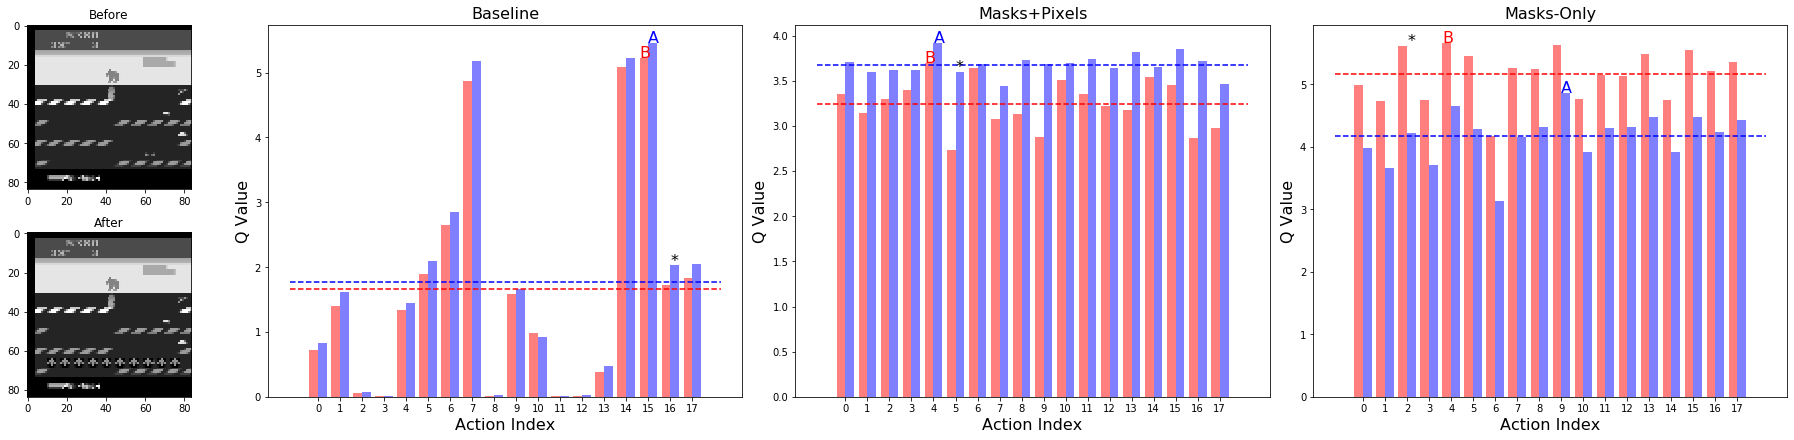

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.771 | Difference: 0.115
Max Q value diff is 0.295 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.008)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.204 | Difference: -0.044
Max Q value diff is 0.253 for action down + right + fire [16]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 3.654)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.719 | Difference: -0.441
Max Q value diff is 0.713 for action up + left [7]
Before action: left [4] (Q = 5.666) | After action: down + left [9] (Q = 5.417)



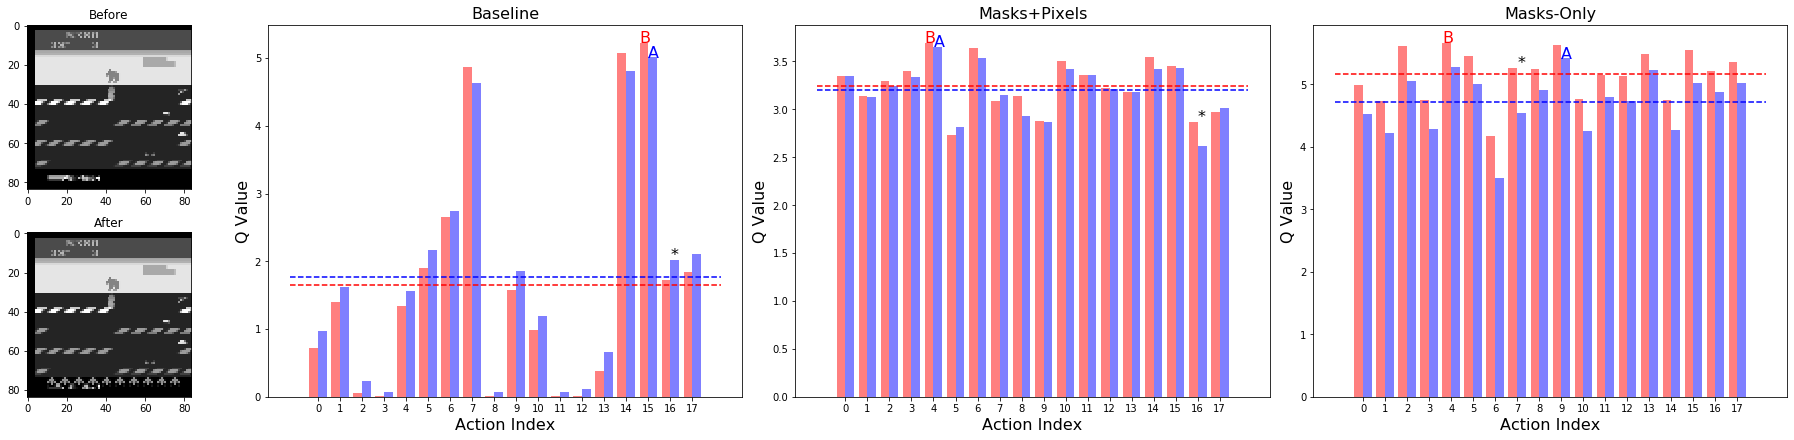

In [135]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 1
START_LOC = (44, 10)

for dst_index, row_loc_incs in zip((94, 1112),
                                   ((10, 20, 30), (10, 20, 30))):
    for row_loc_inc in row_loc_incs:
    
        bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)

        NEW_BAD_ANIMAL_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

        baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
            make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                          darker_small_alien_tensor, small_alien_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

        evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                 [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                  force_text=True)
        
        display(Markdown('----'))
    




# C.3 Aliens as good animals

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 5.005 | Difference: 1.049
Max Q value diff is 1.819 for action right [3]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + right + fire [14] (Q = 5.244)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 4.207 | Difference: -1.716
Max Q value diff is 2.549 for action up + left [7]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 5.947)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.024 | Difference: -0.674
Max Q value diff is 1.310 for action right [3]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 7.649)



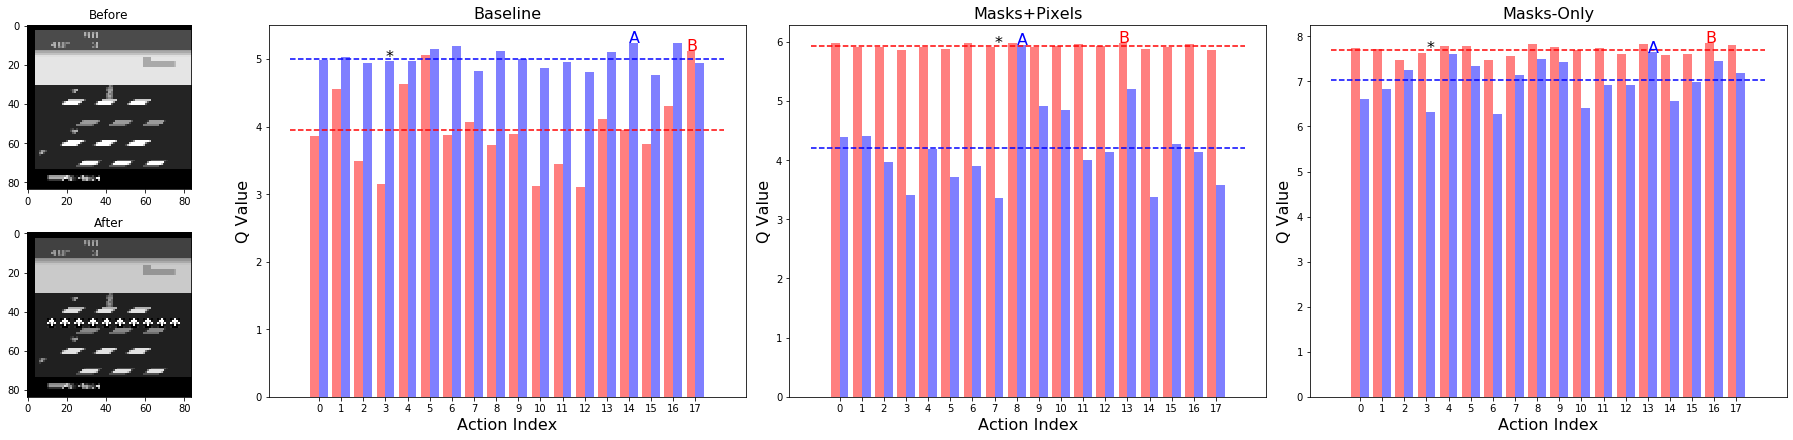

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 5.413 | Difference: 1.456
Max Q value diff is 1.939 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 6.479)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 8.795 | Difference: 2.872
Max Q value diff is 2.981 for action up + right + fire [14]
Before action: down + fire [13] (Q = 5.989) | After action: up + right + fire [14] (Q = 8.852)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 8.593 | Difference: 0.895
Max Q value diff is 1.335 for action up [2]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + left [9] (Q = 8.902)



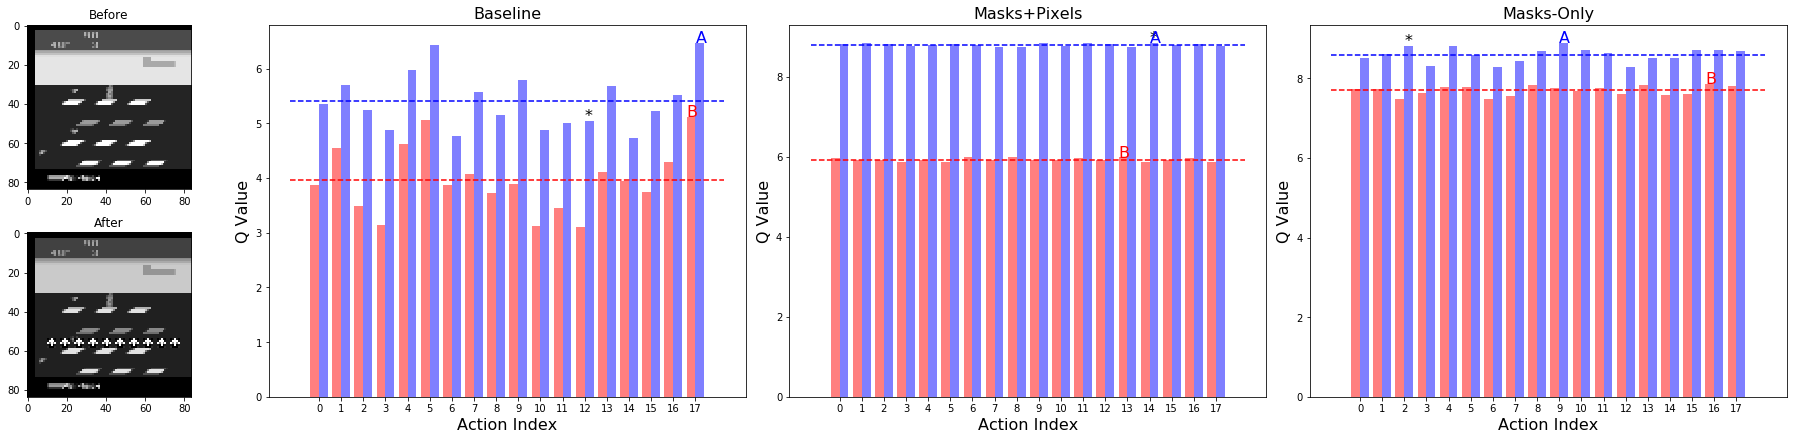

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.734 | Difference: -0.223
Max Q value diff is 0.923 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 4.875)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 8.056 | Difference: 2.133
Max Q value diff is 2.898 for action down + left [9]
Before action: down + fire [13] (Q = 5.989) | After action: down + left [9] (Q = 8.809)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.313 | Difference: -0.385
Max Q value diff is 0.688 for action up + left + fire [15]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right + fire [16] (Q = 7.690)



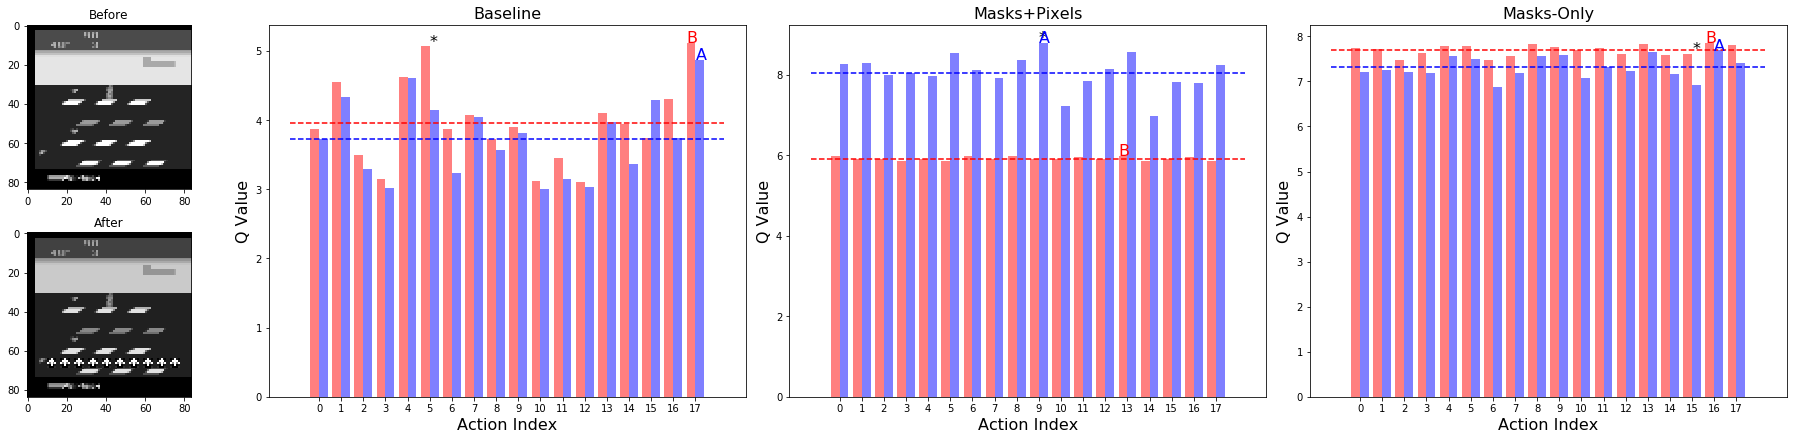

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.073 | Difference: -0.584
Max Q value diff is 1.600 for action up + left [7]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 4.034)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 1.989 | Difference: -1.259
Max Q value diff is 1.612 for action down + left [9]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 3.188)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.975 | Difference: -1.185
Max Q value diff is 2.120 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.695)



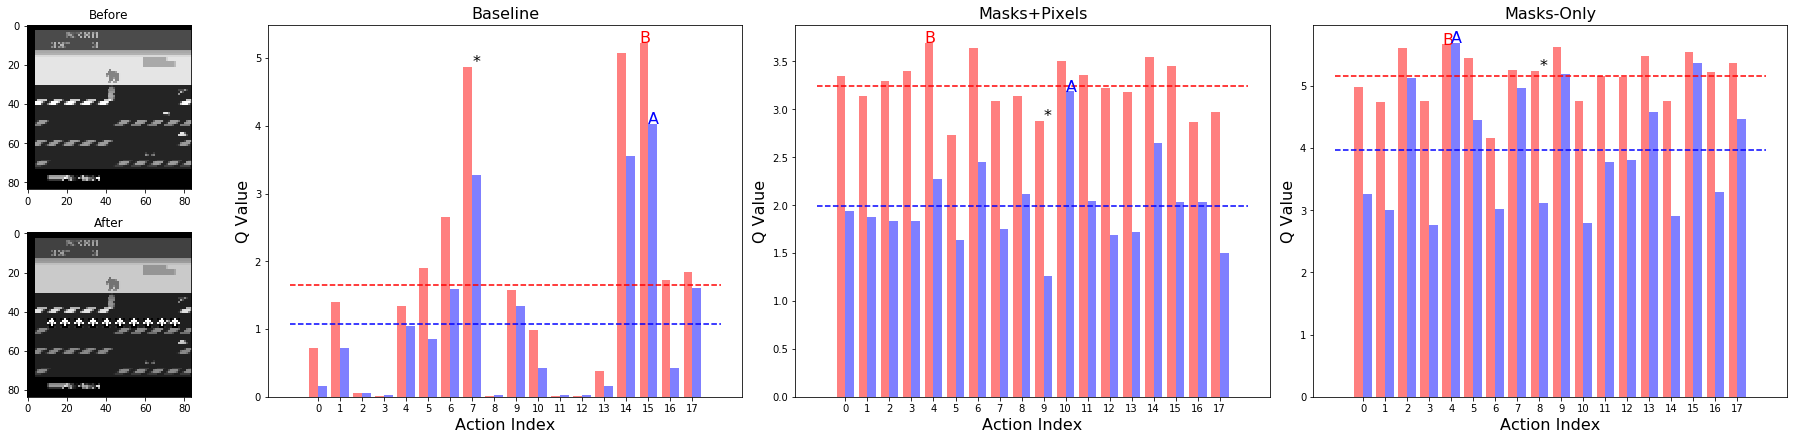

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 0.816 | Difference: -0.841
Max Q value diff is 3.503 for action up + right + fire [14]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 4.286)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 4.913 | Difference: 1.665
Max Q value diff is 1.927 for action up + fire [10]
Before action: left [4] (Q = 3.697) | After action: up + right [6] (Q = 5.483)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.826 | Difference: -1.335
Max Q value diff is 1.992 for action up + left + fire [15]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 4.446)



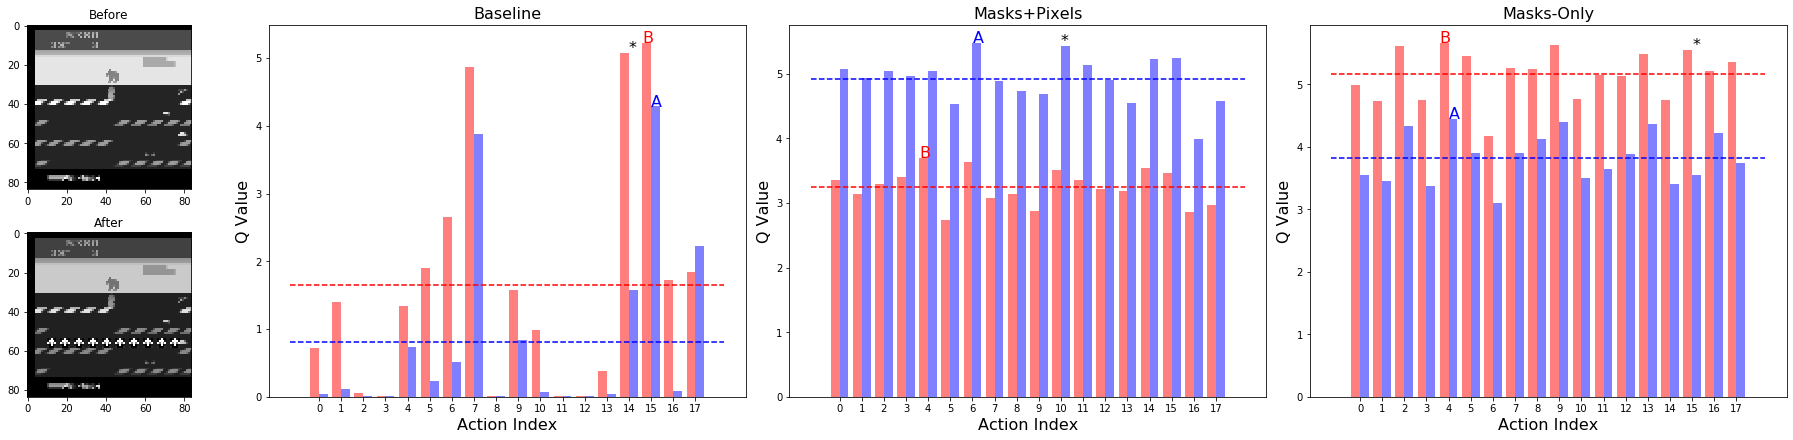

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.877 | Difference: 0.220
Max Q value diff is 0.591 for action up + left [7]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.790)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 1.258 | Difference: -1.990
Max Q value diff is 2.842 for action up + right + fire [14]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 1.934)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.496 | Difference: -0.665
Max Q value diff is 1.144 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.511)



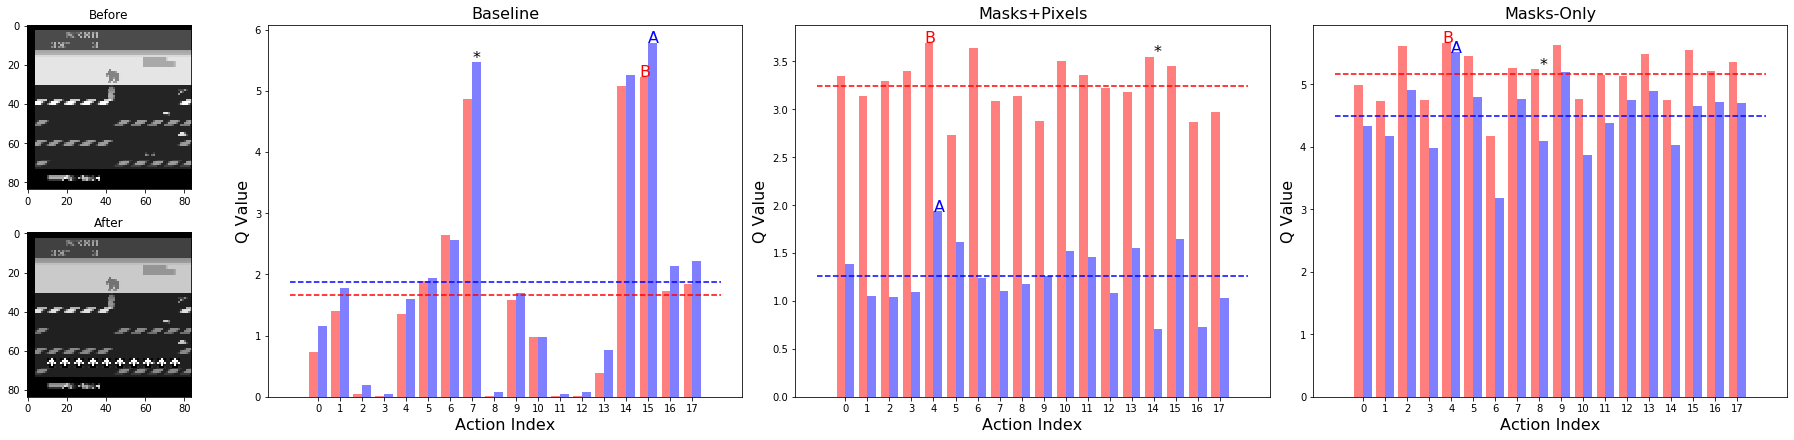

In [136]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 6
START_LOC = (44, 10)

for dst_index, row_loc_incs in zip((94, 1112),
                                   ((0, 10, 20), (0, 10, 20))):
    for row_loc_inc in row_loc_incs:
    
        bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)

        NEW_BAD_ANIMAL_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

        baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
            make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                          small_alien_pixels_tensor, small_alien_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

        evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                 [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                  force_text=True)
        
        display(Markdown('----'))
    




# C.4 Darker alien as good animal

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.074 | Difference: -0.883
Max Q value diff is 1.792 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + right + fire [14] (Q = 3.497)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.957 | Difference: 0.034
Max Q value diff is 1.450 for action down + right [8]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 7.431)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.024 | Difference: -0.674
Max Q value diff is 1.310 for action right [3]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 7.649)



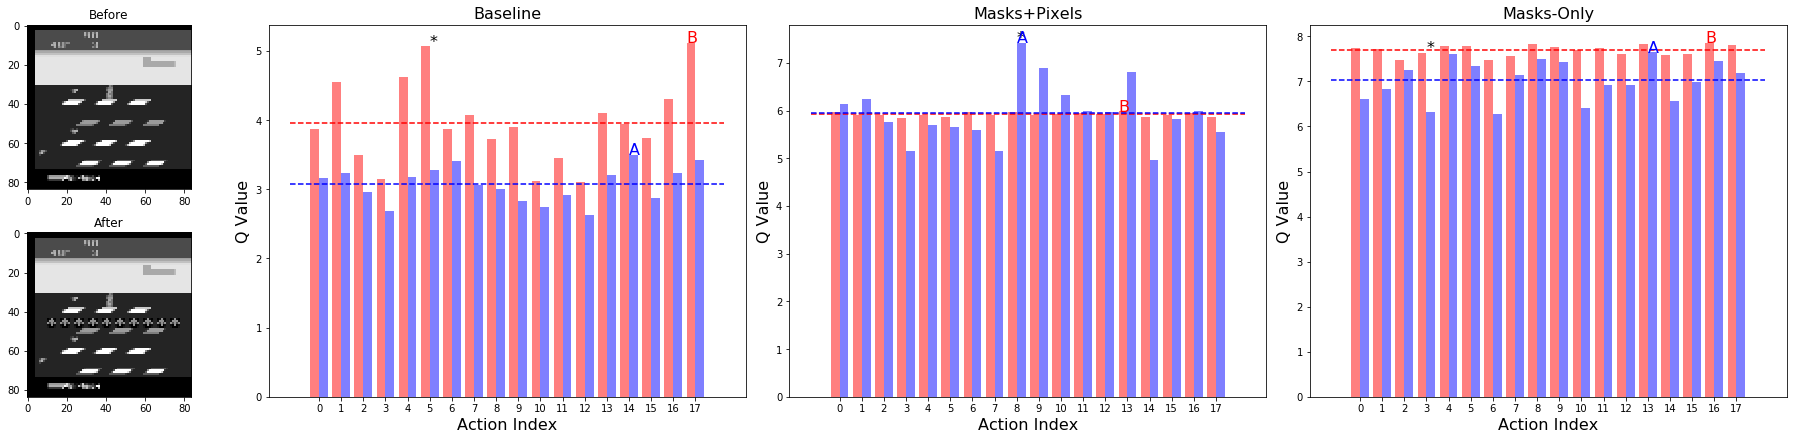

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.204 | Difference: 0.248
Max Q value diff is 0.583 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.336)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 8.829 | Difference: 2.906
Max Q value diff is 3.007 for action down [5]
Before action: down + fire [13] (Q = 5.989) | After action: down + right + fire [16] (Q = 8.881)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 8.593 | Difference: 0.895
Max Q value diff is 1.335 for action up [2]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + left [9] (Q = 8.902)



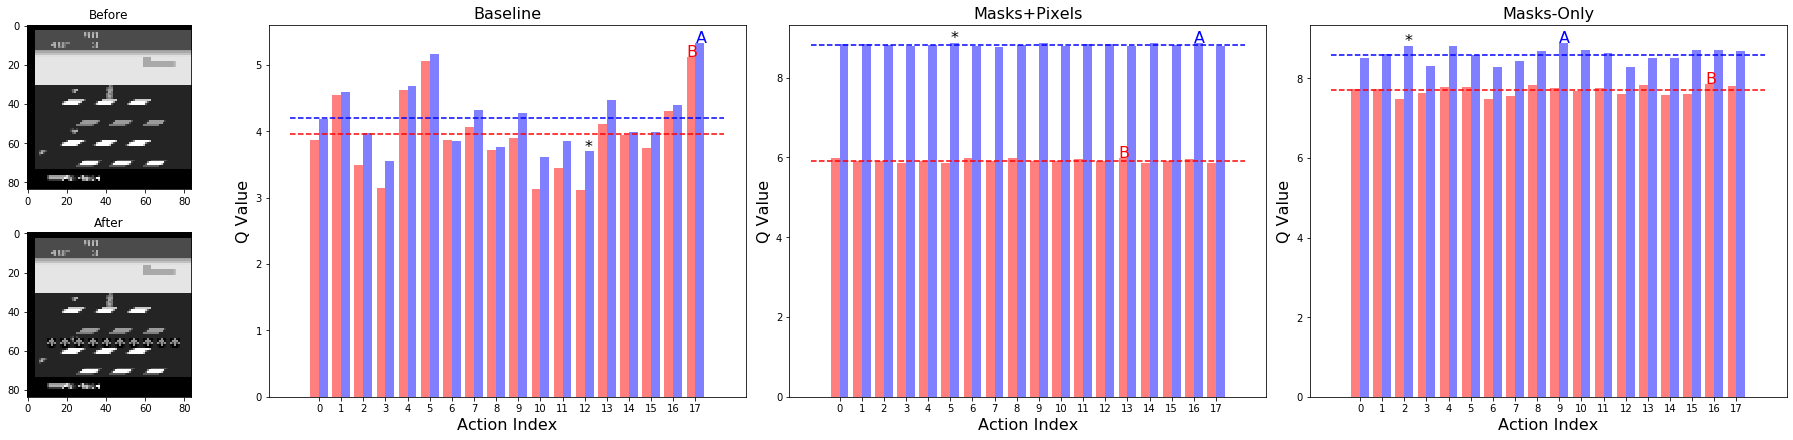

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.107 | Difference: 0.150
Max Q value diff is 0.456 for action up + left + fire [15]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.500)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 8.562 | Difference: 2.639
Max Q value diff is 3.221 for action down + left [9]
Before action: down + fire [13] (Q = 5.989) | After action: down + left [9] (Q = 9.133)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.313 | Difference: -0.385
Max Q value diff is 0.688 for action up + left + fire [15]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right + fire [16] (Q = 7.690)



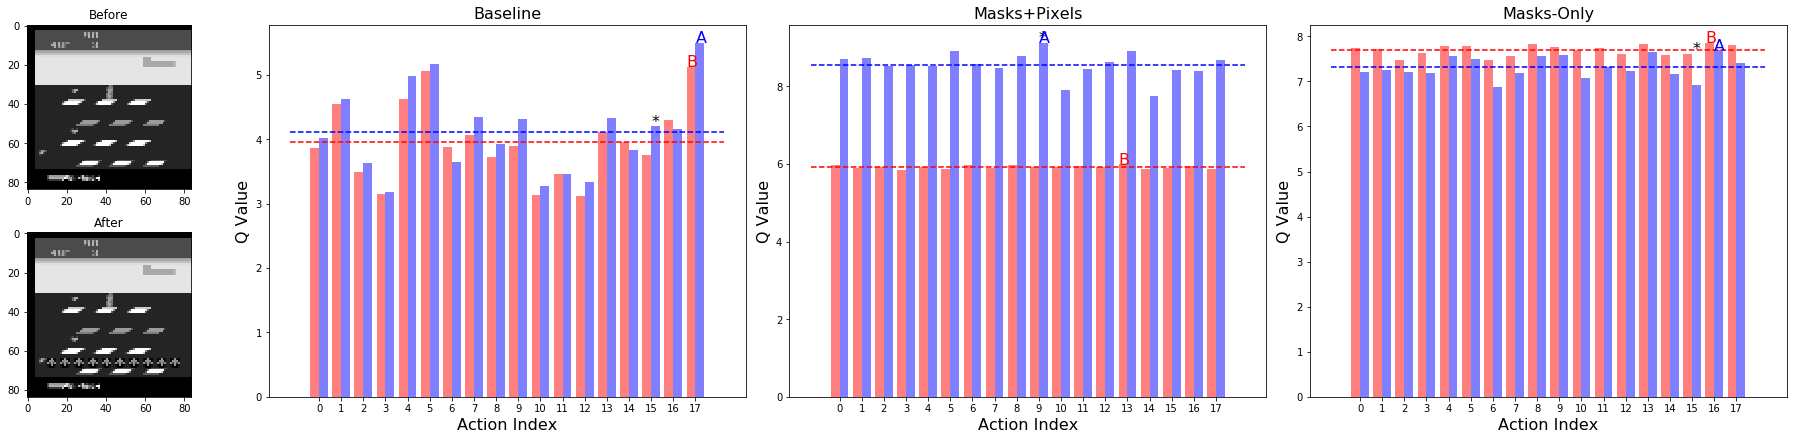

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.433 | Difference: -0.223
Max Q value diff is 0.676 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.091)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.204 | Difference: -1.045
Max Q value diff is 1.635 for action down + left + fire [17]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 4.348)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.975 | Difference: -1.185
Max Q value diff is 2.120 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.695)



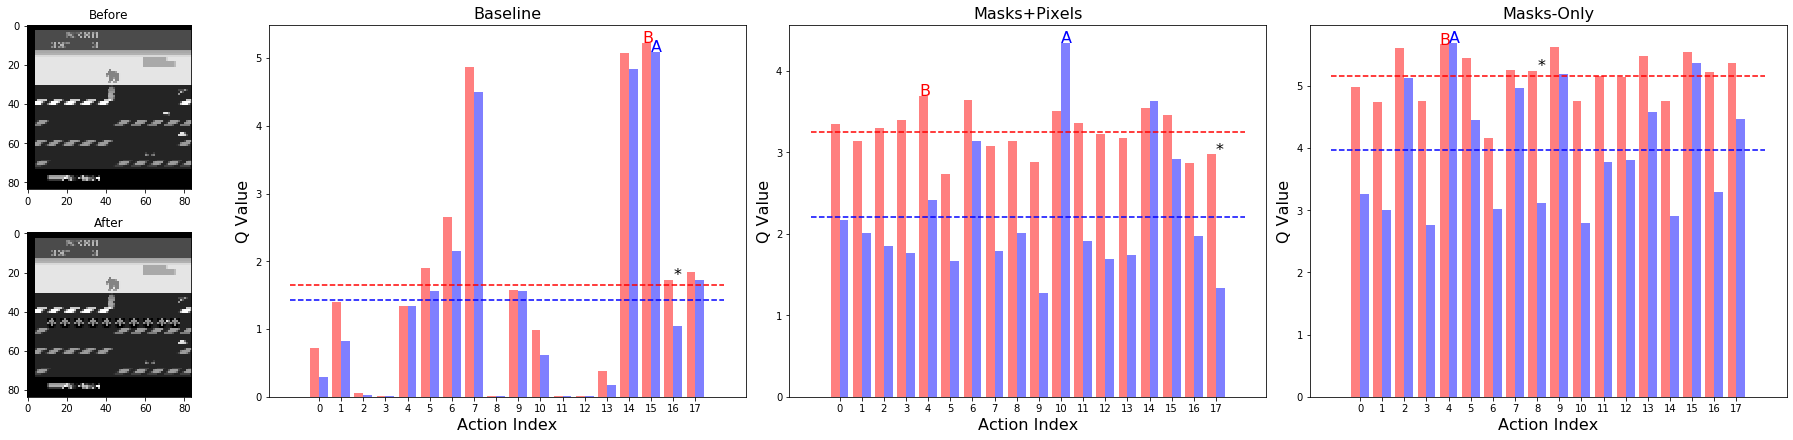

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.491 | Difference: -0.166
Max Q value diff is 0.991 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.335)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 4.758 | Difference: 1.510
Max Q value diff is 1.830 for action up + fire [10]
Before action: left [4] (Q = 3.697) | After action: up + fire [10] (Q = 5.335)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 3.826 | Difference: -1.335
Max Q value diff is 1.992 for action up + left + fire [15]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 4.446)



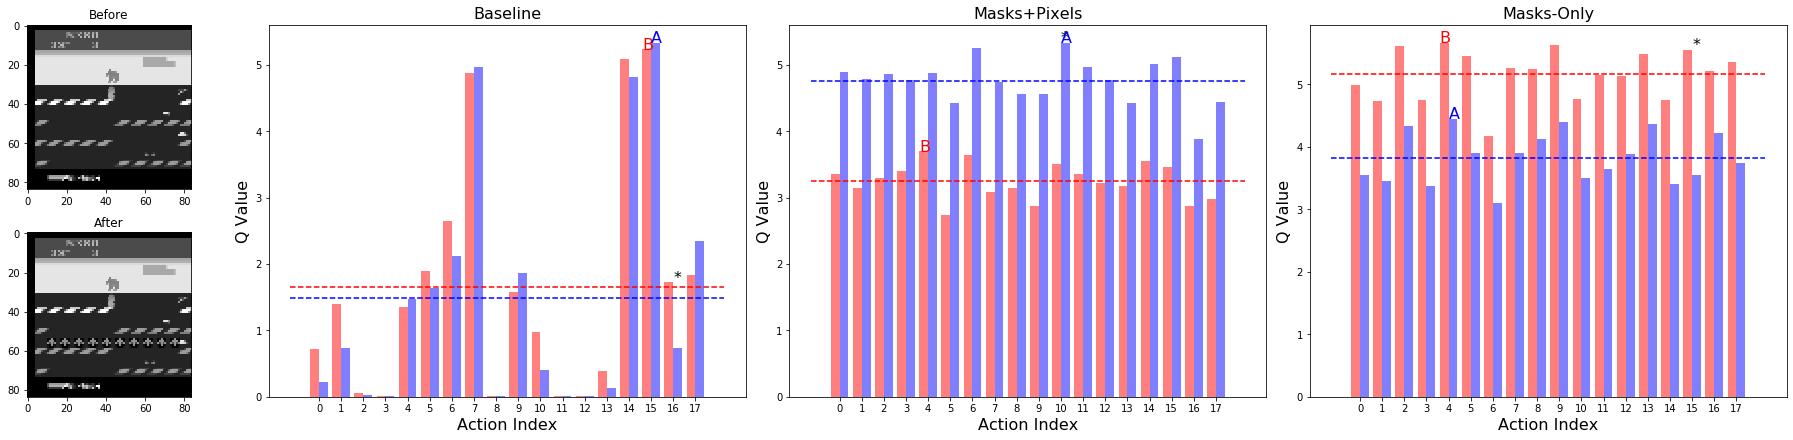

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.777 | Difference: 0.120
Max Q value diff is 0.299 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.463)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 1.353 | Difference: -1.895
Max Q value diff is 2.622 for action up + right + fire [14]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 1.917)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.496 | Difference: -0.665
Max Q value diff is 1.144 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.511)



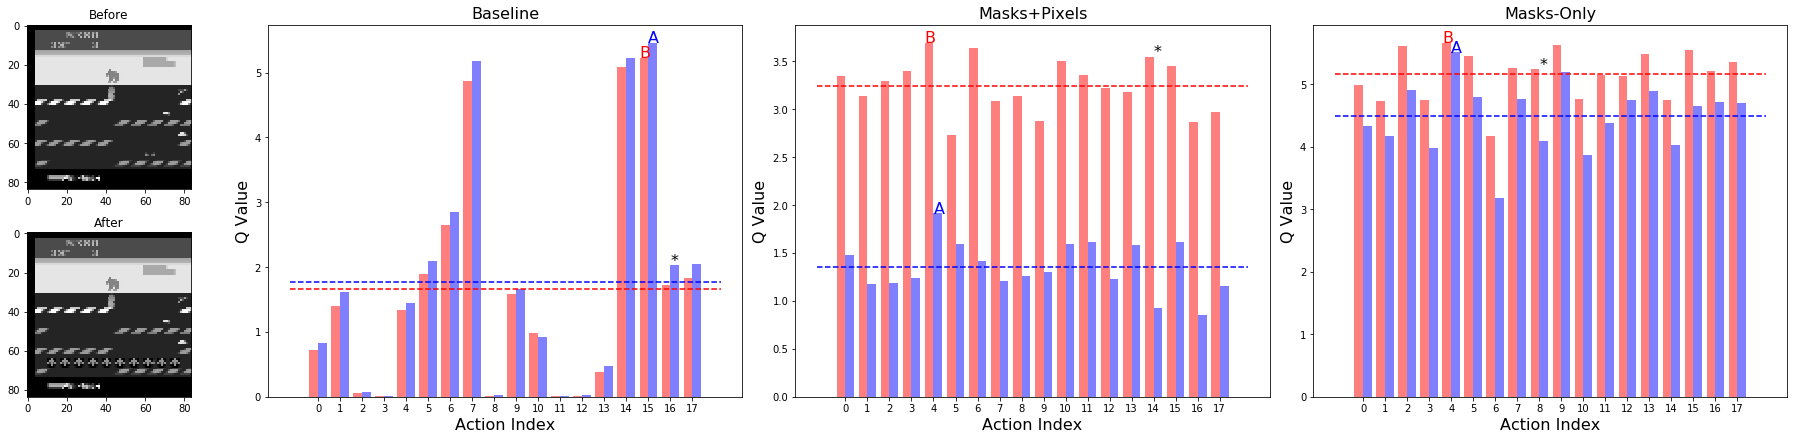

In [137]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 6
START_LOC = (44, 10)

for dst_index, row_loc_incs in zip((94, 1112),
                                   ((0, 10, 20), (0, 10, 20))):
    for row_loc_inc in row_loc_incs:
    
        bad_animal_mask_tensor, bad_animal_loc = extract_object(sample_full_color_observations, SRC_OBS_INDEX, masks_only_model, masks_only_env,
                                           channel_index=CHANNEL_INDEX, object_index=0, return_location=True)

        NEW_BAD_ANIMAL_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

        baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
            make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                          darker_small_alien_tensor, small_alien_mask_tensor, CHANNEL_INDEX, NEW_BAD_ANIMAL_LOCATIONS)

        evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                 [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                  force_text=True)
        
        display(Markdown('----'))
    




# C.5 Aliens as visited and unvisited ice floes? 

## Unvisited Floes

/misc/vlgscratch4/LakeGroup/guy/anaconda3/envs/rainbow/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.074 | Difference: -0.883
Max Q value diff is 1.792 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + right + fire [14] (Q = 3.497)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.930 | Difference: 0.007
Max Q value diff is 0.063 for action down [5]
Before action: down + fire [13] (Q = 5.989) | After action: noop [0] (Q = 6.002)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.711 | Difference: 0.013
Max Q value diff is 0.102 for action down + right + fire [16]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right + fire [16] (Q = 7.966)



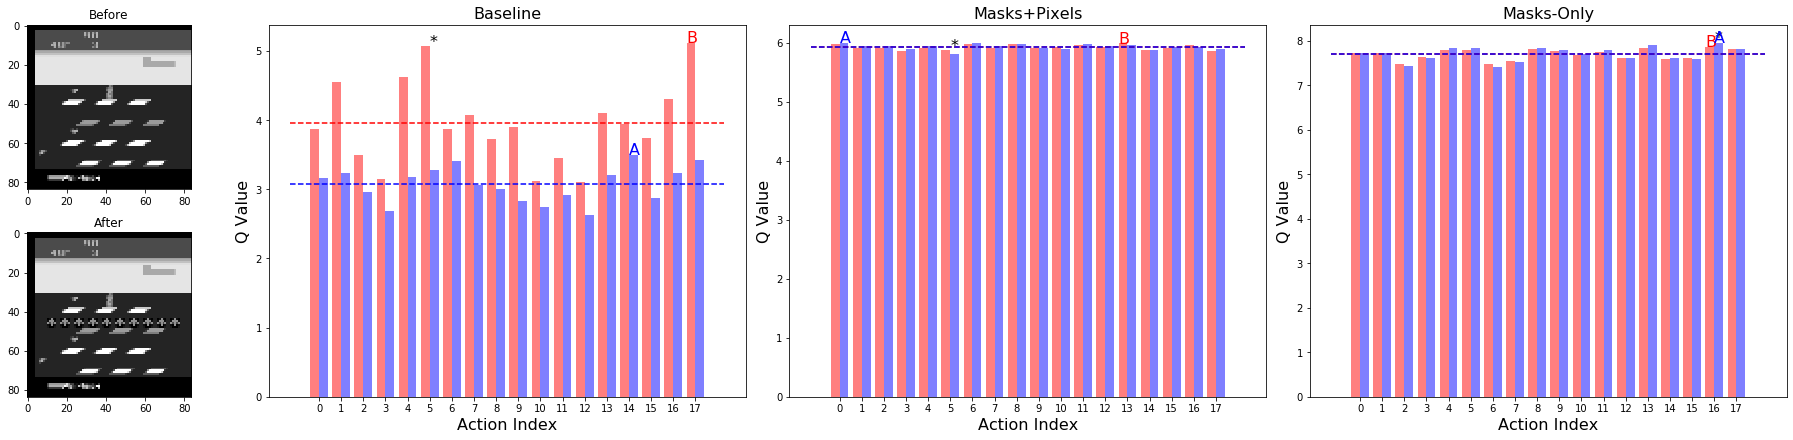

----

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.204 | Difference: 0.248
Max Q value diff is 0.583 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.336)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.203 | Difference: -0.720
Max Q value diff is 0.825 for action up + left [7]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 5.391)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 6.834 | Difference: -0.863
Max Q value diff is 0.968 for action up + left + fire [15]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 7.113)



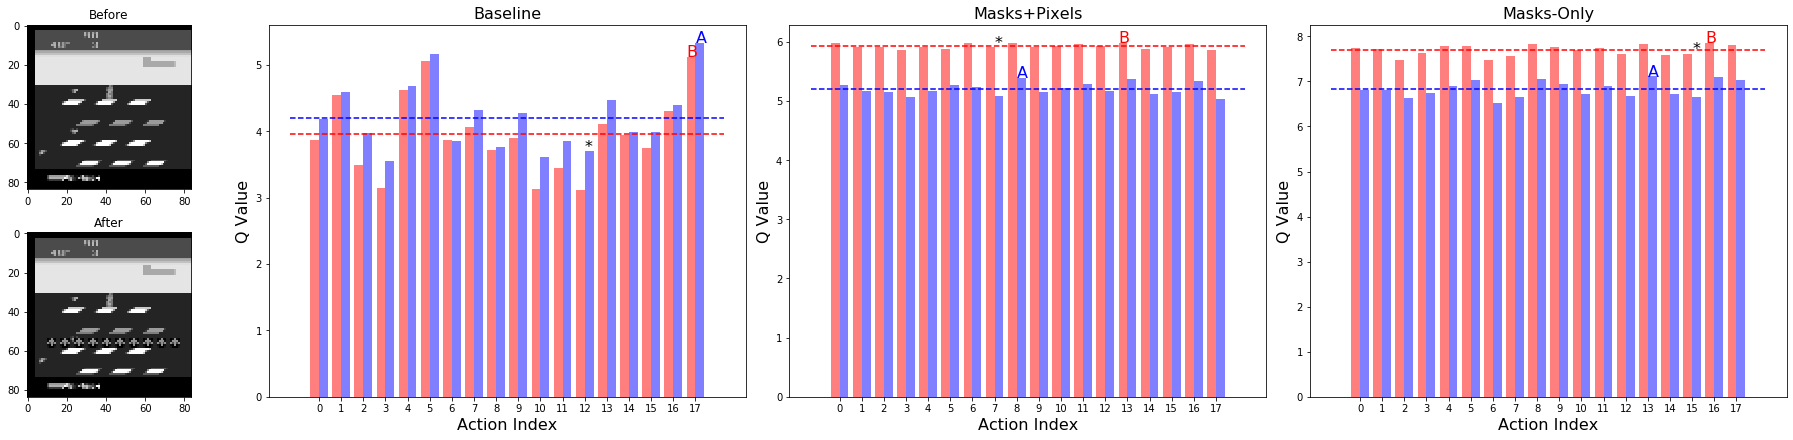

----

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.107 | Difference: 0.150
Max Q value diff is 0.456 for action up + left + fire [15]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.500)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.609 | Difference: -0.314
Max Q value diff is 0.344 for action up + left [7]
Before action: down + fire [13] (Q = 5.989) | After action: up + right [6] (Q = 5.702)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.639 | Difference: -0.059
Max Q value diff is 0.098 for action left [4]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + left + fire [17] (Q = 7.786)



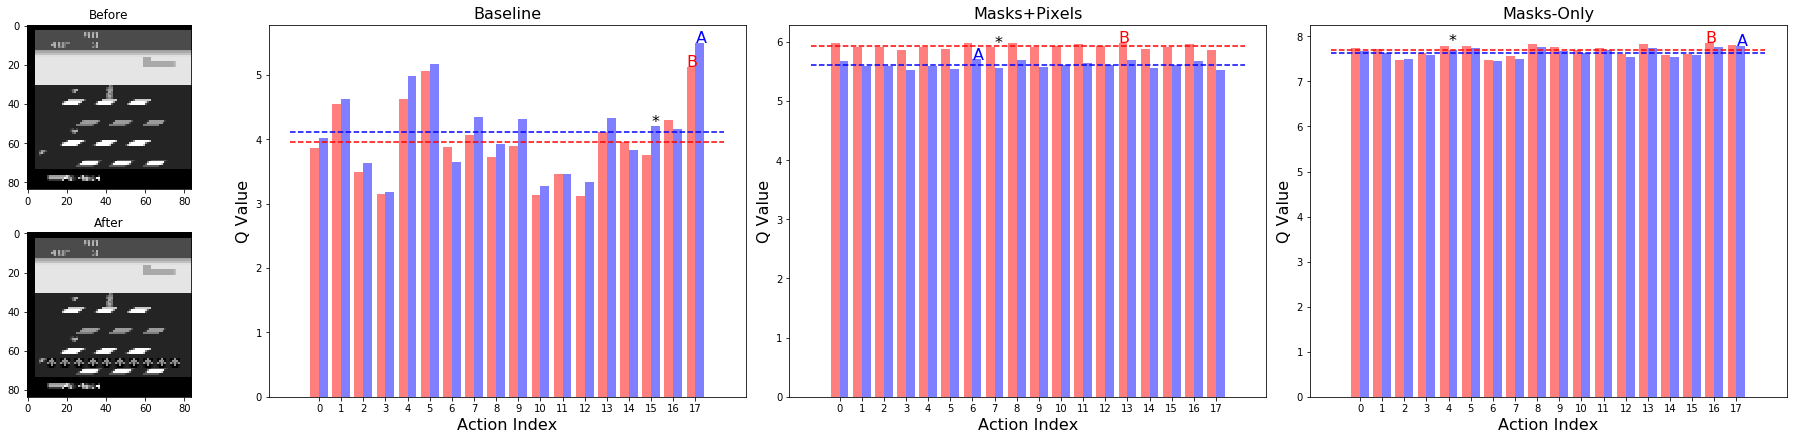

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.433 | Difference: -0.223
Max Q value diff is 0.676 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.091)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 2.978 | Difference: -0.270
Max Q value diff is 0.399 for action up + right + fire [14]
Before action: left [4] (Q = 3.697) | After action: up + left + fire [15] (Q = 3.373)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 5.163 | Difference: 0.002
Max Q value diff is 0.359 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.957)



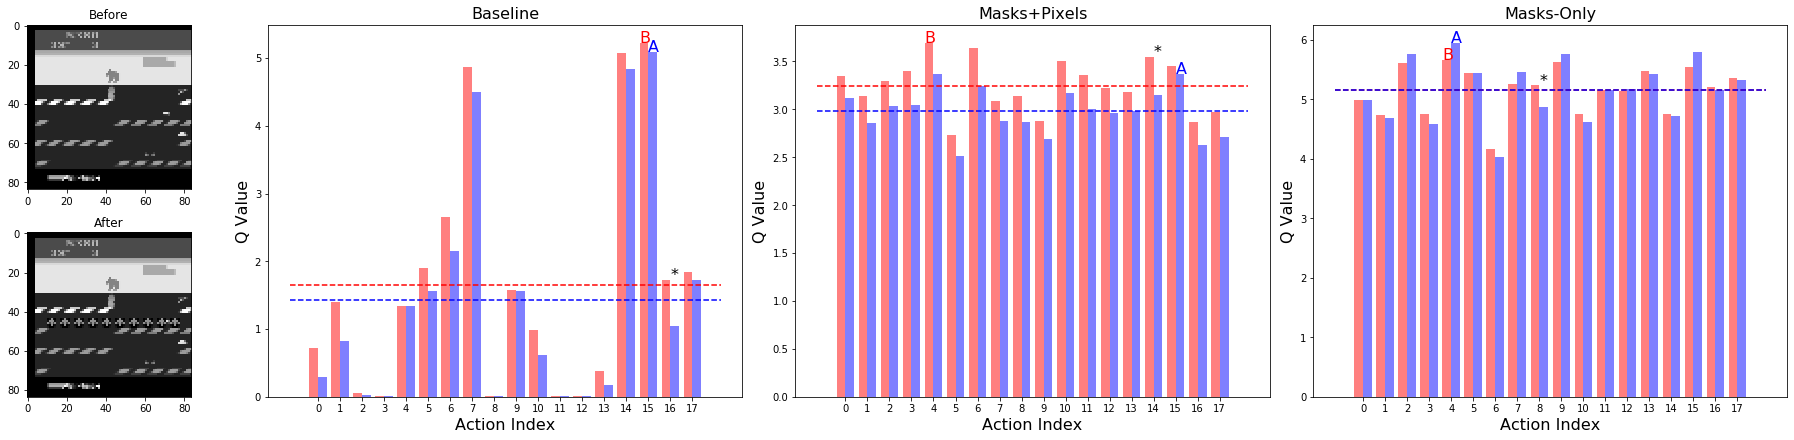

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.491 | Difference: -0.166
Max Q value diff is 0.991 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.335)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.298 | Difference: 0.050
Max Q value diff is 0.360 for action down [5]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 3.623)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.694 | Difference: -0.467
Max Q value diff is 0.780 for action up + right [6]
Before action: left [4] (Q = 5.666) | After action: down + left [9] (Q = 5.363)



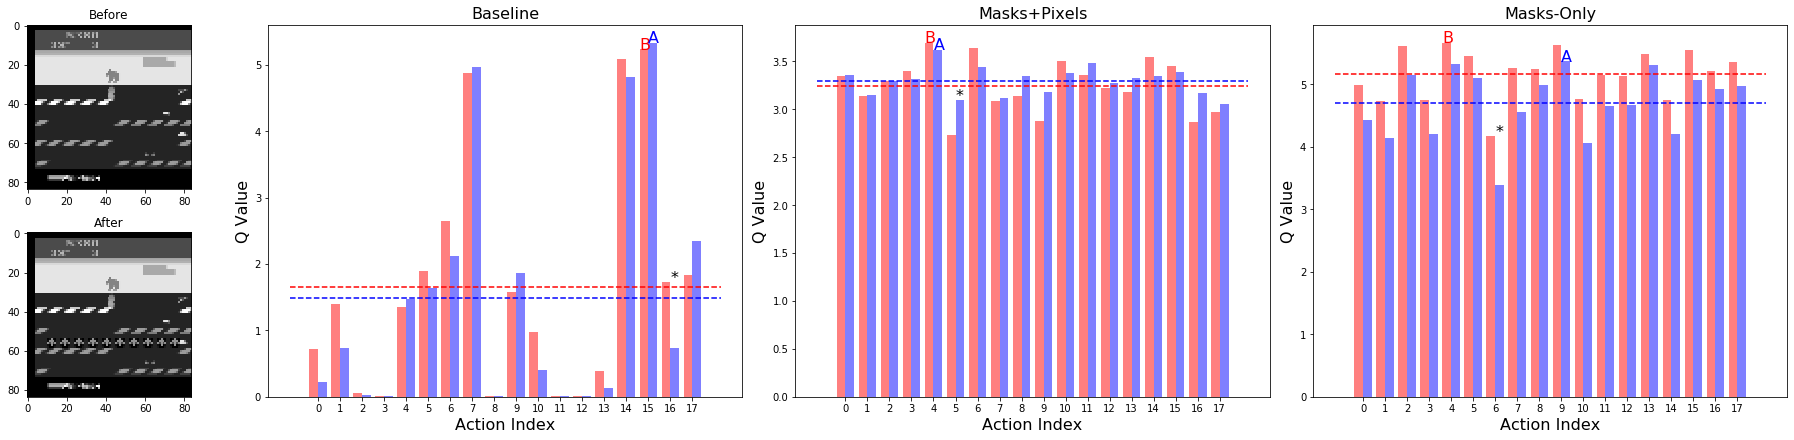

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.777 | Difference: 0.120
Max Q value diff is 0.299 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.463)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.261 | Difference: 0.013
Max Q value diff is 0.236 for action up + right + fire [14]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 3.704)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 5.125 | Difference: -0.036
Max Q value diff is 0.144 for action down + fire [13]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.685)



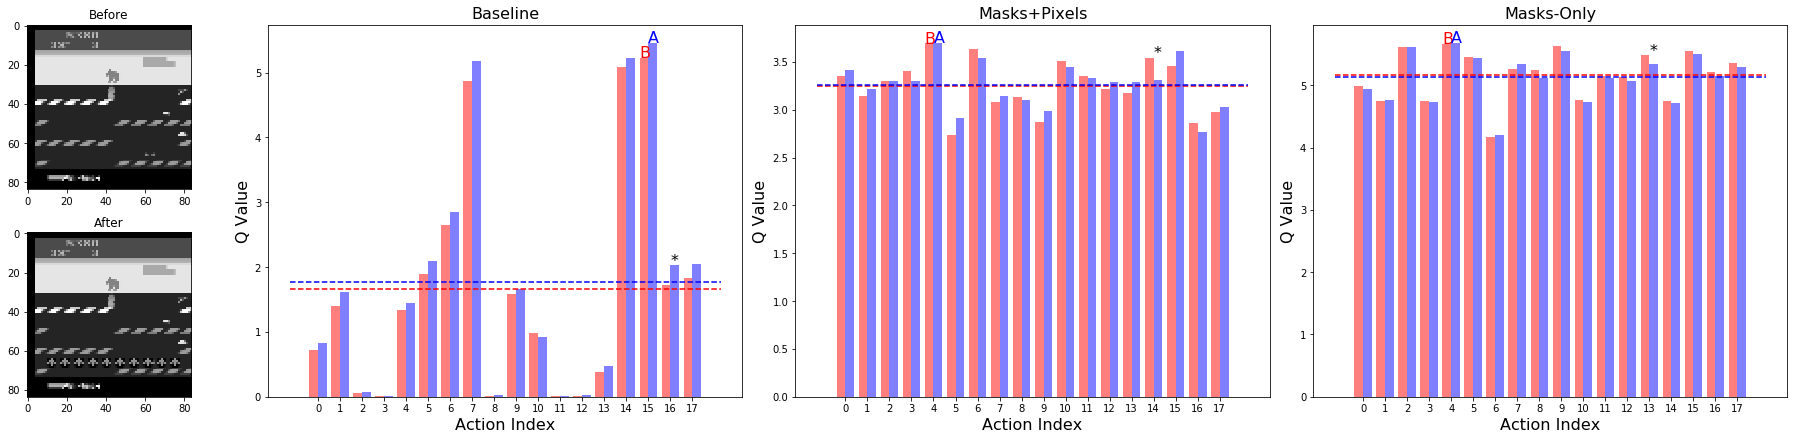

----

## Visited Floes

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 3.074 | Difference: -0.883
Max Q value diff is 1.792 for action down [5]
Before action: down + left + fire [17] (Q = 5.122) | After action: up + right + fire [14] (Q = 3.497)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 6.888 | Difference: 0.965
Max Q value diff is 1.019 for action right [3]
Before action: down + fire [13] (Q = 5.989) | After action: right + fire [11] (Q = 6.932)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.262 | Difference: -0.436
Max Q value diff is 0.812 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + fire [13] (Q = 7.579)



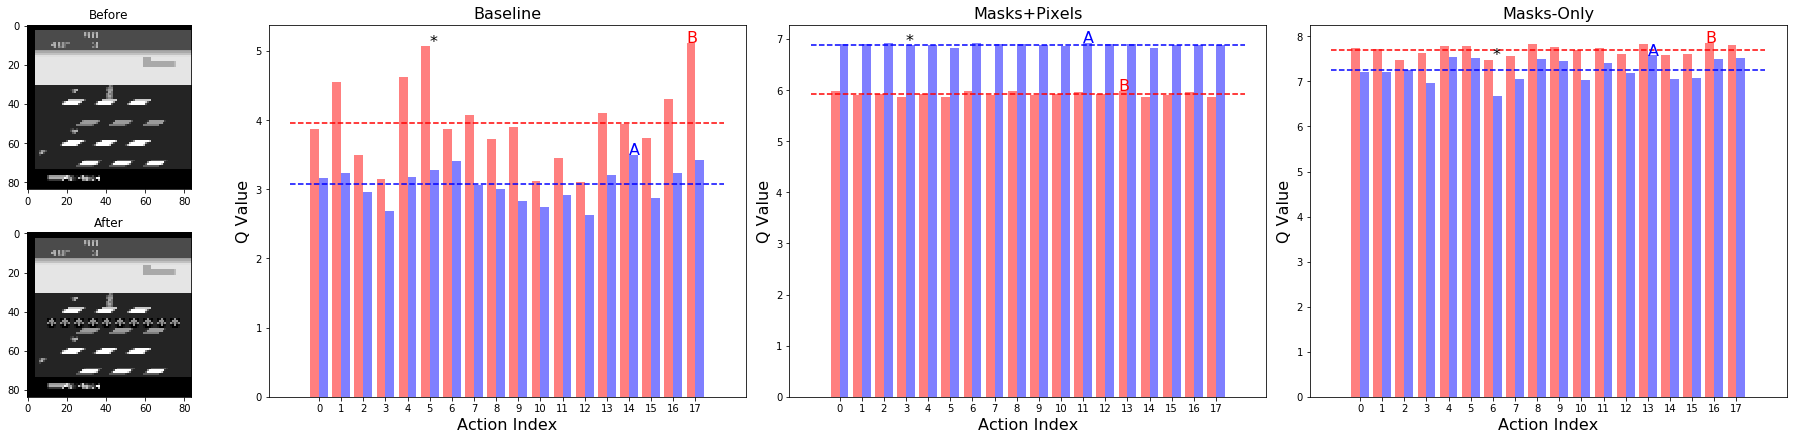

----

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.204 | Difference: 0.248
Max Q value diff is 0.583 for action left + fire [12]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.336)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.707 | Difference: -0.216
Max Q value diff is 0.308 for action down + left + fire [17]
Before action: down + fire [13] (Q = 5.989) | After action: down + right [8] (Q = 5.816)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.689 | Difference: -0.009
Max Q value diff is 0.122 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right + fire [16] (Q = 7.938)



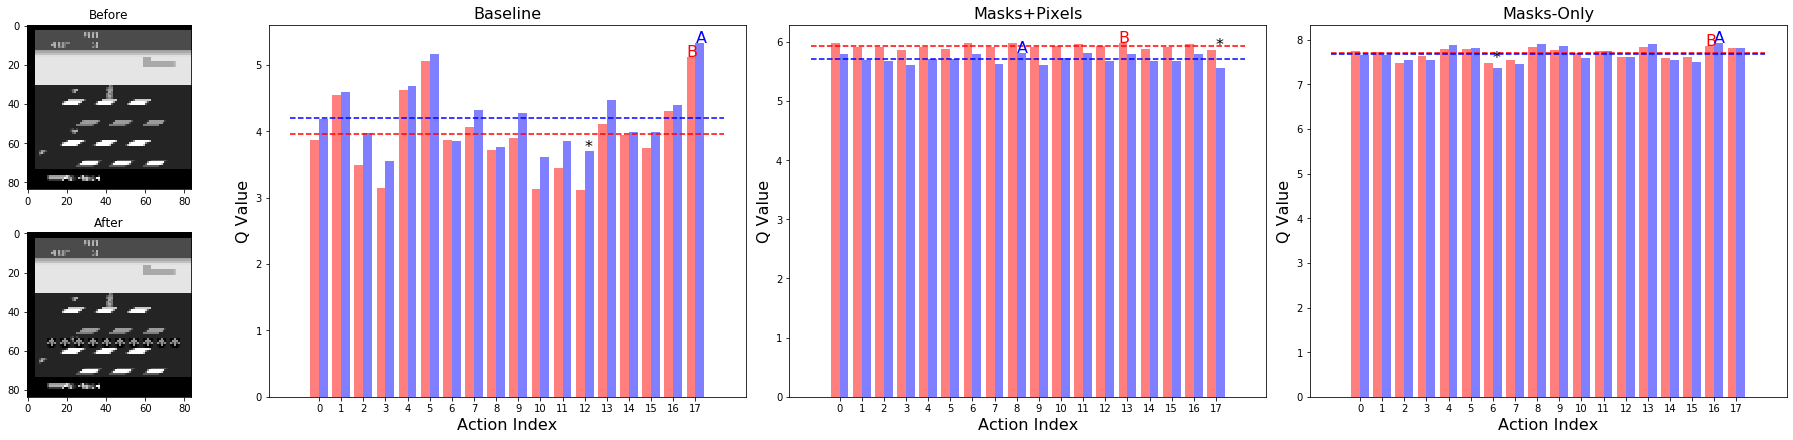

----

For model Baseline:
Baseline mean: 3.957 | Augmented mean: 4.107 | Difference: 0.150
Max Q value diff is 0.456 for action up + left + fire [15]
Before action: down + left + fire [17] (Q = 5.122) | After action: down + left + fire [17] (Q = 5.500)

For model Masks+Pixels:
Baseline mean: 5.923 | Augmented mean: 5.707 | Difference: -0.216
Max Q value diff is 0.228 for action up + right + fire [14]
Before action: down + fire [13] (Q = 5.989) | After action: up + right [6] (Q = 5.779)

For model Masks-Only:
Baseline mean: 7.698 | Augmented mean: 7.442 | Difference: -0.256
Max Q value diff is 0.317 for action up + right [6]
Before action: down + right + fire [16] (Q = 7.864) | After action: down + right + fire [16] (Q = 7.659)



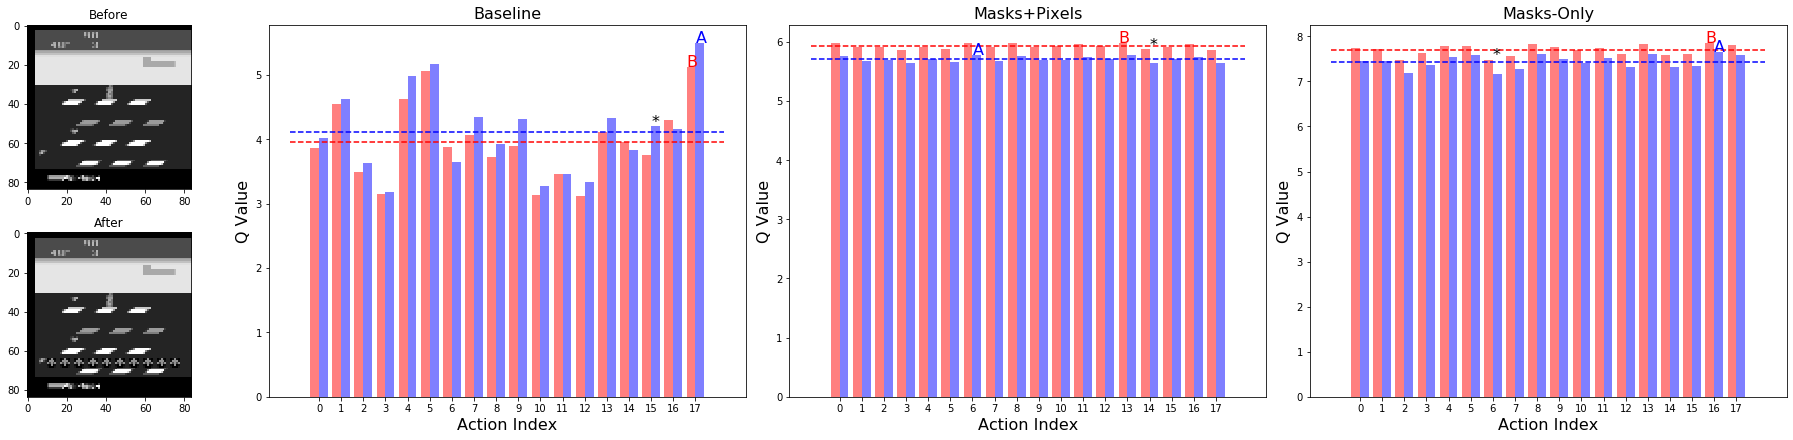

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.433 | Difference: -0.223
Max Q value diff is 0.676 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.091)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 4.079 | Difference: 0.831
Max Q value diff is 1.033 for action down + right + fire [16]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 4.321)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.253 | Difference: -0.908
Max Q value diff is 1.522 for action down + right [8]
Before action: left [4] (Q = 5.666) | After action: left [4] (Q = 5.558)



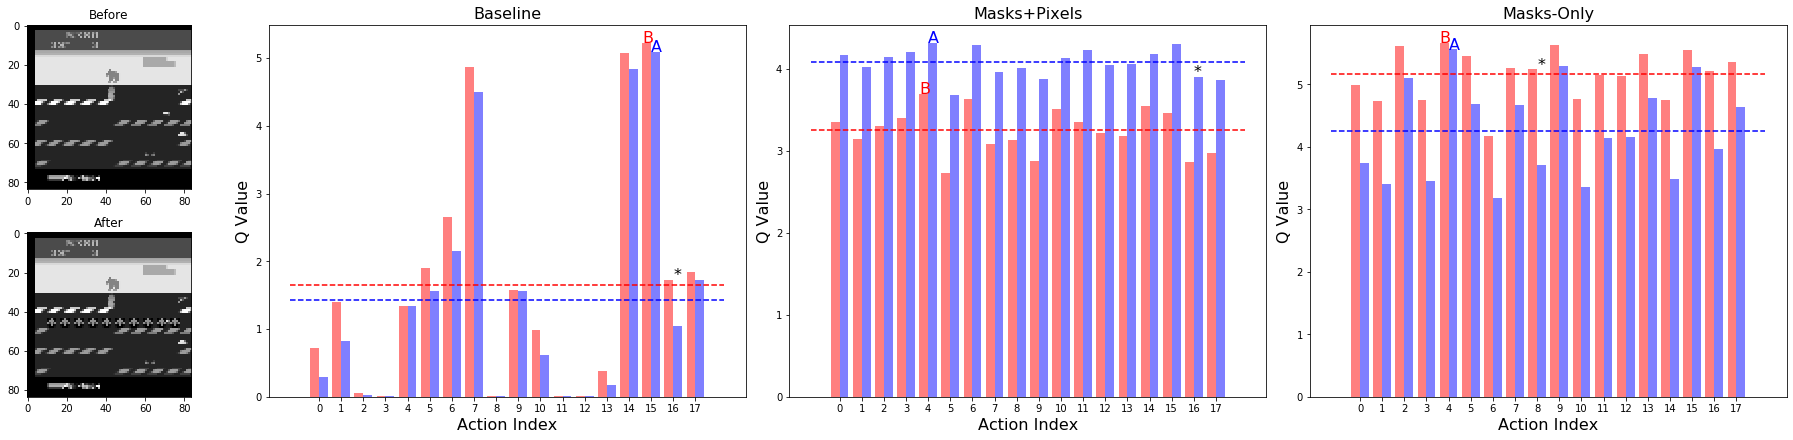

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.491 | Difference: -0.166
Max Q value diff is 0.991 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.335)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.421 | Difference: 0.173
Max Q value diff is 0.235 for action down [5]
Before action: left [4] (Q = 3.697) | After action: left [4] (Q = 3.848)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.387 | Difference: -0.774
Max Q value diff is 1.079 for action up + right [6]
Before action: left [4] (Q = 5.666) | After action: down + left [9] (Q = 5.008)



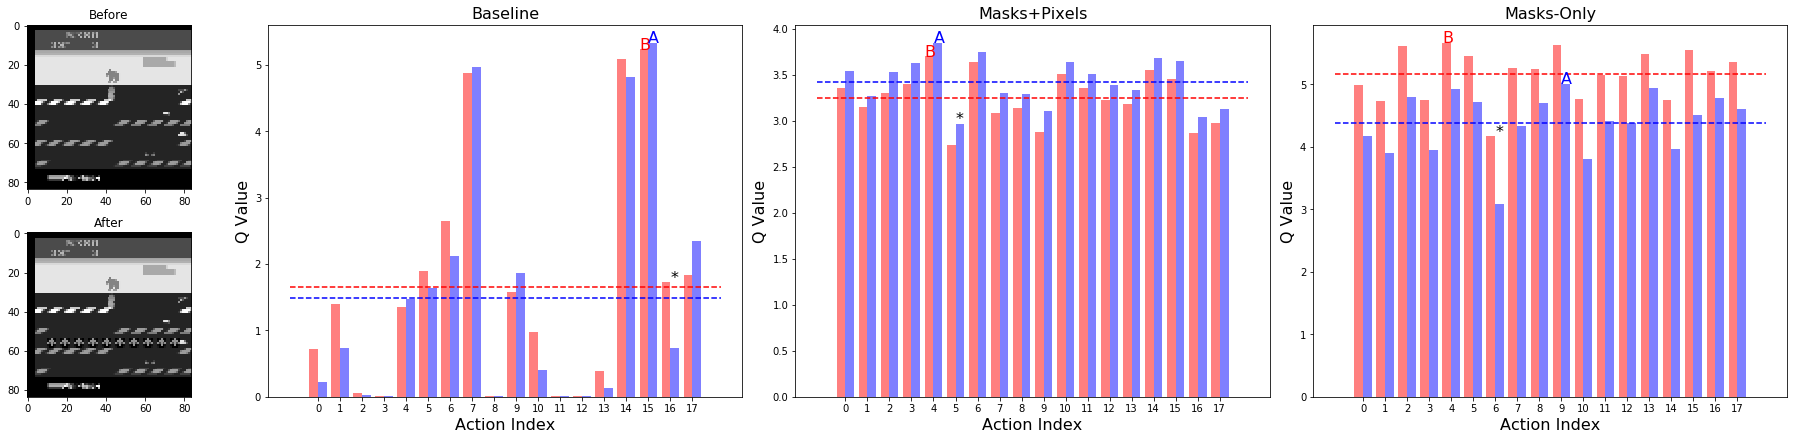

----

For model Baseline:
Baseline mean: 1.657 | Augmented mean: 1.777 | Difference: 0.120
Max Q value diff is 0.299 for action down + right + fire [16]
Before action: up + left + fire [15] (Q = 5.229) | After action: up + left + fire [15] (Q = 5.463)

For model Masks+Pixels:
Baseline mean: 3.248 | Augmented mean: 3.477 | Difference: 0.229
Max Q value diff is 0.294 for action up + left [7]
Before action: left [4] (Q = 3.697) | After action: up + right [6] (Q = 3.856)

For model Masks-Only:
Baseline mean: 5.161 | Augmented mean: 4.638 | Difference: -0.523
Max Q value diff is 0.867 for action up + right [6]
Before action: left [4] (Q = 5.666) | After action: down + left [9] (Q = 5.329)



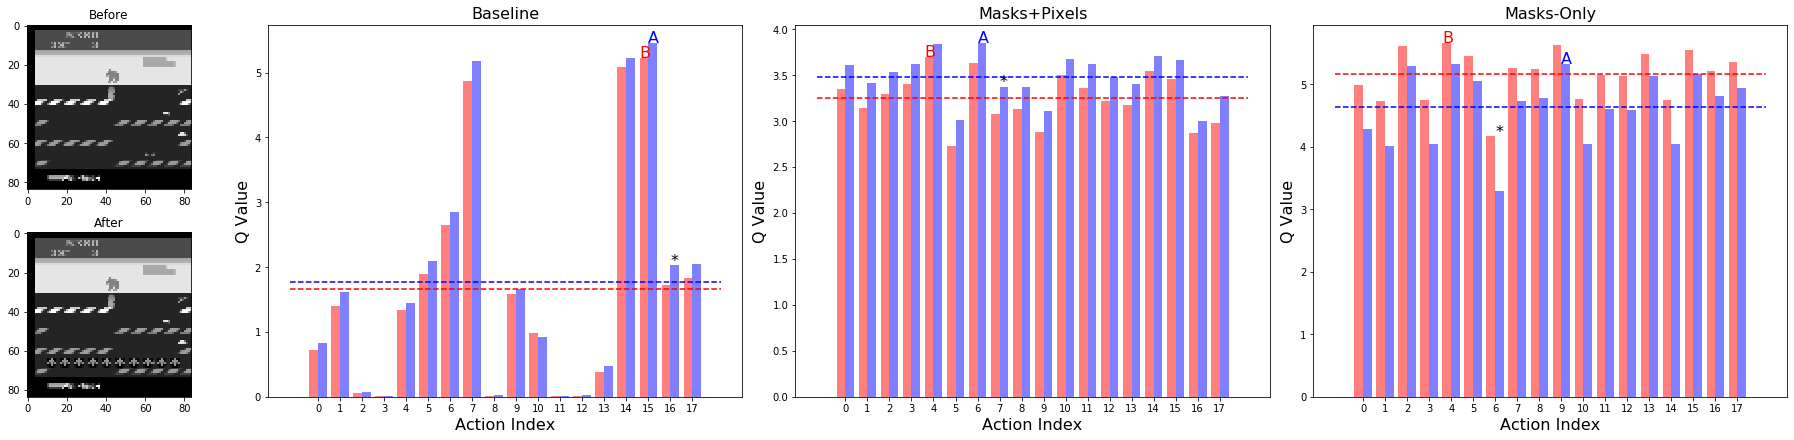

----

In [143]:
SRC_OBS_INDEX = 325
CHANNEL_INDEX = 6
START_LOC = (44, 10)

for name, channel_index in zip(('Unvisited Floes', 'Visited Floes'), (4, 5)):
    display(Markdown(f'## {name}'))
    
    for dst_index, row_loc_incs in zip((94, 1112),
                                       ((0, 10, 20), (0, 10, 20))):
        for row_loc_inc in row_loc_incs:

            NEW_LOCATIONS = [(START_LOC[0] + row_loc_inc, START_LOC[1] + 7 * i) for i in range(10)]

            baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug =\
                make_augmentations_all_models(baseline_aug_template, masks_and_pixels_aug_template, masks_only_aug_template,
                                              darker_small_alien_tensor, small_alien_mask_tensor, channel_index, NEW_LOCATIONS)

            evaluate_augmented_models(sample_full_color_observations, dst_index, 
                                     [baseline_alien_as_bad_animal_aug, masks_and_pixels_alien_as_bad_animal_aug, masks_only_alien_as_bad_animal_aug],
                                      force_text=True)

            display(Markdown('----'))
    




# C.6 Aliens as...?

# Appendix: Plotting samples states to grab objects from

In [ ]:
plot_observations(sample_full_color_observations, 1270, 5, 2)

# Appendix: finding intriguing states to modify

In [ ]:
result_sets = (baseline_model_results, masks_and_pixels_model_results, masks_only_model_results)

q_value_arrays = [np.array([x.cpu().numpy() for x in result_set.q_values])
                  for result_set in result_sets]
mean_q_value_arrays = [np.tile(q_vals.mean(1), (q_vals.shape[1], 1)).T
                       for q_vals in q_value_arrays]
msd_array = np.array([np.power(q - mean, 2).mean(1) for (q, mean)
                      in zip(q_value_arrays, mean_q_value_arrays)])

mean_q_values = np.array([q_vals.mean(1) for q_vals in q_value_arrays])

indices_without_extrema_q = np.argwhere(np.all(np.logical_and(mean_q_values > 3, mean_q_values < 7), axis=0))[:,0]

indices_with_all_models_msd = np.argwhere(np.all(msd_array > 1, axis=0))[:,0]
indices_with_two_models_msd = np.argwhere(np.sum(msd_array > 1, axis=0) > 0.5)[:,0]

interesting_indices = sorted(set(list(indices_without_extrema_q)).intersection(set(list(indices_with_two_models_msd))))
print(len(indices_without_extrema_q), len(indices_with_two_models_msd), len(interesting_indices))
print(interesting_indices)

s = 5
for i in range(len(interesting_indices) // s):
    plot_observations_by_indices(sample_full_color_observations, interesting_indices[i * s:(i + 1) * s])

In [ ]:
def plot_q_values(result_sets, names, **kwargs):
    plt.figure(figsize=(16, 6))

    q_value_arrays = [np.array([x.cpu().numpy() for x in result_set.q_values])
                         for result_set in result_sets]
    mean_q_value_arrays = [np.tile(q_vals.mean(1), (q_vals.shape[1], 1)).T
                           for q_vals in q_value_arrays]
    msd_arrays = [np.power(q - mean, 2).mean(1) for (q, mean)
                  in zip(q_value_arrays, mean_q_value_arrays)]
    
    mean_ax = plt.subplot(2, 2, 1)
    msd_ax = plt.subplot(2, 2, 2)
    
    for vals, msds, name in zip(q_value_arrays, msd_arrays, names):
        mean_ax.plot(vals.mean(1), label=name, **kwargs)
        msd_ax.plot(msds, label=name, **kwargs)
        
    mean_array = np.array([np.array([x.cpu().numpy() for x in res.q_values]).mean(1)
                           for res in result_sets])
    
    min_max_mean_ax = plt.subplot(2, 2, 3)
    min_max_mean_ax.plot(mean_array.min(0), label='Min')
    min_max_mean_ax.plot(mean_array.max(0), label='Max')
    
    mean_msd_ax = plt.subplot(2, 2, 4)
        
    mean_ax.legend(loc='best')
    msd_ax.legend(loc='best')
        
    plt.show()


plot_q_values((baseline_model_results, masks_and_pixels_model_results, masks_only_model_results),
              ('Baseline', 'Masks+Pixels', 'Masks-Only'), alpha=0.5)

In [ ]:
indices_without_extrema_q

In [44]:
list(range(100, 100 + 10 * 10, 10))dd

[100, 110, 120, 130, 140, 150, 160, 170, 180, 190]

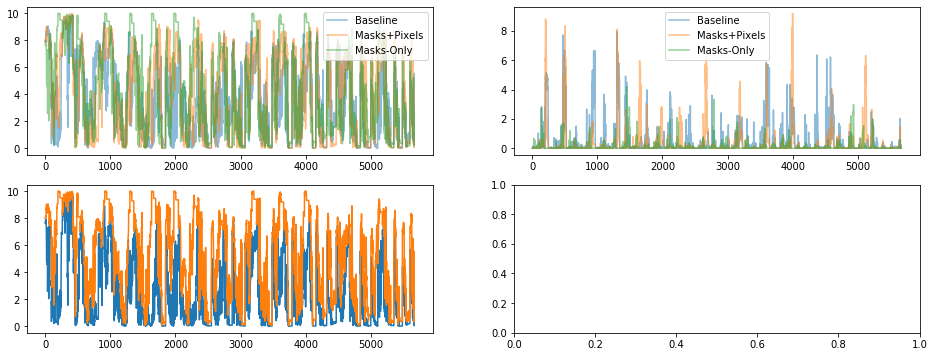